# Neural Network-based Encrypted Traffic Classification and Application Categorization Framework for the Tor Network

Traffic classification can be useful in network monitoring, quality–of–service management, and intrusion–detection. 
Recently, the number/types of applications have grown and new protocols are required.Conventional traffic classification 
methods do not adapt effectively, and the problem becomes more severe for encrypted traffic. Operators must encrypt most 
network traffic due to increased demand for user privacy. This paper proposes a deep learning (DL)–based encrypted traffic 
categorization and application service classification method. Two well–known neural networks, namely a deep neural network 
(DNN) and convolutional neural network (CNN), are implemented for classification while considering temporal features. We 
study the performance of DL models with various feature selection methods (FSM) and different TCP traffic flow timeouts. 
We propose use case scenario for encrypted traffic classification in a software– defined wireless network (SDWN). The results
indicate DNN model using information gain (IG), a TCP timeout of 60s provides an accuracy of 100\% and a generalization gap (GG) 
of 0.001 in the training phase, for encrypted and benign traffic classification. Testing accuracy and loss of 99.9\% and 0.01, 
respectively, are achieved. The CNN model using correlation(Corr), a TCP timeout of 120s has accuracy of 90\% and a GG of 0.7 in 
the training phase. For testing an accuracy and a loss up to 84.2\% and 0.81, respectively is achieved. Execution timestep of 
30 and 220µs are estimated for traffic categorization and application service classification. Compared to existing work, the DL
model shows improvements of up to 86\%, 64\%, and 21\% in F1–score, precision, and recall values, respectively.

** Keywords: deep neural network (DNN), convolutional neural network (CNN), traffic categorization, application service classification,feature selection methods (FSMs), network management**



![](http://localhost:8889/edit/Sys_model.pdf) 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os                   
from scipy.io.arff import loadarff 
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D,Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam, SGD
from keras import optimizers
from keras.callbacks import CSVLogger
from keras.callbacks import LearningRateScheduler
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot
import seaborn as sns
import glob
#from sgdr import SGDRScheduler
import time


In [3]:
Architectures = ['Dense','CNN']
DATASET_IDs = ['TorVsNonTor', 'Labels']
Methods = ['InfoGain','Correlation']
Correlation_Rank = ['min_fiat','min_biat','mean_flowiat','duration','std_flowiat','max_biat',
                   'max_idle','max_flowiat','mean_idle','mean_biat','min_idle','max_fiat','mean_fiat','max_active','class1']

InfoGain_Rank = ['min_biat','min_fiat','max_biat','max_fiat','flowBytesPerSecond','mean_flowiat',
                 'flowPktsPerSecond','mean_fiat','max_flowiat','mean_biat','std_flowiat','min_flowiat','duration','class1']
                
#Both_Rank =                    'max_idle','mean_idle','min_idle','max_active']
DataSetDurations = ['15s','30s','60s','120s']
Path = 'CSV/Scenario-A'
models = []
LEARN_RATE = 1.0e-4

In [4]:
Architectures = ['CNN']
DATASET_IDs = ['Labels']
Methods = ['InfoGain','Correlation']
Correlation_Rank = ['min_fiat','min_biat','mean_flowiat','duration','std_flowiat','max_biat',
                   'max_idle','max_flowiat','mean_idle','mean_biat','min_idle','max_fiat','mean_fiat','max_active','class1']

InfoGain_Rank = ['min_biat','min_fiat','max_biat','max_fiat','flowBytesPerSecond','mean_flowiat',
                 'flowPktsPerSecond','mean_fiat','max_flowiat','mean_biat','std_flowiat','min_flowiat','duration','class1']
                
#Both_Rank =                    'max_idle','mean_idle','min_idle','max_active']
DataSetDurations = ['15s','30s','60s','120s']
Path = 'CSV/Scenario-A'
models = []
LEARN_RATE = 1.0e-4

In [19]:
def plot(train_history,log_dir):
    # plot training and validation loss
    pyplot.figure()
    pyplot.plot(train_history.history['loss'], label='loss')
    pyplot.plot(train_history.history['val_loss'], label='val_loss')
    pyplot.title('Training and Validation Loss')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Loss')
    pyplot.legend()
    pyplot.savefig(os.path.join(log_dir, 'loss1.png'))
    pyplot.show(block=False)
    
    # plot training and validation accuracy
    pyplot.figure()
    pyplot.plot(train_history.history['acc'],
                                      label='acc')
    pyplot.plot(train_history.history['val_acc'],
                                      label='val_acc')
    pyplot.title('Training and Validation Accuracy')
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Accuracy')
    pyplot.legend()
    pyplot.savefig(os.path.join(log_dir, 'accuracy1.png'))
    pyplot.show(block=False)
    
    return
def getTrainData(data,dataset): 
    Path = 'CSV/Scenario-A/TimeBasedFeatures-{}-TOR-NonTOR-85.arff'.format(data)
    if dataset == 'Labels':
        Path = 'CSV/Scenario-B/TimeBasedFeatures-{}-Layer2-85.arff'.format(data)
    print('[INFO] PATH FOR LOADED DATASET: {}'.format(Path))
    trainraw_data = loadarff(Path)
    dfTrain_data = pd.DataFrame(trainraw_data[0])
    if method == 'InfoGain':
        print('[INFO] Data loaded for info Gain')
        dfTrain_data = dfTrain_data[InfoGain_Rank]
    else:
        print('[INFO] Data loaded for Correlation')
        dfTrain_data = dfTrain_data[Correlation_Rank]
        
    dfTrain_data = removeNanVlaues(dfTrain_data)
    dfTrain_data.head()
    dfTrain_dataValues = dfTrain_data.values
        
    x_train = dfTrain_dataValues[:, :len(dfTrain_data.columns)-1]
    #print('Training Data Shape {}'.format(x_train.shape))
    x_train = dataPreProcessing(x_train)
    y_train = dfTrain_dataValues[:,len(dfTrain_data.columns)-1]
    #print('[INFO] Training Data Label Shape {}'.format(y_train.shape))
    
    y_train = labelPreProcessing(y_train)
   
    return x_train, y_train

def getTestData(data,dataset): 
    Path = 'CSV/Scenario-A/TimeBasedFeatures-{}-TOR-NonTOR-15.arff'.format(data)
    if dataset == 'Labels':
        Path = 'CSV/Scenario-B/TimeBasedFeatures-{}-Layer2-15.arff'.format(data)    
    testraw_data = loadarff(Path)
    dfTest_data = pd.DataFrame(testraw_data[0])
    #print('[INFO] Feature Selection Method {}'.format(method))
    if method == 'InfoGain':
        dfTest_data = dfTest_data[InfoGain_Rank]
    else:
        dfTest_data = dfTest_data[Correlation_Rank]
        
    dfTest_data = removeNanVlaues(dfTest_data)
    dfTest_dataValues = dfTest_data.values
    x_test = dfTest_dataValues[:, :len(dfTest_data.columns)-1]
    x_test = dataPreProcessing(x_test)
    y_test = dfTest_dataValues[:,len(dfTest_data.columns)-1]
    y_test = labelPreProcessing(y_test)
    return x_test, y_test
def removeNanVlaues(df):
    df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    return df

def labelPreProcessing(y):
    #print('[INFO] Before Preprocssing Y Labels {}'.format(y))
    if DATASET_ID != 'Labels':
        cv = CountVectorizer()
        y = cv.fit_transform(y).toarray()
    else:
        labels = []
        for l in y:
            li = []
            li.append(l)
            labels.append(li)
        labels = np.array(labels)
        y = MultiLabelBinarizer().fit_transform(labels)
    #y = MultiLabelBinarizer().fit_transform(y)
    #print('Y Shape after preprocesng {}'.format(y))
    #lb = preprocessing.LabelBinarizer()
    #y = lb.fit_transform(y)
    #y = to_categorical(y)
    #print('Y Shape after Categoical {}'.format(y))
    #print('[INFO] After Preprocssing Y Labels {}'.format(y))
    return y
def dataPreProcessing(x):
    sc = StandardScaler()
    x = sc.fit_transform(x)
    print(x.shape)
    return x
def denseModel(input_dim , output_dim):
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(250, activation='relu', kernel_initializer='random_normal', input_dim=input_dim))
    #Second  Hidden Layer
    classifier.add(Dense(250, activation='relu', kernel_initializer='random_normal'))
    #Third Hidden Layer
    classifier.add(Dense(250, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(output_dim, activation='sigmoid', kernel_initializer='random_normal'))
    #Compile the model
    #classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    classifier.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=LEARN_RATE), # Adam optimizer with 1.0e-4 learning rate
                     metrics = ['accuracy']) 
    return classifier
    
def cnnModel(input_dim , output_dim):
    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='random_normal',
                     input_shape=(input_dim,1),
                     padding='same'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='random_normal', padding='same'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='random_normal', padding='same'))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='random_normal', padding='same'))
    #model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))

    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    
    LEARN_RATE = 1.0e-4
    model.compile(loss='categorical_crossentropy', # Better loss function for neural networks
              optimizer=Adam(lr=0.001), # Adam optimizer with 1.0e-4 learning rate
                     metrics = ['accuracy']) # Metrics to be evaluated by the model
    
    
    
    #model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    #model.summary()
    return model
def callbacks(log_file,cpt_best,cpt_last):
    cb_log = CSVLogger(filename=log_file, append=True)
    #cb_stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
    cb_cpt_best = ModelCheckpoint(filepath=cpt_best, monitor='val_acc', save_best_only=True, save_weights_only=True, verbose=1)
    cb_cpt_last = ModelCheckpoint(filepath=cpt_last, monitor='val_acc', save_best_only=False, save_weights_only=True, verbose=0)
    return [cb_log, cb_cpt_best, cb_cpt_last ] 

In [15]:
    # Do not run in SQUENCE         
                json_file = open('output/Labels/CNN/Correlation/60s/models/CNN_train.json', 'r')
                loaded_model_json = json_file.read()
                json_file.close()
                loaded_model = model_from_json(loaded_model_json)
                # load weights into new model
                loaded_model.load_weights('output/Labels/CNN/Correlation/60s/logs/CNN_best.h5')

In [14]:
loaded_model.compile(loss='categorical_crossentropy', 
                              optimizer=Adam(lr=0.01),
                              metrics = ['accuracy']) 

In [ ]:
import timeit
start = timeit.default_timer()
results = loaded_model.evaluate(x_train, y_train)
stop = timeit.default_timer()
print('Time: ', stop - start)  

In [ ]:
#Testing Accuracy
from keras.models import model_from_json
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,
                                                         method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                # load json and create model
                print("Loading {} Model for {}".format(ARCHITECTURE,DATASET_ID))
                json_file = open(mdl_train_file, 'r')
                loaded_model_json = json_file.read()
                json_file.close()
                loaded_model = model_from_json(loaded_model_json)
                # load weights into new model
                loaded_model.load_weights(cpt_best)
                print("Loaded for {} with {} Data set".format(method,DataSetDuration))
                #print("load weights path: {}".format(cpt_best))
                loaded_model.compile(loss='categorical_crossentropy', 
                              optimizer=Adam(lr=0.01),
                              metrics = ['accuracy']) 
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                #x_test, y_test = getTrainData(DataSetDuration,DATASET_ID)
                
                if ARCHITECTURE != 'Dense':
                    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype( 'float32' )
                #t = time.time()
                start = timeit.default_timer()
                results = loaded_model.evaluate(x_test, y_test)
                stop = timeit.default_timer()
                print('Total Time: ', stop - start)  
                #print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)


output/Labels/CNN/Correlation/120s/logs/CNN_best.h5

In [496]:
#Testing Accuracy
from keras.models import model_from_json
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,
                                                         method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                # load json and create model
                print("Loading {} Model for {}".format(ARCHITECTURE,DATASET_ID))
                json_file = open(mdl_train_file, 'r')
                loaded_model_json = json_file.read()
                json_file.close()
                loaded_model = model_from_json(loaded_model_json)
                # load weights into new model
                loaded_model.load_weights(cpt_best)
                print("Loaded for {} with {} Data set".format(method,DataSetDuration))
                #print("load weights path: {}".format(cpt_best))
                loaded_model.compile(loss='categorical_crossentropy', 
                              optimizer=Adam(lr=0.01),
                              metrics = ['accuracy']) 
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                #x_test, y_test = getTrainData(DataSetDuration,DATASET_ID)
                
                if ARCHITECTURE != 'Dense':
                    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype( 'float32' )
                #t = time.time()
                start = timeit.default_timer()
                results = loaded_model.evaluate(x_test, y_test)
                stop = timeit.default_timer()
                print('Total Time: ', stop - start)  
                #print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)


#output/Labels/CNN/Correlation/120s/logs/CNN_best.h5

Loading Dense Model for TorVsNonTor
Loaded for InfoGain with 15s Data set
(3311, 13)
3311/3311 [==============================] - 6s 2ms/step
('Total Time: ', 5.761416912078857)
('TEST LOSS, TEST ACCURACY:', [2.138543234011478, 0.7103594080338267])
Loading Dense Model for TorVsNonTor
Loaded for InfoGain with 30s Data set
(2464, 13)
2464/2464 [==============================] - 6s 2ms/step
('Total Time: ', 5.746367931365967)
('TEST LOSS, TEST ACCURACY:', [0.8555302006236363, 0.939935064935065])
Loading Dense Model for TorVsNonTor
Loaded for InfoGain with 60s Data set
(2465, 13)
2465/2465 [==============================] - 6s 2ms/step
('Total Time: ', 5.717650890350342)
('TEST LOSS, TEST ACCURACY:', [0.017378186736285092, 0.9983772819472616])
Loading Dense Model for TorVsNonTor
Loaded for InfoGain with 120s Data set
(1688, 13)
1688/1688 [==============================] - 6s 3ms/step
('Total Time: ', 5.525129079818726)
('TEST LOSS, TEST ACCURACY:', [0.029124003536865516, 0.985781990521327]

In [ ]:
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
                log_file = os.path.join(log_dir, 'training.csv')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                cpt_last = os.path.join(log_dir, '{}_last.h5'.format(ARCHITECTURE))
                output_dirs = [OUTPUT_DIR,mdl_dir, log_dir, cpt_dir]
                output_dirs = [directory for directory in output_dirs if directory is not None]
                #Create Directories
                for directory in output_dirs:
                    if not os.path.isdir(directory):
                        os.makedirs(directory)
                    elif len(glob.glob(os.path.join(directory, '*.*'))) > 0:
                        print('[INFO] Output directory {} must be empty'.format(directory))
                        return
                
                #Get Training Data 
                x_train, y_train = getTrainData(DataSetDuration,DATASET_ID)
                print('[INFO] Y TRAIN Shape is ]{}'.format(y_train.shape))
                print('[INFO] X TRAIN Shape is ]{}'.format(x_train.shape))
                #Architectures = ['Dense','CNN']
                if ARCHITECTURE != 'Dense':
                    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1).astype( 'float32' )
                    model = cnnModel(x_train.shape[1] ,y_train.shape[1])
                    print('X TRAIN Shape is after Reshaping For CNN ]{}'.format(x_train.shape))
                else:
                     model = denseModel(x_train.shape[1] ,y_train.shape[1])
                model.summary()
                # Split Data
                x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.30, shuffle= True)                
                # serialize models to json
                model_train_json = model.to_json()
                with open(mdl_train_file, 'w') as file:
                    file.write(model_train_json)
                
                checkpoints = callbacks(log_file,cpt_best,cpt_last)
                Epochs = 40
                if DATASET_ID == 'Labels':
                    Epochs = 100 
                history = model.fit(x_train, y_train,
                     epochs=Epochs,
                     validation_data=(x_valid,y_valid),
                     shuffle=True,
                     callbacks=checkpoints,
                     batch_size= 64)
                plot(history,log_dir)
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                if ARCHITECTURE != 'Dense':
                    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype( 'float32' )
                t = time.time()
                results = model.evaluate(x_test, y_test)
                print('[INFO] Predition Total time: {}'.format( (time.time() - t)/60))
                print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)

[INFO] Output directory output/Labels/CNN/InfoGain/15s/models must be empty
[INFO] Output directory output/Labels/CNN/InfoGain/15s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-15s-Layer2-85.arff
[INFO] Data loaded for info Gain


/home/tahira/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(2856, 13)
[INFO] Y TRAIN Shape is ](2856, 8)
[INFO] X TRAIN Shape is ](2856, 13)
X TRAIN Shape is after Reshaping For CNN ](2856, 13, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13, 128)           512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 256)            98560     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 256)            196864    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 256)            0         
____

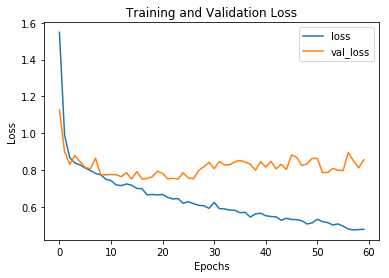

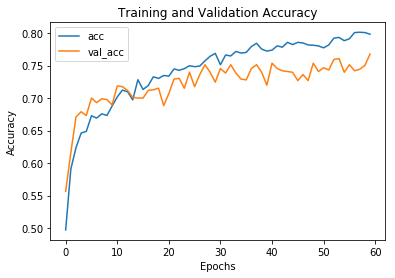

(504, 13)
504/504 [==============================] - 0s 63us/step
[INFO] Predition Total time: 0.000554001331329
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:InfoGain DataSetDuration:15s
('TEST LOSS, TEST ACCURACY:', [1.10670591855399, 0.7162698412698413])
[INFO] Output directory output/Labels/CNN/InfoGain/30s/models must be empty
[INFO] Output directory output/Labels/CNN/InfoGain/30s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-30s-Layer2-85.arff
[INFO] Data loaded for info Gain
(1532, 13)
[INFO] Y TRAIN Shape is ](1532, 8)
[INFO] X TRAIN Shape is ](1532, 13)
X TRAIN Shape is after Reshaping For CNN ](1532, 13, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 13, 128)           512       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 13, 128)           4

1072/1072 [==============================] - 0s 235us/step - loss: 0.6645 - acc: 0.6782 - val_loss: 0.8604 - val_acc: 0.6913

Epoch 00028: val_acc improved from 0.68478 to 0.69130, saving model to output/Labels/CNN/InfoGain/30s/logs/CNN_best.h5
Epoch 29/60
1072/1072 [==============================] - 0s 224us/step - loss: 0.6412 - acc: 0.6959 - val_loss: 0.8554 - val_acc: 0.6804

Epoch 00029: val_acc did not improve from 0.69130
Epoch 30/60
1072/1072 [==============================] - 0s 225us/step - loss: 0.6454 - acc: 0.7211 - val_loss: 0.9086 - val_acc: 0.6848

Epoch 00030: val_acc did not improve from 0.69130
Epoch 31/60
1072/1072 [==============================] - 0s 228us/step - loss: 0.6677 - acc: 0.7407 - val_loss: 0.8795 - val_acc: 0.6761

Epoch 00031: val_acc did not improve from 0.69130
Epoch 32/60
1072/1072 [==============================] - 0s 234us/step - loss: 0.6466 - acc: 0.7183 - val_loss: 0.8455 - val_acc: 0.6630

Epoch 00032: val_acc did not improve from 0.69130
Epo

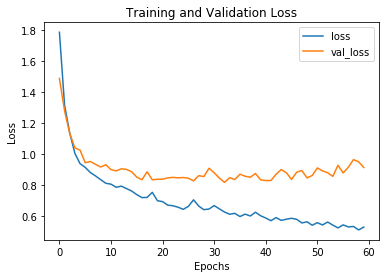

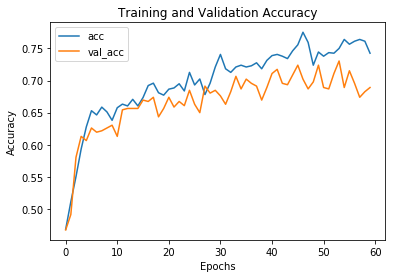

(271, 13)
271/271 [==============================] - 0s 65us/step
[INFO] Predition Total time: 0.000321980317434
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:InfoGain DataSetDuration:30s
('TEST LOSS, TEST ACCURACY:', [1.8905082320815083, 0.5166051661616322])
[INFO] Output directory output/Labels/CNN/InfoGain/60s/models must be empty
[INFO] Output directory output/Labels/CNN/InfoGain/60s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-60s-Layer2-85.arff
[INFO] Data loaded for info Gain
(795, 13)
[INFO] Y TRAIN Shape is ](795, 8)
[INFO] X TRAIN Shape is ](795, 13)
X TRAIN Shape is after Reshaping For CNN ](795, 13, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 13, 128)           512       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 13, 128)           492

Epoch 28/60
556/556 [==============================] - 0s 216us/step - loss: 0.6723 - acc: 0.7122 - val_loss: 1.2234 - val_acc: 0.6695

Epoch 00028: val_acc did not improve from 0.68201
Epoch 29/60
556/556 [==============================] - 0s 219us/step - loss: 0.6437 - acc: 0.7338 - val_loss: 1.2737 - val_acc: 0.6527

Epoch 00029: val_acc did not improve from 0.68201
Epoch 30/60
556/556 [==============================] - 0s 220us/step - loss: 0.6406 - acc: 0.7194 - val_loss: 1.2043 - val_acc: 0.6820

Epoch 00030: val_acc did not improve from 0.68201
Epoch 31/60
556/556 [==============================] - 0s 225us/step - loss: 0.6603 - acc: 0.6978 - val_loss: 1.2419 - val_acc: 0.6402

Epoch 00031: val_acc did not improve from 0.68201
Epoch 32/60
556/556 [==============================] - 0s 223us/step - loss: 0.6880 - acc: 0.7086 - val_loss: 1.2708 - val_acc: 0.6234

Epoch 00032: val_acc did not improve from 0.68201
Epoch 33/60
556/556 [==============================] - 0s 215us/step -

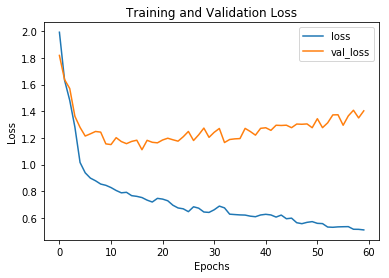

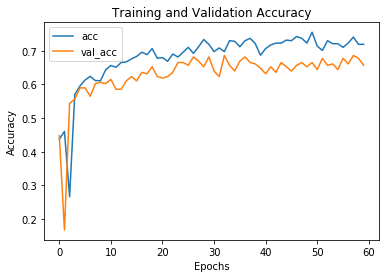

(120, 13)
120/120 [==============================] - 0s 74us/step
[INFO] Predition Total time: 0.000173199176788
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:InfoGain DataSetDuration:60s
('TEST LOSS, TEST ACCURACY:', [1.5686725974082947, 0.5583333373069763])
[INFO] Output directory output/Labels/CNN/InfoGain/120s/models must be empty
[INFO] Output directory output/Labels/CNN/InfoGain/120s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-120s-Layer2-85.arff
[INFO] Data loaded for info Gain
(413, 13)
[INFO] Y TRAIN Shape is ](413, 8)
[INFO] X TRAIN Shape is ](413, 13)
X TRAIN Shape is after Reshaping For CNN ](413, 13, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 13, 128)           512       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 13, 128)           

289/289 [==============================] - 0s 214us/step - loss: 0.6307 - acc: 0.7163 - val_loss: 1.2464 - val_acc: 0.6452

Epoch 00029: val_acc did not improve from 0.70968
Epoch 30/60
289/289 [==============================] - 0s 220us/step - loss: 0.6568 - acc: 0.7336 - val_loss: 1.1154 - val_acc: 0.6774

Epoch 00030: val_acc did not improve from 0.70968
Epoch 31/60
289/289 [==============================] - 0s 233us/step - loss: 0.6437 - acc: 0.7093 - val_loss: 1.1183 - val_acc: 0.6935

Epoch 00031: val_acc did not improve from 0.70968
Epoch 32/60
289/289 [==============================] - 0s 218us/step - loss: 0.6504 - acc: 0.7197 - val_loss: 1.1148 - val_acc: 0.6855

Epoch 00032: val_acc did not improve from 0.70968
Epoch 33/60
289/289 [==============================] - 0s 218us/step - loss: 0.6126 - acc: 0.7370 - val_loss: 1.1212 - val_acc: 0.6935

Epoch 00033: val_acc did not improve from 0.70968
Epoch 34/60
289/289 [==============================] - 0s 218us/step - loss: 0.598

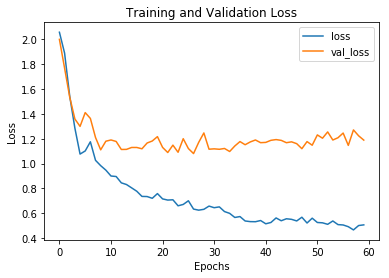

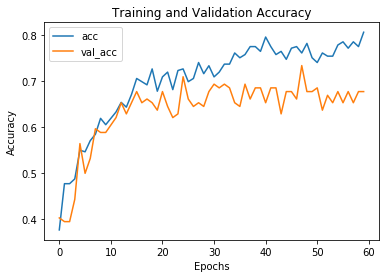

(73, 13)
73/73 [==============================] - 0s 94us/step
[INFO] Predition Total time: 0.000137197971344
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:InfoGain DataSetDuration:120s
('TEST LOSS, TEST ACCURACY:', [1.8405426952936879, 0.6986301373945524])
[INFO] Output directory output/Labels/CNN/Correlation/15s/models must be empty
[INFO] Output directory output/Labels/CNN/Correlation/15s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-15s-Layer2-85.arff
[INFO] Data loaded for Correlation
(2856, 14)
[INFO] Y TRAIN Shape is ](2856, 8)
[INFO] X TRAIN Shape is ](2856, 14)
X TRAIN Shape is after Reshaping For CNN ](2856, 14, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 14, 128)           512       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 14, 128)    

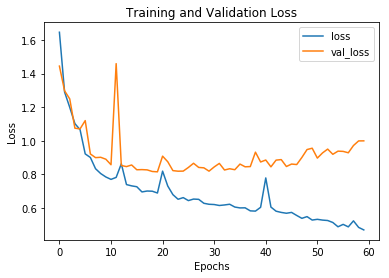

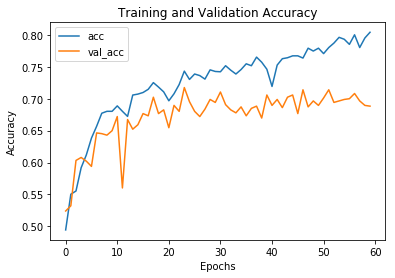

(504, 14)
504/504 [==============================] - 0s 66us/step
[INFO] Predition Total time: 0.000585333506266
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:Correlation DataSetDuration:15s
('TEST LOSS, TEST ACCURACY:', [1.5643472442078212, 0.5992063501524547])
[INFO] Output directory output/Labels/CNN/Correlation/30s/models must be empty
[INFO] Output directory output/Labels/CNN/Correlation/30s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-30s-Layer2-85.arff
[INFO] Data loaded for Correlation
(1532, 14)
[INFO] Y TRAIN Shape is ](1532, 8)
[INFO] X TRAIN Shape is ](1532, 14)
X TRAIN Shape is after Reshaping For CNN ](1532, 14, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 14, 128)           512       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 14, 128

1072/1072 [==============================] - 0s 226us/step - loss: 0.7584 - acc: 0.6856 - val_loss: 0.8774 - val_acc: 0.7000

Epoch 00027: val_acc improved from 0.68696 to 0.70000, saving model to output/Labels/CNN/Correlation/30s/logs/CNN_best.h5
Epoch 28/60
1072/1072 [==============================] - 0s 226us/step - loss: 0.7313 - acc: 0.7108 - val_loss: 0.9838 - val_acc: 0.6935

Epoch 00028: val_acc did not improve from 0.70000
Epoch 29/60
1072/1072 [==============================] - 0s 231us/step - loss: 0.7589 - acc: 0.6959 - val_loss: 0.9272 - val_acc: 0.6717

Epoch 00029: val_acc did not improve from 0.70000
Epoch 30/60
1072/1072 [==============================] - 0s 225us/step - loss: 0.9389 - acc: 0.6455 - val_loss: 0.9905 - val_acc: 0.6478

Epoch 00030: val_acc did not improve from 0.70000
Epoch 31/60
1072/1072 [==============================] - 0s 226us/step - loss: 0.8004 - acc: 0.6847 - val_loss: 0.9307 - val_acc: 0.7065

Epoch 00031: val_acc improved from 0.70000 to 0.70

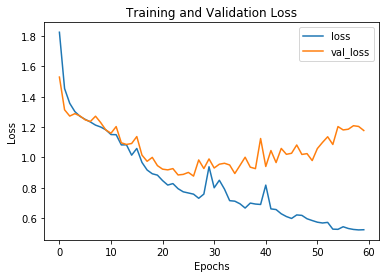

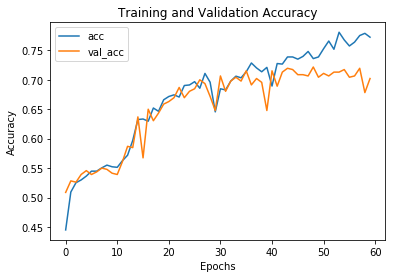

(271, 14)
271/271 [==============================] - 0s 74us/step
[INFO] Predition Total time: 0.000358847777049
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:Correlation DataSetDuration:30s
('TEST LOSS, TEST ACCURACY:', [1.029748399319244, 0.6789667907676133])
[INFO] Output directory output/Labels/CNN/Correlation/60s/models must be empty
[INFO] Output directory output/Labels/CNN/Correlation/60s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-60s-Layer2-85.arff
[INFO] Data loaded for Correlation
(795, 14)
[INFO] Y TRAIN Shape is ](795, 8)
[INFO] X TRAIN Shape is ](795, 14)
X TRAIN Shape is after Reshaping For CNN ](795, 14, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 14, 128)           512       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 14, 128)    

556/556 [==============================] - 0s 238us/step - loss: 1.0248 - acc: 0.6079 - val_loss: 1.3048 - val_acc: 0.5314

Epoch 00028: val_acc did not improve from 0.57322
Epoch 29/60
556/556 [==============================] - 0s 233us/step - loss: 1.0404 - acc: 0.5971 - val_loss: 1.1861 - val_acc: 0.5565

Epoch 00029: val_acc did not improve from 0.57322
Epoch 30/60
556/556 [==============================] - 0s 227us/step - loss: 1.0317 - acc: 0.5989 - val_loss: 1.2354 - val_acc: 0.5481

Epoch 00030: val_acc did not improve from 0.57322
Epoch 31/60
556/556 [==============================] - 0s 227us/step - loss: 0.9954 - acc: 0.5971 - val_loss: 1.2068 - val_acc: 0.5607

Epoch 00031: val_acc did not improve from 0.57322
Epoch 32/60
556/556 [==============================] - 0s 230us/step - loss: 0.9854 - acc: 0.5935 - val_loss: 1.2156 - val_acc: 0.5397

Epoch 00032: val_acc did not improve from 0.57322
Epoch 33/60
556/556 [==============================] - 0s 225us/step - loss: 0.973

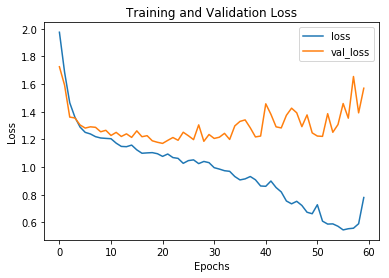

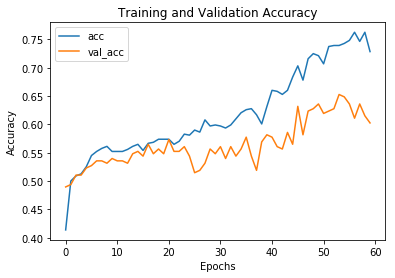

(120, 14)
120/120 [==============================] - 0s 83us/step
[INFO] Predition Total time: 0.000193317731222
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:Correlation DataSetDuration:60s
('TEST LOSS, TEST ACCURACY:', [1.0243403474489847, 0.6833333373069763])
[INFO] Output directory output/Labels/CNN/Correlation/120s/models must be empty
[INFO] Output directory output/Labels/CNN/Correlation/120s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-120s-Layer2-85.arff
[INFO] Data loaded for Correlation
(413, 14)
[INFO] Y TRAIN Shape is ](413, 8)
[INFO] X TRAIN Shape is ](413, 14)
X TRAIN Shape is after Reshaping For CNN ](413, 14, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 14, 128)           512       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 14, 128)

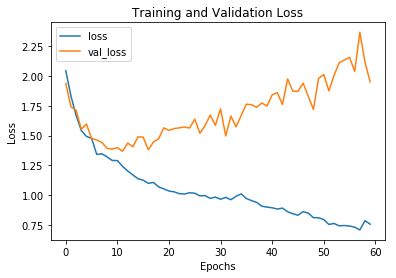

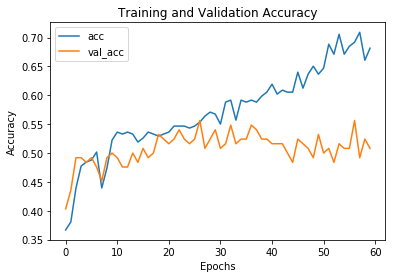

(73, 14)
73/73 [==============================] - 0s 91us/step
[INFO] Predition Total time: 0.000134134292603
[INFO ]TESTING RESULTS FOR Data:Labels Architecture:CNN Method:Correlation DataSetDuration:120s
('TEST LOSS, TEST ACCURACY:', [2.2391196995565337, 0.5068493152726187])


In [14]:
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
                log_file = os.path.join(log_dir, 'training.csv')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                cpt_last = os.path.join(log_dir, '{}_last.h5'.format(ARCHITECTURE))
                output_dirs = [OUTPUT_DIR,mdl_dir, log_dir, cpt_dir]
                output_dirs = [directory for directory in output_dirs if directory is not None]
                #Create Directories
                for directory in output_dirs:
                    if not os.path.isdir(directory):
                        os.makedirs(directory)
                    elif len(glob.glob(os.path.join(directory, '*.*'))) > 0:
                        print('[INFO] Output directory {} must be empty'.format(directory))
                
                #Get Training Data 
                x_train, y_train = getTrainData(DataSetDuration,DATASET_ID)
                print('[INFO] Y TRAIN Shape is ]{}'.format(y_train.shape))
                print('[INFO] X TRAIN Shape is ]{}'.format(x_train.shape))
                #Architectures = ['Dense','CNN']
                if ARCHITECTURE != 'Dense':
                    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1).astype( 'float32' )
                    model = cnnModel(x_train.shape[1] ,y_train.shape[1])
                    print('X TRAIN Shape is after Reshaping For CNN ]{}'.format(x_train.shape))
                else:
                     model = denseModel(x_train.shape[1] ,y_train.shape[1])
                model.summary()
                # Split Data
                x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.30, shuffle= True)                
                # serialize models to json
                model_train_json = model.to_json()
                with open(mdl_train_file, 'w') as file:
                    file.write(model_train_json)
                
                checkpoints = callbacks(log_file,cpt_best,cpt_last)
                Epochs = 40
                if DATASET_ID == 'Labels':
                    Epochs = 60 
                history = model.fit(x_train, y_train,
                     epochs=Epochs,
                     validation_data=(x_valid,y_valid),
                     shuffle=True,
                     callbacks=checkpoints,
                     batch_size= 64)
                plot(history,log_dir)
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                if ARCHITECTURE != 'Dense':
                    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype( 'float32' )
                t = time.time()
                results = model.evaluate(x_test, y_test)
                print('[INFO] Predition Total time: {}'.format( (time.time() - t)/60))
                print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)

In [16]:
Path = 'CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-15.arff'
#'CSV/Scenario-B/TimeBasedFeatures-120s-Layer2-15.arff'
trainraw_data = loadarff(Path)
dfTrain_data = pd.DataFrame(trainraw_data[0])

In [17]:
import numpy as np # lineardfTrain_data

In [18]:
dfTrain_data = dfTrain_data[InfoGain_Rank]
dfTrain_data = removeNanVlaues(dfTrain_data)
dfTrain_data.head(20)
#    dfTrain_dataValues = dfTrain_data.values

min_biat   min_fiat      max_biat      max_fiat  flowBytesPerSecond  \
0   2064514.0  2249885.0  2.541572e+05  2.154834e+05         3046.003386   
1   2315198.0  2349340.0  2.918597e+05  2.678515e+05         3556.683872   
2   5932194.0  5881392.0  3.418857e+05  2.845729e+05         2336.970049   
3        -1.0       -1.0  0.000000e+00  0.000000e+00         2323.347017   
4        -1.0       -1.0  0.000000e+00  0.000000e+00         1494.820274   
5        -1.0       -1.0  0.000000e+00  0.000000e+00         2798.727851   
6        -1.0       -1.0  0.000000e+00  0.000000e+00         1496.406883   
7        -1.0       -1.0  0.000000e+00  0.000000e+00         1487.606165   
8        -1.0       -1.0  0.000000e+00  0.000000e+00         2778.329034   
9        -1.0       -1.0  0.000000e+00  0.000000e+00         1497.683815   
10       -1.0       -1.0  0.000000e+00  0.000000e+00         1025.217032   
11       -1.0       -1.0  0.000000e+00  0.000000e+00         2810.065142   
12       -1.0       -1.0  0.000000e+00  0.000000e+00         2798.066790   
13       -1.0       -1.0  0.000000e+00  0.000000e+00         2328.431373   
14  2412833.0  2413234.0  2.412833e+06  2.413234e+06           91.313777   
15       -1.0       -1.0  0.000000e+00  0.000000e+00         1277.177141   
16       -1.0       -1.0  0.000000e+00  0.000000e+00         2304.457779   
17  1066808.0       -1.0  1.066808e+06  0.000000e+00          112.055480   
18       -1.0       -1.0  0.000000e+00  0.000000e+00         2316.669570   
19  2260166.0  2259214.0  2.260166e+06  2.259214e+06           97.064179   

     mean_flowiat  flowPktsPerSecond      mean_fiat  max_flowiat  \
0   116488.708333           8.656061  484527.921325    2064514.0   
1   138633.350000           7.393603  662553.265035    2297754.0   
2   154748.284211           6.530129  889248.028147    5881355.0   
3    57245.000000          34.937549       0.000000      57245.0   
4    57532.000000          34.763262       0.000000      57532.0   
5    55025.000000          36.347115       0.000000      55025.0   
6    57471.000000          34.800160       0.000000      57471.0   
7    57811.000000          34.595492       0.000000      57811.0   
8    55429.000000          36.082195       0.000000      55429.0   
9    57422.000000          34.829856       0.000000      57422.0   
10  181425.000000          11.023839       0.000000     181425.0   
11   54803.000000          36.494352       0.000000      54803.0   
12   55038.000000          36.338530       0.000000      55038.0   
13   57120.000000          35.014006       0.000000      57120.0   
14  861498.333333           1.547691       0.000000    2241572.0   
15   67336.000000          29.701794       0.000000      67336.0   
16   66827.000000          29.928023       0.000000      66827.0   
17  562221.500000           2.667988       0.000000    1066808.0   
18   57410.000000          34.837136       0.000000      57410.0   
19  810460.333333           1.645156       0.000000    2087999.0   

        mean_biat   std_flowiat  min_flowiat    duration  class1  
0   462592.986971  3.342602e+05          7.0  13978645.0  NONTOR  
1   667200.262669  4.681353e+05          6.0   5545334.0  NONTOR  
2   946533.667755  6.496466e+05          5.0  14701087.0  NONTOR  
3        0.000000  0.000000e+00      57245.0     57245.0  NONTOR  
4        0.000000  0.000000e+00      57532.0     57532.0  NONTOR  
5        0.000000  0.000000e+00      55025.0     55025.0  NONTOR  
6        0.000000  0.000000e+00      57471.0     57471.0  NONTOR  
7        0.000000  0.000000e+00      57811.0     57811.0  NONTOR  
8        0.000000  0.000000e+00      55429.0     55429.0  NONTOR  
9        0.000000  0.000000e+00      57422.0     57422.0  NONTOR  
10       0.000000  0.000000e+00     181425.0    181425.0  NONTOR  
11       0.000000  0.000000e+00      54803.0     54803.0  NONTOR  
12       0.000000  0.000000e+00      55038.0     55038.0  NONTOR  
13       0.000000  0.000000e+00      5712

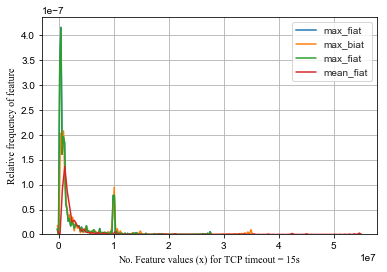

In [19]:
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
#from matplotlib import RcParams
#import matplotlib.pyplot as plt
csfont = {'fontname':"Times New Roman"}
sns.distplot(dfTrain_data['max_fiat'],label='max_fiat',axlabel='y',hist=False)
#sns.set_style("blackgrid",{'axes.grid':True,'ytick.major.size':0.1,'ytick.minor.size':0.5})
sns.set_style("white")
sns.distplot(dfTrain_data['max_biat'],label='max_biat',axlabel='y',hist=False)
sns.distplot(dfTrain_data['max_fiat'],label='max_fiat',axlabel='y',hist=False)
sns.distplot(dfTrain_data['mean_fiat'],label='mean_fiat',axlabel='x',hist=False)
#t_ax.set_ylabel('y')
#csfont = {'fontname':'Times New Roman'}
plt.ylabel('Relative frequency of feature',**csfont)
plt.xlabel('No. Feature values (x) for TCP timeout = 15s',**csfont)
#axes = plt.axes()

plt.grid(True)
plt.legend()
plt.show()
#pyplot.savefig('NonNormalized.eps')

In [20]:
dfTrain_data.describe()

min_biat      min_fiat      max_biat      max_fiat  \
count  3.311000e+03  3.311000e+03  3.311000e+03  3.311000e+03   
mean   2.420990e+06  2.684616e+06  9.818542e+05  1.021684e+06   
std    7.274868e+06  8.222391e+06  2.493977e+06  2.553369e+06   
min   -1.820000e+02 -1.700000e+02 -1.000000e+00 -1.000000e+00   
25%    2.150000e+01  1.320000e+02  1.332754e+04  1.768266e+04   
50%    9.142600e+04  1.070420e+05  9.600400e+04  1.104550e+05   
75%    3.011403e+06  3.051622e+06  5.481302e+05  5.817803e+05   
max    2.400015e+08  1.270509e+08  3.500000e+07  2.750000e+07   

       flowBytesPerSecond  mean_flowiat  flowPktsPerSecond     mean_fiat  \
count        3.311000e+03  3.311000e+03        3311.000000  3.311000e+03   
mean         4.427418e+05  3.886047e+05        1570.285956  6.859025e+05   
std          1.028327e+07  1.069151e+06       11320.621686  2.891966e+06   
min          0.000000e+00  0.000000e+00           0.000000  0.000000e+00   
25%          6.241793e+02  9.559992e+03           3.850259  8.866196e+02   
50%          4.870401e+03  5.219300e+04          20.355564  2.063707e+04   
75%          2.592103e+04  2.556554e+05         104.212261  4.442996e+05   
max          5.650000e+08  1.630000e+07      333333.333333  5.490000e+07   

        max_flowiat     mean_biat   std_flowiat   min_flowiat      duration  
count  3.311000e+03  3.311000e+03  3.311000e+03  3.311000e+03  3.311000e+03  
mean   3.369991e+06  5.423428e+05  8.572261e+05  3.475379e+04  1.016343e+07  
std    1.041913e+07  2.392919e+06  2.713381e+06  4.155909e+05  1.120147e+07  
min   -1.000000e+00  0.000000e+00  0.000000e+00 -4.890000e+02  0.000000e+00  
25%    5.528350e+04  8.770954e+02  6.432551e+03  3.000000e+00  8.231480e+05  
50%    3.317940e+05  2.241927e+04  4.395710e+04  1.400000e+01  1.295649e+07  
75%    4.160422e+06  3.919414e+05  6.236382e+05  7.650000e+01  1.497899e+07  
max    2.399525e+08  9.040000e+07  6.190000e+07  1.589248e+07  2.450951e+08

In [21]:
dfTrain_data

min_biat   min_fiat      max_biat      max_fiat  flowBytesPerSecond  \
0     2064514.0  2249885.0  2.541572e+05  2.154834e+05        3.046003e+03   
1     2315198.0  2349340.0  2.918597e+05  2.678515e+05        3.556684e+03   
2     5932194.0  5881392.0  3.418857e+05  2.845729e+05        2.336970e+03   
3          -1.0       -1.0  0.000000e+00  0.000000e+00        2.323347e+03   
4          -1.0       -1.0  0.000000e+00  0.000000e+00        1.494820e+03   
5          -1.0       -1.0  0.000000e+00  0.000000e+00        2.798728e+03   
6          -1.0       -1.0  0.000000e+00  0.000000e+00        1.496407e+03   
7          -1.0       -1.0  0.000000e+00  0.000000e+00        1.487606e+03   
8          -1.0       -1.0  0.000000e+00  0.000000e+00        2.778329e+03   
9          -1.0       -1.0  0.000000e+00  0.000000e+00        1.497684e+03   
10         -1.0       -1.0  0.000000e+00  0.000000e+00        1.025217e+03   
11         -1.0       -1.0  0.000000e+00  0.000000e+00        2.810065e+03   
12         -1.0       -1.0  0.000000e+00  0.000000e+00        2.798067e+03   
13         -1.0       -1.0  0.000000e+00  0.000000e+00        2.328431e+03   
14    2412833.0  2413234.0  2.412833e+06  2.413234e+06        9.131378e+01   
15         -1.0       -1.0  0.000000e+00  0.000000e+00        1.277177e+03   
16         -1.0       -1.0  0.000000e+00  0.000000e+00        2.304458e+03   
17    1066808.0       -1.0  1.066808e+06  0.000000e+00        1.120555e+02   
18         -1.0       -1.0  0.000000e+00  0.000000e+00        2.316670e+03   
19    2260166.0  2259214.0  2.260166e+06  2.259214e+06        9.706418e+01   
20         -1.0       -1.0  0.000000e+00  0.000000e+00        2.765407e+03   
21         -1.0       -1.0  0.000000e+00  0.000000e+00        2.312360e+03   
22         -1.0       -1.0  0.000000e+00  0.000000e+00        1.403509e+06   
23         -1.0       -1.0  0.000000e+00  0.000000e+00        2.320631e+03   
24         -1.0       -1.0  0.000000e+00  0.000000e+00        4.837684e+02   
25         -1.0       -1.0  0.000000e+00  0.000000e+00        2.718303e+03   
26         -1.0       -1.0  0.000000e+00  0.000000e+00        2.712032e+03   
27         -1.0       -1.0  0.000000e+00  0.000000e+00        4.980743e+02   
28         -1.0       -1.0  0.000000e+00  0.000000e+00        2.721858e+03   
29         -1.0       -1.0  0.000000e+00  0.000000e+00        2.750589e+03   
...         ...        ...           ...           ...                 ...   
3281       10.0      655.0  6.848200e+04  7.510600e+04        2.494841e+04   
3282       62.0        8.0  1.339710e+05  1.056930e+05        3.143979e+04   
3283       64.0       13.0  1.024660e+05  9.290300e+04        3.474091e+04   
3284      347.0       14.0  1.300080e+05  1.237890e+05        2.569454e+04   
3285      271.0      177.0  6.525300e+04  7.502500e+04        2.966955e+04   
3286       12.0      157.0  7.310100e+04  7.309300e+04        2.565686e+04   
3287      299.0       18.0  9.172400e+04  9.093100e+04        3.016845e+04   
3288       12.0       27.0  7.044100e+04  7.392900e+04        2.595857e+04   
3289       57.0       14.0  9.526900e+04  6.914400e+04        4.043041e+04   
3290      287.0      173.0  1.094020e+05  1.097440e+05        2.946567e+04   
3291      270.0       13.0  1.035910e+05  1.071490e+05        3.051088e+04   
3292       64.0       11.0  1.063750e+05  1.059620e+05        3.349323e+04   
3293       39.0        7.0  8.688800e+04  8.808300e+04        4.011414e+04   
3294       14.0       40.0  7.363700e+04  7.526900e+04        2.476138e+04   
3295        9.0       77.0  7.552500e+04  7.494600e+04        2.488884e+04   
3296       68.0        7.0  1.026100e+05  9.568200e+04        3.534157e+04   
3297       78.0      108.0  3.483660e+05  3.468560e+05        7.603610e+03   
3298       63.0        7.0  1.032230e+05  9.653500e+04        3.671823e+04   
3299      169.0       64.0  7.506200e+04  7.509600e+04        2.379870e+04   
3300       30.0      159.0  7

In [8]:
dfTrain_data.class1.unique()

array(['NONTOR', 'TOR'], dtype=object)

In [1]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(6,5))
csfont = {'fontname':"Times New Roman",'fontsize':12}
sns.set( style="whitegrid",palette="deep",font="Times New Roman", font_scale=1,color_codes=True,
        rc={"grid.linewidth": 1,'grid.color': '.8','grid.linestyle': '--', 'axes.edgecolor': '.2',
           'axes.spines.bottom': True,'ytick.direction': 'in','ytick.left': True,'ytick.right': False,
            'xtick.direction': 'in','xtick.bottom': True,})
sns.distplot(dfTrain_data['max_biat'],label='max_biat',axlabel='y',hist=False,
            kde_kws={"color": "b", "lw": 2,'linestyle':'--'})
sns.distplot(dfTrain_data['max_fiat'],label='max_fiat',axlabel='y',hist=False,
            kde_kws={"color": "y", "lw": 2,'linestyle':':'})
sns.distplot(dfTrain_data['mean_flowiat'],label='mean_flowiat',axlabel='y',hist=False,
            kde_kws={"color": "g", "lw": 2,'linestyle':'-.'})
ax =sns.distplot(dfTrain_data['mean_fiat'],label='mean_fiat',axlabel='x',hist=False,
            kde_kws={"color": "r", "lw": 2,'linestyle':'-'})
plt.ylabel('Relative frequency of feature',**csfont)
plt.xlabel('Feature values (x) for TCP timeout = 15s',**csfont)
plt.margins(y=0.1)
plt.grid(True)
plt.show()
fig = ax.get_figure()
fig.savefig('NonNormalized.eps')

NameError: name 'sns' is not defined

NameError: name 'ff' is not defined

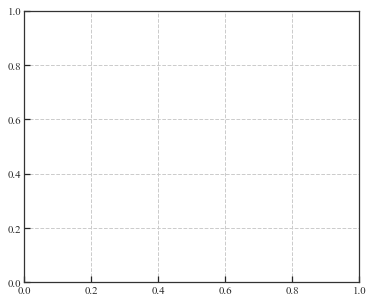

In [24]:
csfont = {'fontname':"Times New Roman",'fontsize':12}
plt.subplots(figsize=(6,5))
sns.set( style="whitegrid",palette="deep",font="Times New Roman", font_scale=1,color_codes=True,
        rc={"grid.linewidth": 1,'grid.color': '.8','grid.linestyle': '--', 'axes.edgecolor': '.2',
           'axes.spines.bottom': True,'ytick.direction': 'in','ytick.left': True,'ytick.right': False,
            'xtick.direction': 'in','xtick.bottom': True,})
sns.distplot(ff[2],label='max_biat',axlabel='y',hist=False,
            kde_kws={"color": "b", "lw": 2,'linestyle':'--'})
sns.distplot(ff[3],label='max_fiat',axlabel='y',hist=False,
            kde_kws={"color": "y", "lw": 2,'linestyle':':'})
sns.distplot(ff[5],label='mean_flowiat',axlabel='y',hist=False,
            kde_kws={"color": "g", "lw": 2,'linestyle':'-.'})
ax = sns.distplot(ff[7],label='mean_fiat',axlabel='x',hist=False,
            kde_kws={"color": "r", "lw": 2,'linestyle':'-'})

plt.ylabel('Probability density estimate (PDE(x))',**csfont)
plt.xlabel('Feature values (x) for TCP timeout = 15s',**csfont)
plt.margins(y=0.1)
pyplot.show()
fig = ax.get_figure()
fig.savefig('Normalized.eps')
fig = ax.get_figure()
fig.savefig('gender_salary.png')

In [26]:
dfTrain_dataValues = dfTrain_data.values
x_train = dfTrain_dataValues[:, :len(dfTrain_data.columns)-1]
x_train_Pr = dataPreProcessing(x_train)


(3311, 13)


In [27]:
ff=pd.DataFrame(x_train_Pr)
ss=pd.DataFrame(x_train)

In [119]:
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': '.15',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': '.8',
 'grid.linestyle': '-',
 'image.cmap': 'rocket',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': '.15',
 'xtick.bottom': True,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False}

NameError: name 'df' is not defined

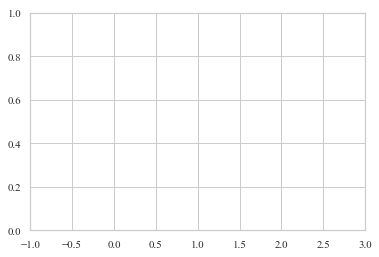

In [44]:
left, right = plt.xlim()
plt.xlim(right=3)  # adjust the right leaving left unchanged
plt.xlim(left=-1) 
g = sns.lmplot('X', 'Y', df, col='Z', sharex=False, sharey=False)
g.set(ylim=(0, None))

In [173]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.fantasy'] = 'Times New Roman'


In [172]:
from pprint import pprint
pprint(plt.rcParams)

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.format

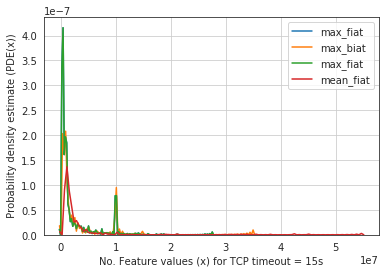

In [147]:
import matplotlib.pyplot as plt
import numpy as np

fonts1 = ["Times New Roman"]
#fonts2 = ["stix","stixsans","cm"]
#for font1,font2 in zip(fonts1,fonts2):
plt.rcParams["font.family"] = font1
#plt.rcParams["mathtext.fontset"] = font2
plt.rcParams["font.size"] = 10
sns.distplot(dfTrain_data['max_fiat'],label='max_fiat',axlabel='y',hist=False)
#sns.set_style("blackgrid",{'axes.grid':True,'ytick.major.size':0.1,'ytick.minor.size':0.5})
sns.set_style("white")
sns.distplot(dfTrain_data['max_biat'],label='max_biat',axlabel='y',hist=False)
sns.distplot(dfTrain_data['max_fiat'],label='max_fiat',axlabel='y',hist=False)
sns.distplot(dfTrain_data['mean_fiat'],label='mean_fiat',axlabel='x',hist=False)
#t_ax.set_ylabel('y')
#csfont = {'fontname':'Times New Roman'}
plt.ylabel(' Probability density estimate (PDE(x))',**csfont)
plt.xlabel('No. Feature values (x) for TCP timeout = 15s',**csfont)
#axes = plt.axes()
pyplot.savefig('NonNormalized.eps')
plt.grid(True)
plt.legend()
plt.show()

    ###  Non Normalized 



In [68]:
dfTrain_dataValues = dfTrain_data.values
x_train = dfTrain_dataValues[:, :len(dfTrain_data.columns)-1]

In [69]:
x_train

array([[13978645.0, 17.0, 7.0, ..., 1533121.8, 2064514.0, 421832.929403],
       [5545334.0, 30.0, 6.0, ..., 2138028.5, 2297754.0, 225885.968355],
       [14701087.0, 20.0, 5.0, ..., 3043251.333333, 5881355.0,
        2479421.916591],
       ...,
       [14979149.0, 14955242.0, 14979149.0, ..., 0.0, -1.0, 0.0],
       [14981021.0, 14907075.0, 14981021.0, ..., 5522154.0, 5522154.0,
        0.0],
       [14990545.0, 14990317.0, 14990345.0, ..., 0.0, -1.0, 0.0]],
      dtype=object)

In [70]:
x_train_Pr = dataPreProcessing(x_train)
x_train_Pr

(3311, 23)


array([[ 0.34065069, -0.48817824, -0.49077006, ..., -0.13620857,
        -0.11224841, -0.00752233],
       [-0.41233873, -0.48817578, -0.49077025, ..., -0.07292184,
        -0.08994075, -0.06537561],
       [ 0.40515575, -0.48817767, -0.49077043, ...,  0.02178466,
         0.25280381,  0.59998019],
       ...,
       [ 0.42998321,  2.33534772,  2.32676824, ..., -0.2966073 ,
        -0.30970379, -0.13206837],
       [ 0.43015036,  2.32625386,  2.32712036, ...,  0.28113315,
         0.21844893, -0.13206837],
       [ 0.43100073,  2.34196984,  2.32887418, ..., -0.2966073 ,
        -0.30970379, -0.13206837]])

In [75]:
ff=pd.DataFrame(x_train_Pr)
ss=pd.DataFrame(x_train)

In [79]:
ff


0         1         2         3         4         5         6   \
0     0.340651 -0.488178 -0.490770 -0.052880 -0.049008 -0.315788 -0.291826   
1    -0.412339 -0.488176 -0.490770 -0.040782 -0.014544 -0.295275 -0.276706   
2     0.405156 -0.488178 -0.490770  0.388848  0.482721 -0.288725 -0.256644   
3    -0.902357 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
4    -0.902331 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
5    -0.902555 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
6    -0.902336 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
7    -0.902306 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
8    -0.902519 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
9    -0.902341 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
10   -0.891269 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
11   -0.902575 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
12   -0.902554 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
13   -0.902368 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
14   -0.676705 -0.032566 -0.036924 -0.033010 -0.001121  0.545068  0.573861   
15   -0.901456 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
16   -0.901501 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
17   -0.807069 -0.488182 -0.290108 -0.326550 -0.186173 -0.400192  0.034069   
18   -0.902342 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
19   -0.690376 -0.061645 -0.065640 -0.051745 -0.022110  0.484739  0.512637   
20   -0.902496 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
21   -0.902332 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
22   -0.907463 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
23   -0.902351 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
24   -0.891595 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
25   -0.902409 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
26   -0.902398 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
27   -0.892051 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
28   -0.902416 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
29   -0.902469 -0.488182 -0.490772 -0.326550 -0.332839 -0.400192 -0.393750   
...        ...       ...       ...       ...       ...       ...       ...   
3281  0.430674  2.341278  2.328182 -0.326470 -0.332837 -0.370773 -0.366287   
3282  0.430775  2.341489  2.328411 -0.326549 -0.332830 -0.358792 -0.340024   
3283  0.429977  2.339809  2.326717 -0.326548 -0.332830 -0.363802 -0.352658   
3284  0.430166  2.340202  2.327120 -0.326548 -0.332791 -0.351704 -0.341613   
3285  0.428585  2.336904  2.323330 -0.326528 -0.332801 -0.370805 -0.367581   
3286  0.430512  2.340937  2.327845 -0.326531 -0.332837 -0.371562 -0.364434   
3287  0.431508  2.343039  2.329938 -0.326548 -0.332797 -0.364575 -0.356966   
3288  0.430798  2.335658  2.328484 -0.326547 -0.332837 -0.371234 -0.365501   
3289  0.431825  2.343720  2.330609 -0.326548 -0.332831 -0.373109 -0.355544   
3290  0.430851  2.341652  2.328556 -0.326529 -0.332799 -0.357206 -0.349877   
3291  0.430027  2.339902  2.326682 -0.326548 -0.332801 -0.358222 -0.352207   
3292  0.430215  2.340311  2.327220 -0.326549 -0.332830 -0.358687 -0.351090   
3293  0.431655  2.343204  2.329438 -0.326549 -0.332833 -0.365690 -0.358905   
3294  0.431194  2.342387  2.329273 -0.326545 -0.332836 -0.370710 -0.364219   
3295  0.428664  2.337027  2.323949 -0.326541 -0.332837 -0.370836 -0.363462   
3296  0.430148  2.340175  2.327072 -0.326549 -0.332829 -0.362714 -0.352600   
3297 -0.845807 -0.358068 -0.361248 -0.326537 -0.332828 -0.264329 -0.254046   
3298  0.430655  2.341246  2.328134 -0.326549 -0.332830 -0.362380 -0.352355   
3299  0.430841  2.337118  2.328575 -0.326542 -0.332815 -0.370777 -0.363648   
3300  0.431745  2.341882  2.330480

In [72]:
#fig = pyplot.figure(figsize=(8,6))
sns.set_style("whitegrid",{'axes.grid':True,'ytick.major.size':0.1,'ytick.minor.size':0.5})
sns.distplot(x_train_Pr['max_biat'],label='max_biat',axlabel='y',hist=False)
sns.distplot(x_train_Pr['max_fiat'],label='max_fiat',axlabel='y',hist=False)
sns.distplot(x_train_Pr['mean_flowiat'],label='mean_flowiat',hist=False)
sns.distplot(x_train_Pr['mean_fiat'],label='mean_fiat',axlabel='Feature x ',hist=False)
pyplot.legend()
pyplot.savefig('Normalized.eps')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

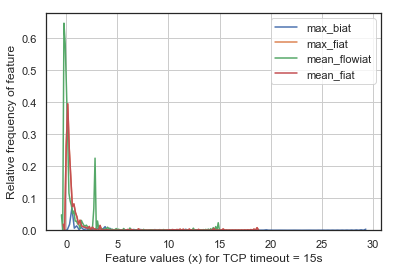

In [29]:
import matplotlib.pyplot as plt
#sns.distplot(dfTrain_data['max_fiat'],label='max_fiat',axlabel='y',hist=False)
#sns.set_style("blackgrid",{'axes.grid':True,'ytick.major.size':0.1,'ytick.minor.size':0.5})
sns.set_style("white")
sns.distplot(ff[6],label='max_biat',axlabel='y',hist=False)
sns.distplot(ff[7],label='max_fiat',axlabel='y',hist=False)
sns.distplot(ff[5],label='mean_flowiat',hist=False)
sns.distplot(ff[7],label='mean_fiat',axlabel='x',hist=False)
#t_ax.set_ylabel('y')
plt.ylabel('Relative frequency of feature')
plt.xlabel('Feature values (x) for TCP timeout = 15s')
#axes = plt.axes()
plt.grid(True)
pyplot.legend()
pyplot.savefig('Normalized.eps')
#NORMALIZED

In [14]:
ff


NameError: name 'ff' is not defined

In [37]:
f = open("/home/tahira/anaconda2/envs/tensorflow/bin/Traffic_classification/op1", "a")
f.write(str(ff))
f.close()

In [52]:
ss


0         1         2         3         4         5         6   \
0   -0.060216 -0.060268 -0.649763 -0.649879  0.305394 -0.195958  0.306441   
1   -0.060215 -0.060259 -0.686283 -0.686409 -0.425161 -0.191183 -0.342431   
2   -0.060216 -0.060268 -0.667506 -0.667782  6.172038 -0.197759  6.397383   
3   -0.060216 -0.060268  0.006846  0.003992 -0.087332 -0.194043 -0.140252   
4   -0.060216 -0.060268 -0.579953 -0.579868  1.442437 -0.197118  1.484281   
5   -0.060216 -0.060268  0.894099  0.893852 -0.365396 -0.188662 -0.418364   
6   -0.060216 -0.060268  0.861881  0.858933  1.678868 -0.197206  1.709779   
7   -0.060216 -0.060268 -0.619541 -0.619660  0.183520 -0.195624  0.177711   
8   -0.060216 -0.060267 -0.682333 -0.682745 -0.374658 -0.192905 -0.247690   
9   -0.055810 -0.060227  0.816654  0.816365 -0.552818  0.658811 -0.622445   
10  -0.060210 -0.060267 -0.680153 -0.681377 -0.445282 -0.189378 -0.401289   
11  -0.060199 -0.060268 -0.679863 -0.679998 -0.429653 -0.190553 -0.366209   
12  -0.060207 -0.060267 -0.675177 -0.672757 -0.428782 -0.190510 -0.367675   
13  -0.060216 -0.060268 -0.649374 -0.652167  0.301037 -0.195947  0.301651   
14  -0.060216 -0.060268  0.746050  0.745806 -0.239103 -0.191873 -0.310809   
15  -0.060237 -0.060271 -0.638513 -0.638569  1.136426 -0.196826  0.974682   
16  -0.060206 -0.060267 -0.680085 -0.681240 -0.437782 -0.190121 -0.380300   
17  -0.060216 -0.060268 -0.073302 -0.073471 -0.068716 -0.194251 -0.113562   
18  -0.058475 -0.058842 -0.690944 -0.691186  0.080951 -0.196513  1.070153   
19  -0.060216 -0.060268  0.783914  0.781115 -0.290645 -0.191182 -0.342477   
20  -0.060212 -0.060263  0.176336  0.176164 -0.535855 -0.140314 -0.591195   
21  -0.060215 -0.060267 -0.662929 -0.663006 -0.359674 -0.192726 -0.260425   
22  -0.060216 -0.060268 -0.500299 -0.500428  1.013828 -0.196750  0.880776   
23  -0.060216 -0.060268 -0.667345 -0.667443  0.669011 -0.196565  0.691185   
24  -0.060214 -0.060267 -0.682893 -0.683673 -0.355894 -0.193183 -0.226092   
25  -0.060215 -0.060263  1.200228  1.199930 -0.550188  0.146837 -0.619097   
26  -0.060215 -0.060261 -0.682230 -0.682383 -0.387279 -0.191861 -0.311414   
27  -0.060216 -0.060268 -0.622221 -0.622347  5.833913 -0.197743  6.004788   
28  -0.060216 -0.060268 -0.662312 -0.661641  4.170681 -0.197642  4.302699   
29  -0.060213 -0.060256 -0.683175 -0.683286 -0.436242 -0.190761 -0.358827   
..        ...       ...       ...       ...       ...       ...       ...   
259 -0.060216 -0.060268  1.702446  1.702107 -0.190561 -0.192545 -0.272433   
260 -0.060174 -0.060266 -0.684742 -0.684856 -0.399916 -0.192887 -0.248969   
261 -0.060157 -0.060187  0.326633  0.326227 -0.548987 -0.027671 -0.613283   
262 -0.060243 -0.060285 -0.667811 -0.669190  1.671679 -0.197120  1.488612   
263 -0.060216 -0.060269  1.201046  1.200758  0.671047 -0.196378  0.542792   
264 -0.060216 -0.060268  0.282739  0.282608  0.950136 -0.196706  0.830384   
265 -0.060216 -0.060268 -0.068388 -0.071359  0.071492 -0.195060  0.025388   
266 -0.060214 -0.060257 -0.682851 -0.681977 -0.389540 -0.191807 -0.314174   
267 -0.060208 -0.060268 -0.679962 -0.680086 -0.433831 -0.189931 -0.386043   
268 -0.060191 -0.060256 -0.042391 -0.042586 -0.540721 -0.131966 -0.595432   
269 -0.060213 -0.060265 -0.684457 -0.683736 -0.412218 -0.191665 -0.321093   
270 -0.006367 -0.006531  3.462182  3.461730 -0.553752  3.616346 -0.624162   
271 -0.060213 -0.060263  0.174173  0.176699 -0.534860 -0.143878 -0.588993   
272 -0.060216 -0.060268  1.164117  1.161251 -0.273633 -0.191017 -0.349122   
273 -0.060191 -0.060267 -0.680718 -0.681813 -0.434581 -0.189942 -0.385729   
274 -0.060150 -0.060186  2.173026  2.175309 -0.553224  1.180808 -0.623300   
275 -0.060199 -0.060223  0.549745  0.549551 -0.551403  0.170642 -0.619459   
276 -0.059904 -0.060218  0.942999  0.940089 -0.552231  0.258545 -0.620394   
277 -0.060216 -0.060268  0.332011  0.334338  0.534389 -0.196147  0.400085   
278 -0.060214 -0.060267 -0.682735 -0.683420 -0.376491 -0.192854 -0.251403   
279 -0.

In [45]:
export_csv = ff.to_csv (r'C:\home\tahira\anaconda2\envs\tensorflow\bin\Traffic_classification\op.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path



In [50]:
df = pd.DataFrame(ff)
df.to_csv('results-xtrain_Pr.csv', index=False, header=False)

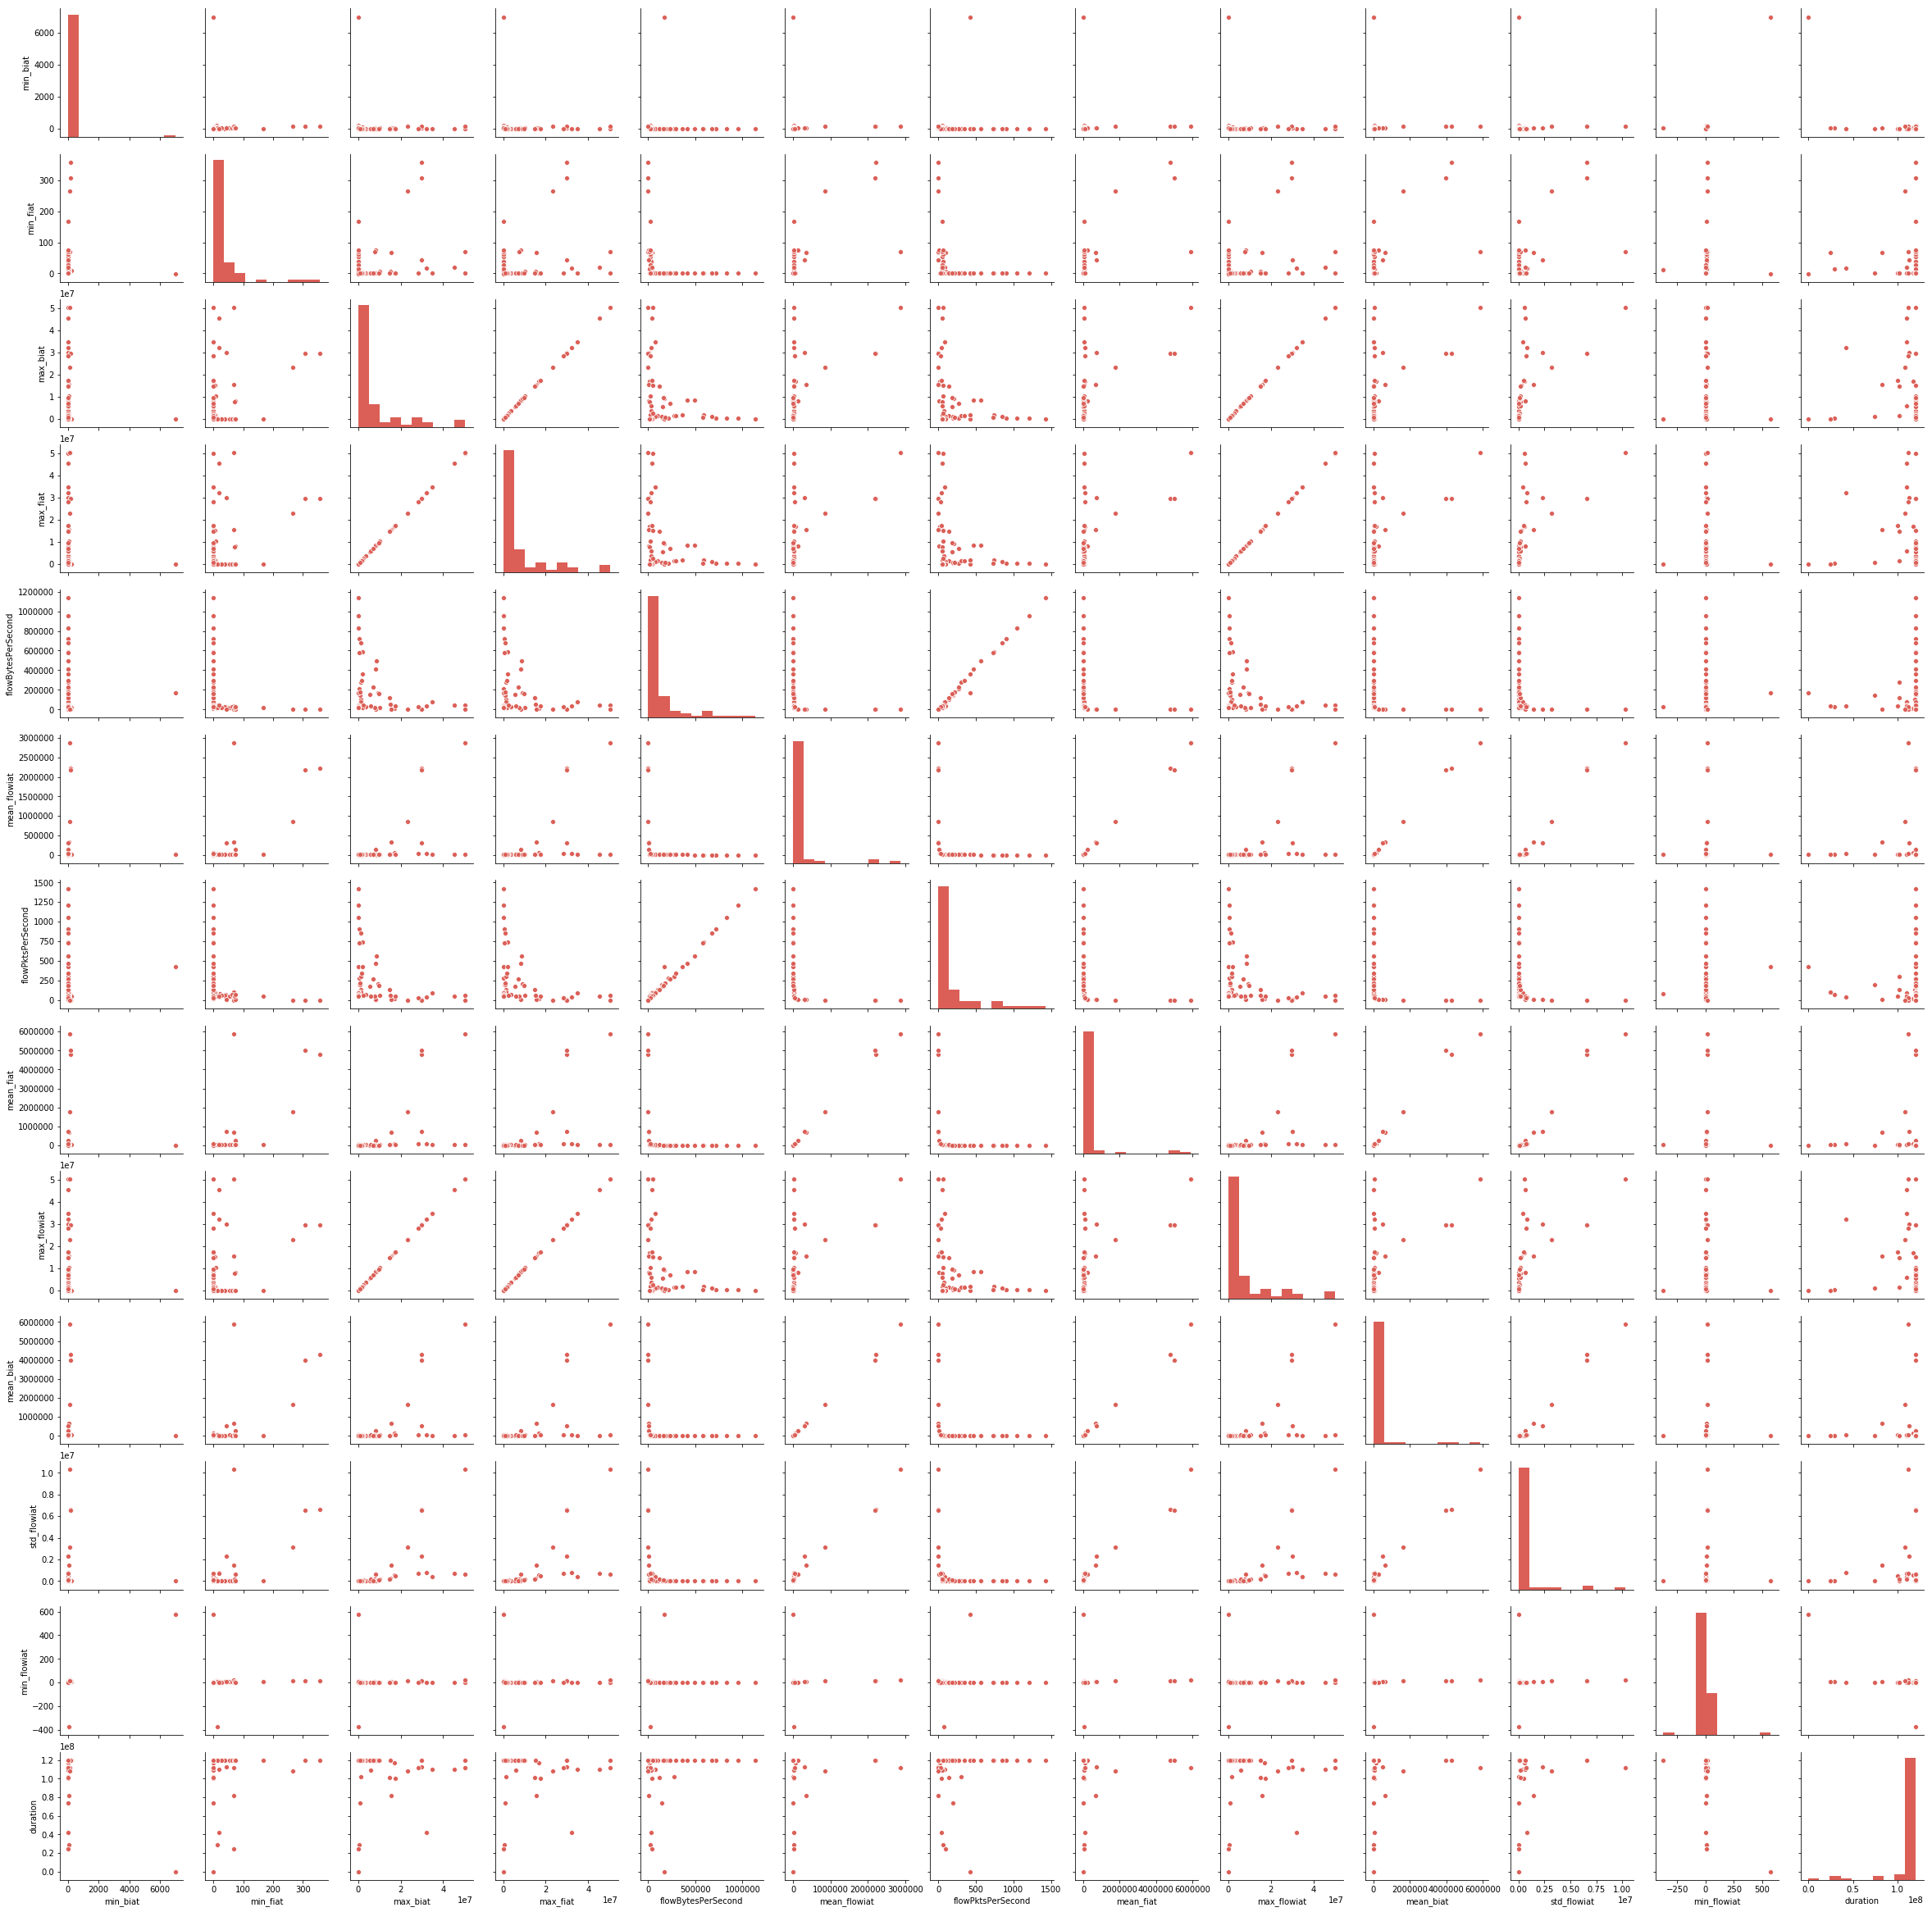

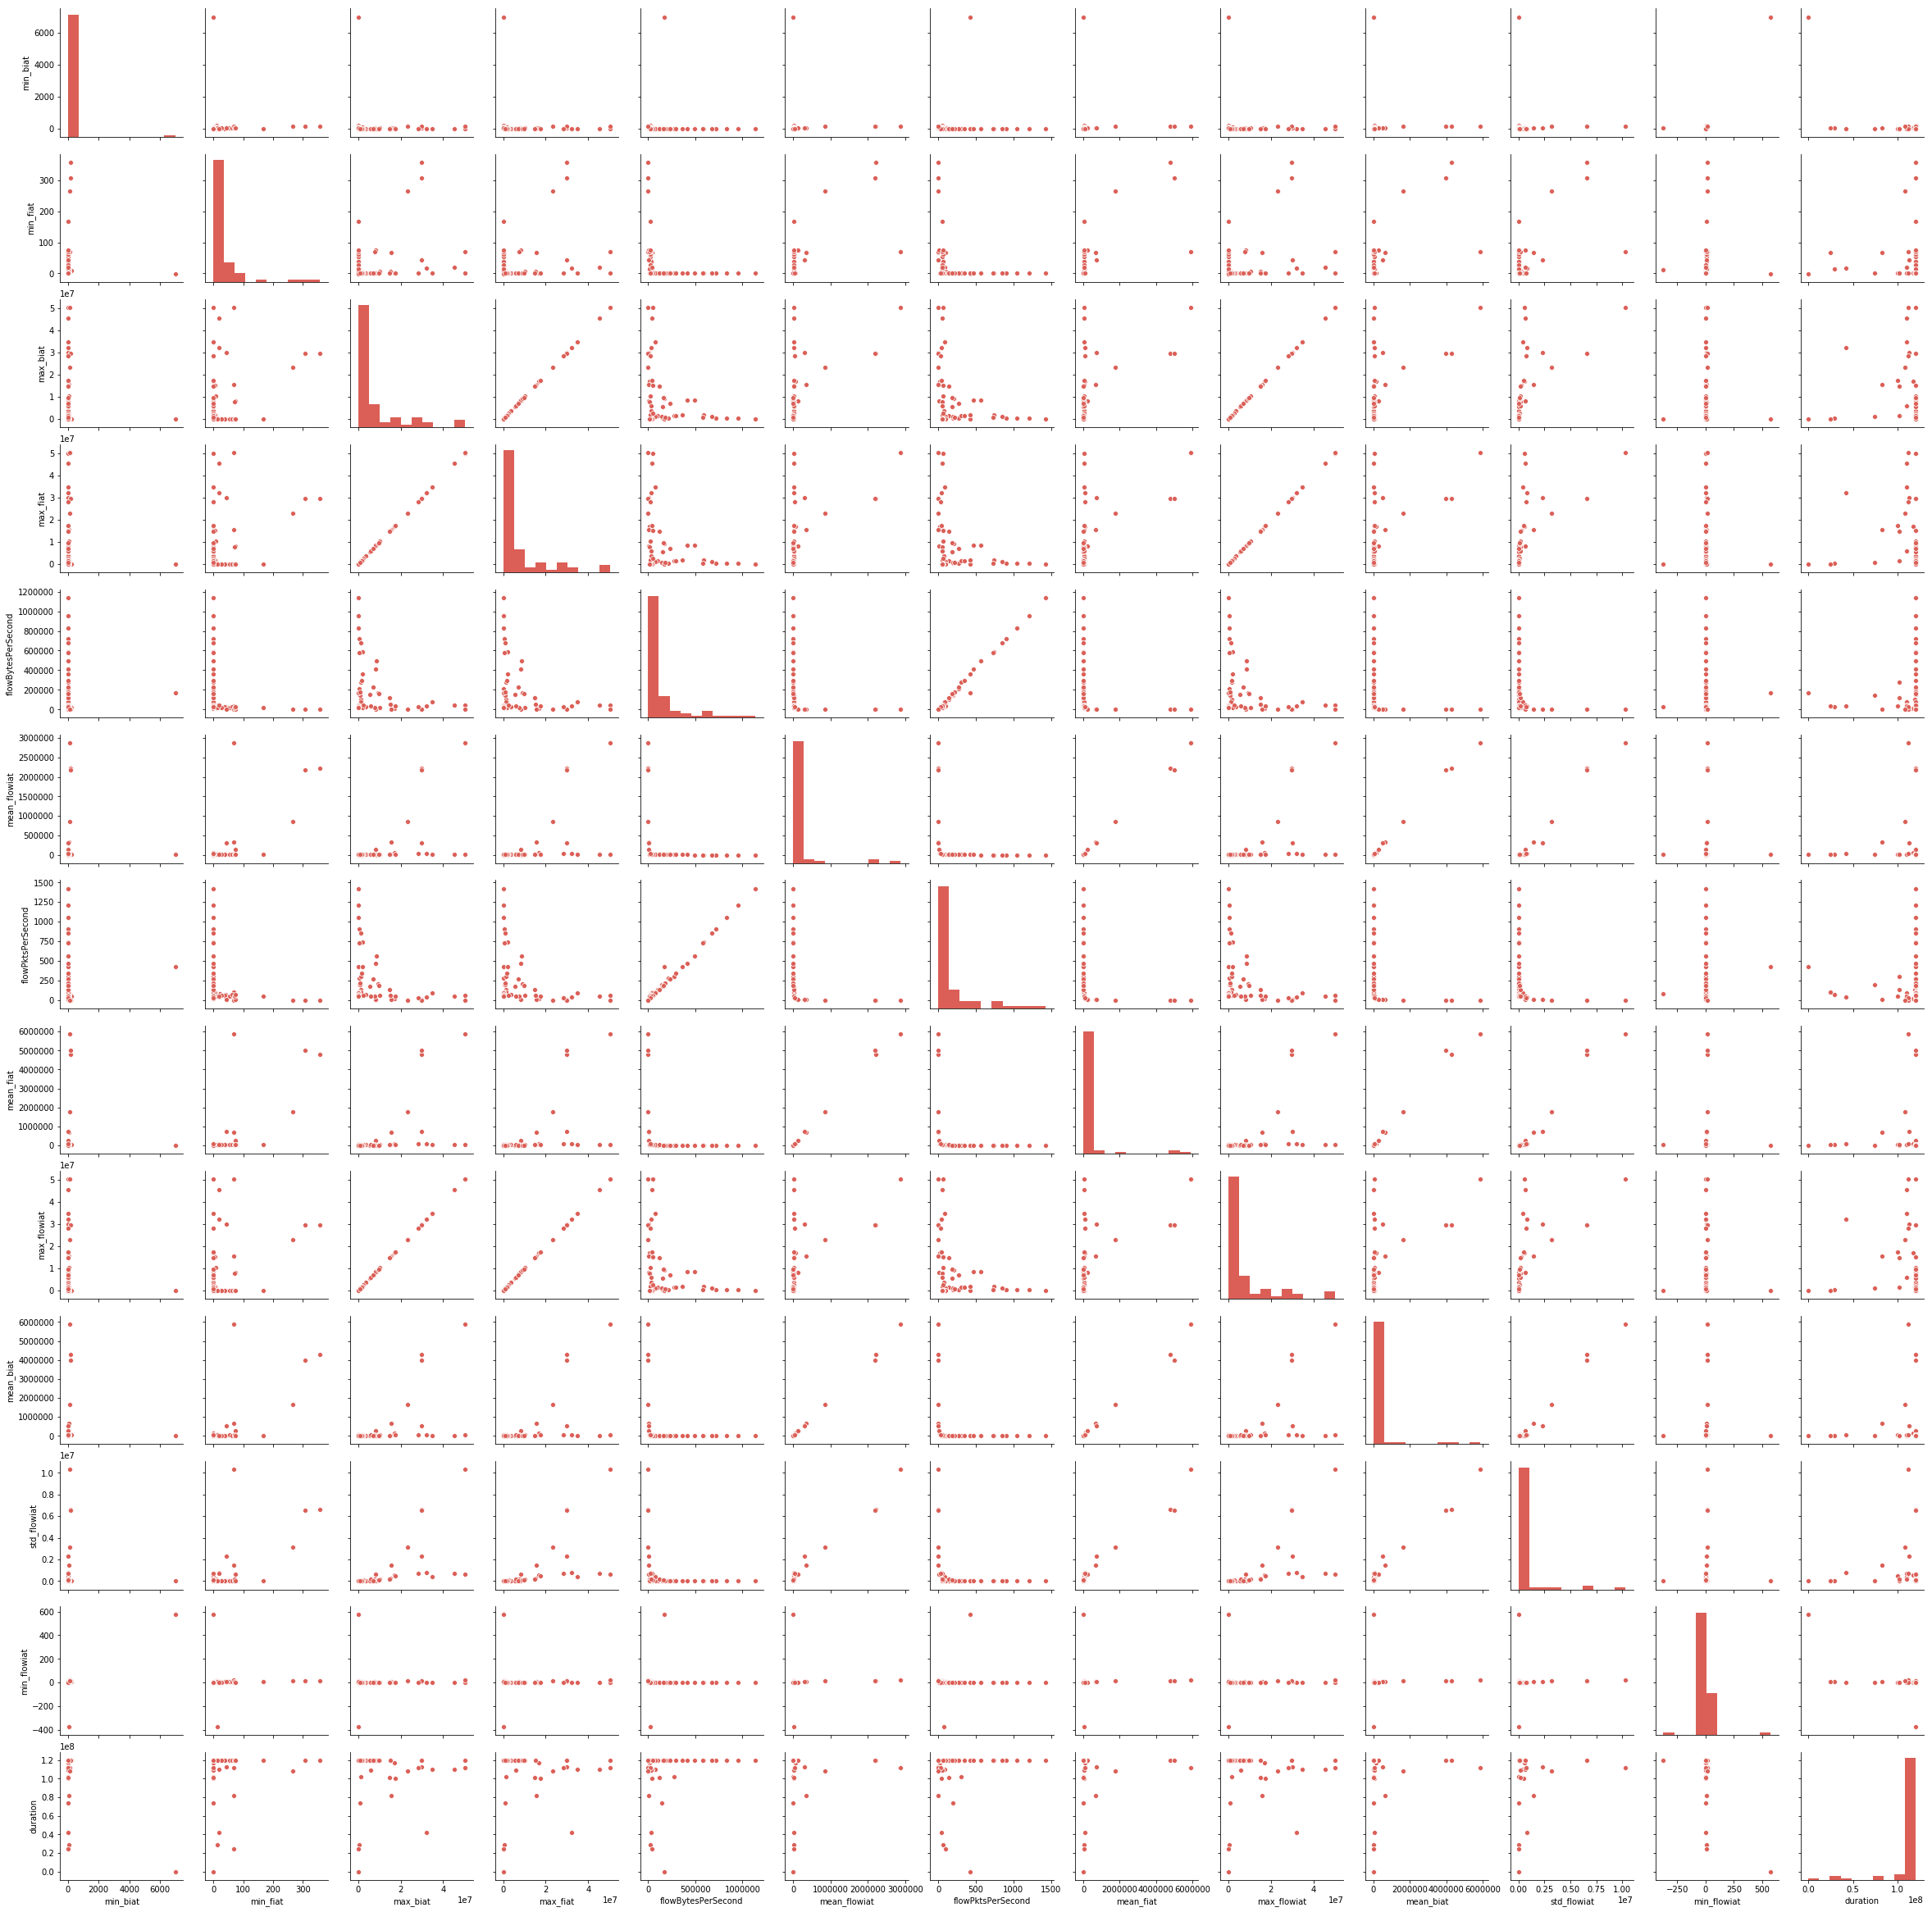

In [197]:
#g=sns.pairplot(dfTrain_data)
sns.pairplot(dfTrain_data)

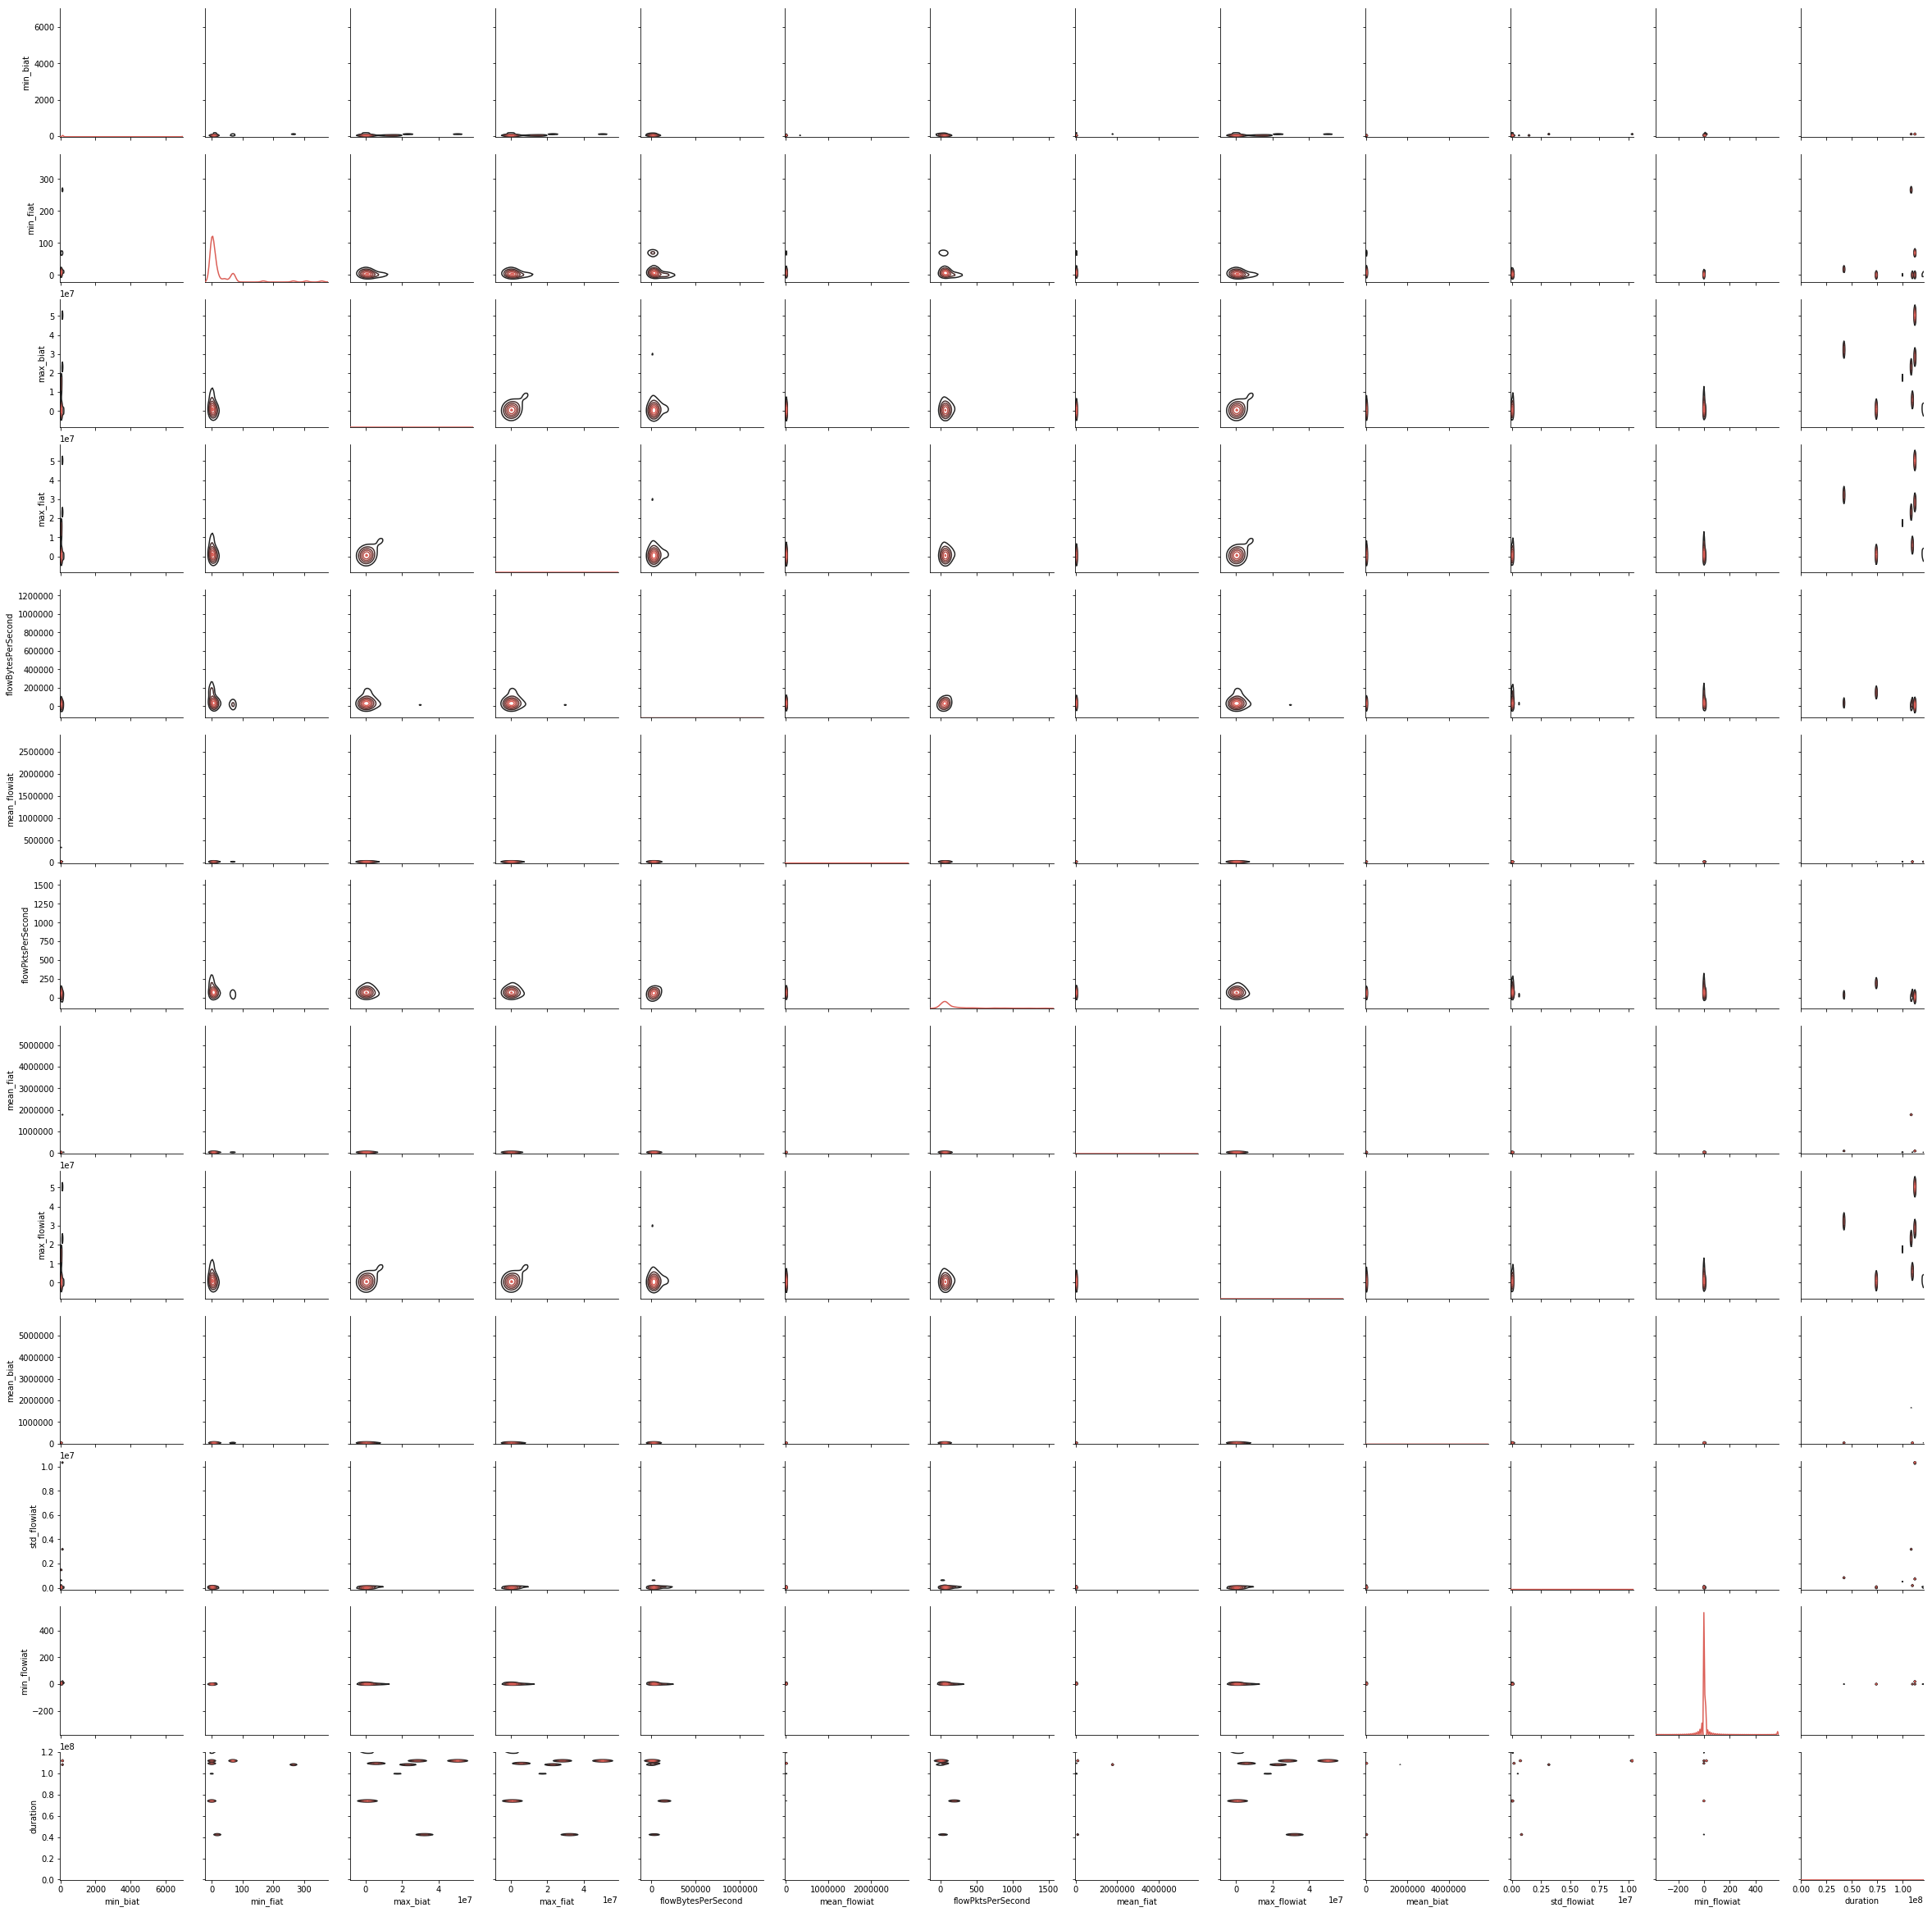

In [201]:
g = sns.PairGrid(dfTrain_data)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);


In [280]:
#sns.distplot(dfTrain_data['min_fiat'])
#sns.kdeplot(dfTrain_data['min_fiat'], color='blue')
from KDEpy import FFTKDE
from scipy.stats import norm
f, axes = plt.subplots(2, 3, figsize=(10, 10), sharex=True)
sns.kdeplot(dfTrain_data['min_fiat'],ax=axes[0, 0],bw='silverman')#,shade='True',bw='silverman',kernel='epa',color='red')
sns.kdeplot(dfTrain_data['max_fiat'],ax=axes[0, 1], kernel='gau', bw='ISJ')
sns.distplot(dfTrain_data['min_biat'],ax=axes[0,2])
sns.distplot(dfTrain_data['max_biat'],ax=axes[1,0])
sns.distplot(dfTrain_data['mean_biat'],ax=axes[1,1])
sns.distplot(dfTrain_data['mean_fiat'],ax=axes[1,2])

#,shade='True',bw='silverman',kernel='epa',color='blue')

ImportError: No module named KDEpy

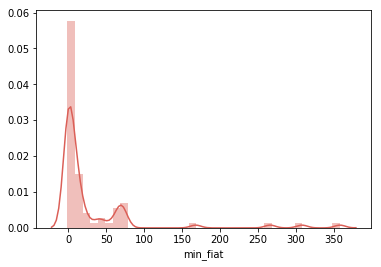

In [157]:
sns.distplot(dfTrain_data['min_fiat'])

In [34]:
dfTrain_dataValues = dfTrain_data.values

In [128]:
x_train = dfTrain_dataValues[:, :len(dfTrain_data.columns)-1]

In [149]:
c=x_train
x_train

array([[30.0, 0.0, 16927920.0, 16927994.0, 15055.534868, 49791.060221,
        20.092444, 80948.874309, 16927606.0, 129160.968097,
        598378.641039, 0.0, 117407320.0],
       [40.0, 68.0, 15657763.0, 15657759.0, 1387.446126, 335386.436735,
        2.993805, 684739.333333, 15657718.0, 662655.201613,
        1469556.981669, 10.0, 82169677.0],
       [42.0, 7.0, 10344145.0, 10344203.0, 22313.868328, 16276.464387,
        61.446739, 29652.388285, 10343921.0, 36093.150421, 157257.544332,
        0.0, 119973819.0],
       [74.0, 9.0, 130008.0, 128336.0, 27048.37761, 12722.708302,
        78.607951, 23070.111709, 127985.0, 28372.574131, 15911.294743,
        0.0, 119987862.0],
       [106.0, 11.0, 188374.0, 186829.0, 28614.590286, 11950.987551,
        83.683427, 21777.912688, 186829.0, 26484.190245, 14268.23993,
        0.0, 119999866.0],
       [92.0, 12.0, 133446.0, 133441.0, 28384.394243, 12056.754522,
        82.949394, 21959.842423, 133223.0, 26741.388901, 14827.77551,
        9.0,

In [132]:
x_train_Pr = dataPreProcessing(x_train)
x_train_Pr

(73, 13)


array([[-1.10836787e-01, -4.50759248e-01,  7.62817235e-01,
         7.63641518e-01, -5.40750148e-01, -1.69056619e-01,
        -6.03926737e-01, -1.94017745e-01,  7.63807874e-01,
        -1.34653713e-01,  4.90125432e-02, -7.34223050e-02,
         2.43950977e-01],
       [-9.85084535e-02,  5.87074196e-01,  6.60802501e-01,
         6.61551204e-01, -5.98230020e-01,  4.12905200e-01,
        -6.62835249e-01,  3.79158295e-01,  6.61761024e-01,
         4.19661654e-01,  5.83351372e-01,  5.15154168e-02,
        -1.29571810e+00],
       [-9.60427867e-02, -3.43923452e-01,  2.34030592e-01,
         2.34494319e-01, -5.10225904e-01, -2.37349794e-01,
        -4.61452240e-01, -2.42713309e-01,  2.34749942e-01,
        -2.31353767e-01, -2.21549888e-01, -7.34223050e-02,
         3.56091257e-01],
       [-5.65921186e-02, -3.13398939e-01, -5.86334504e-01,
        -5.86567196e-01, -4.90315367e-01, -2.44591334e-01,
        -4.02328150e-01, -2.48961840e-01, -5.86191821e-01,
        -2.39375661e-01, -3.08244869e

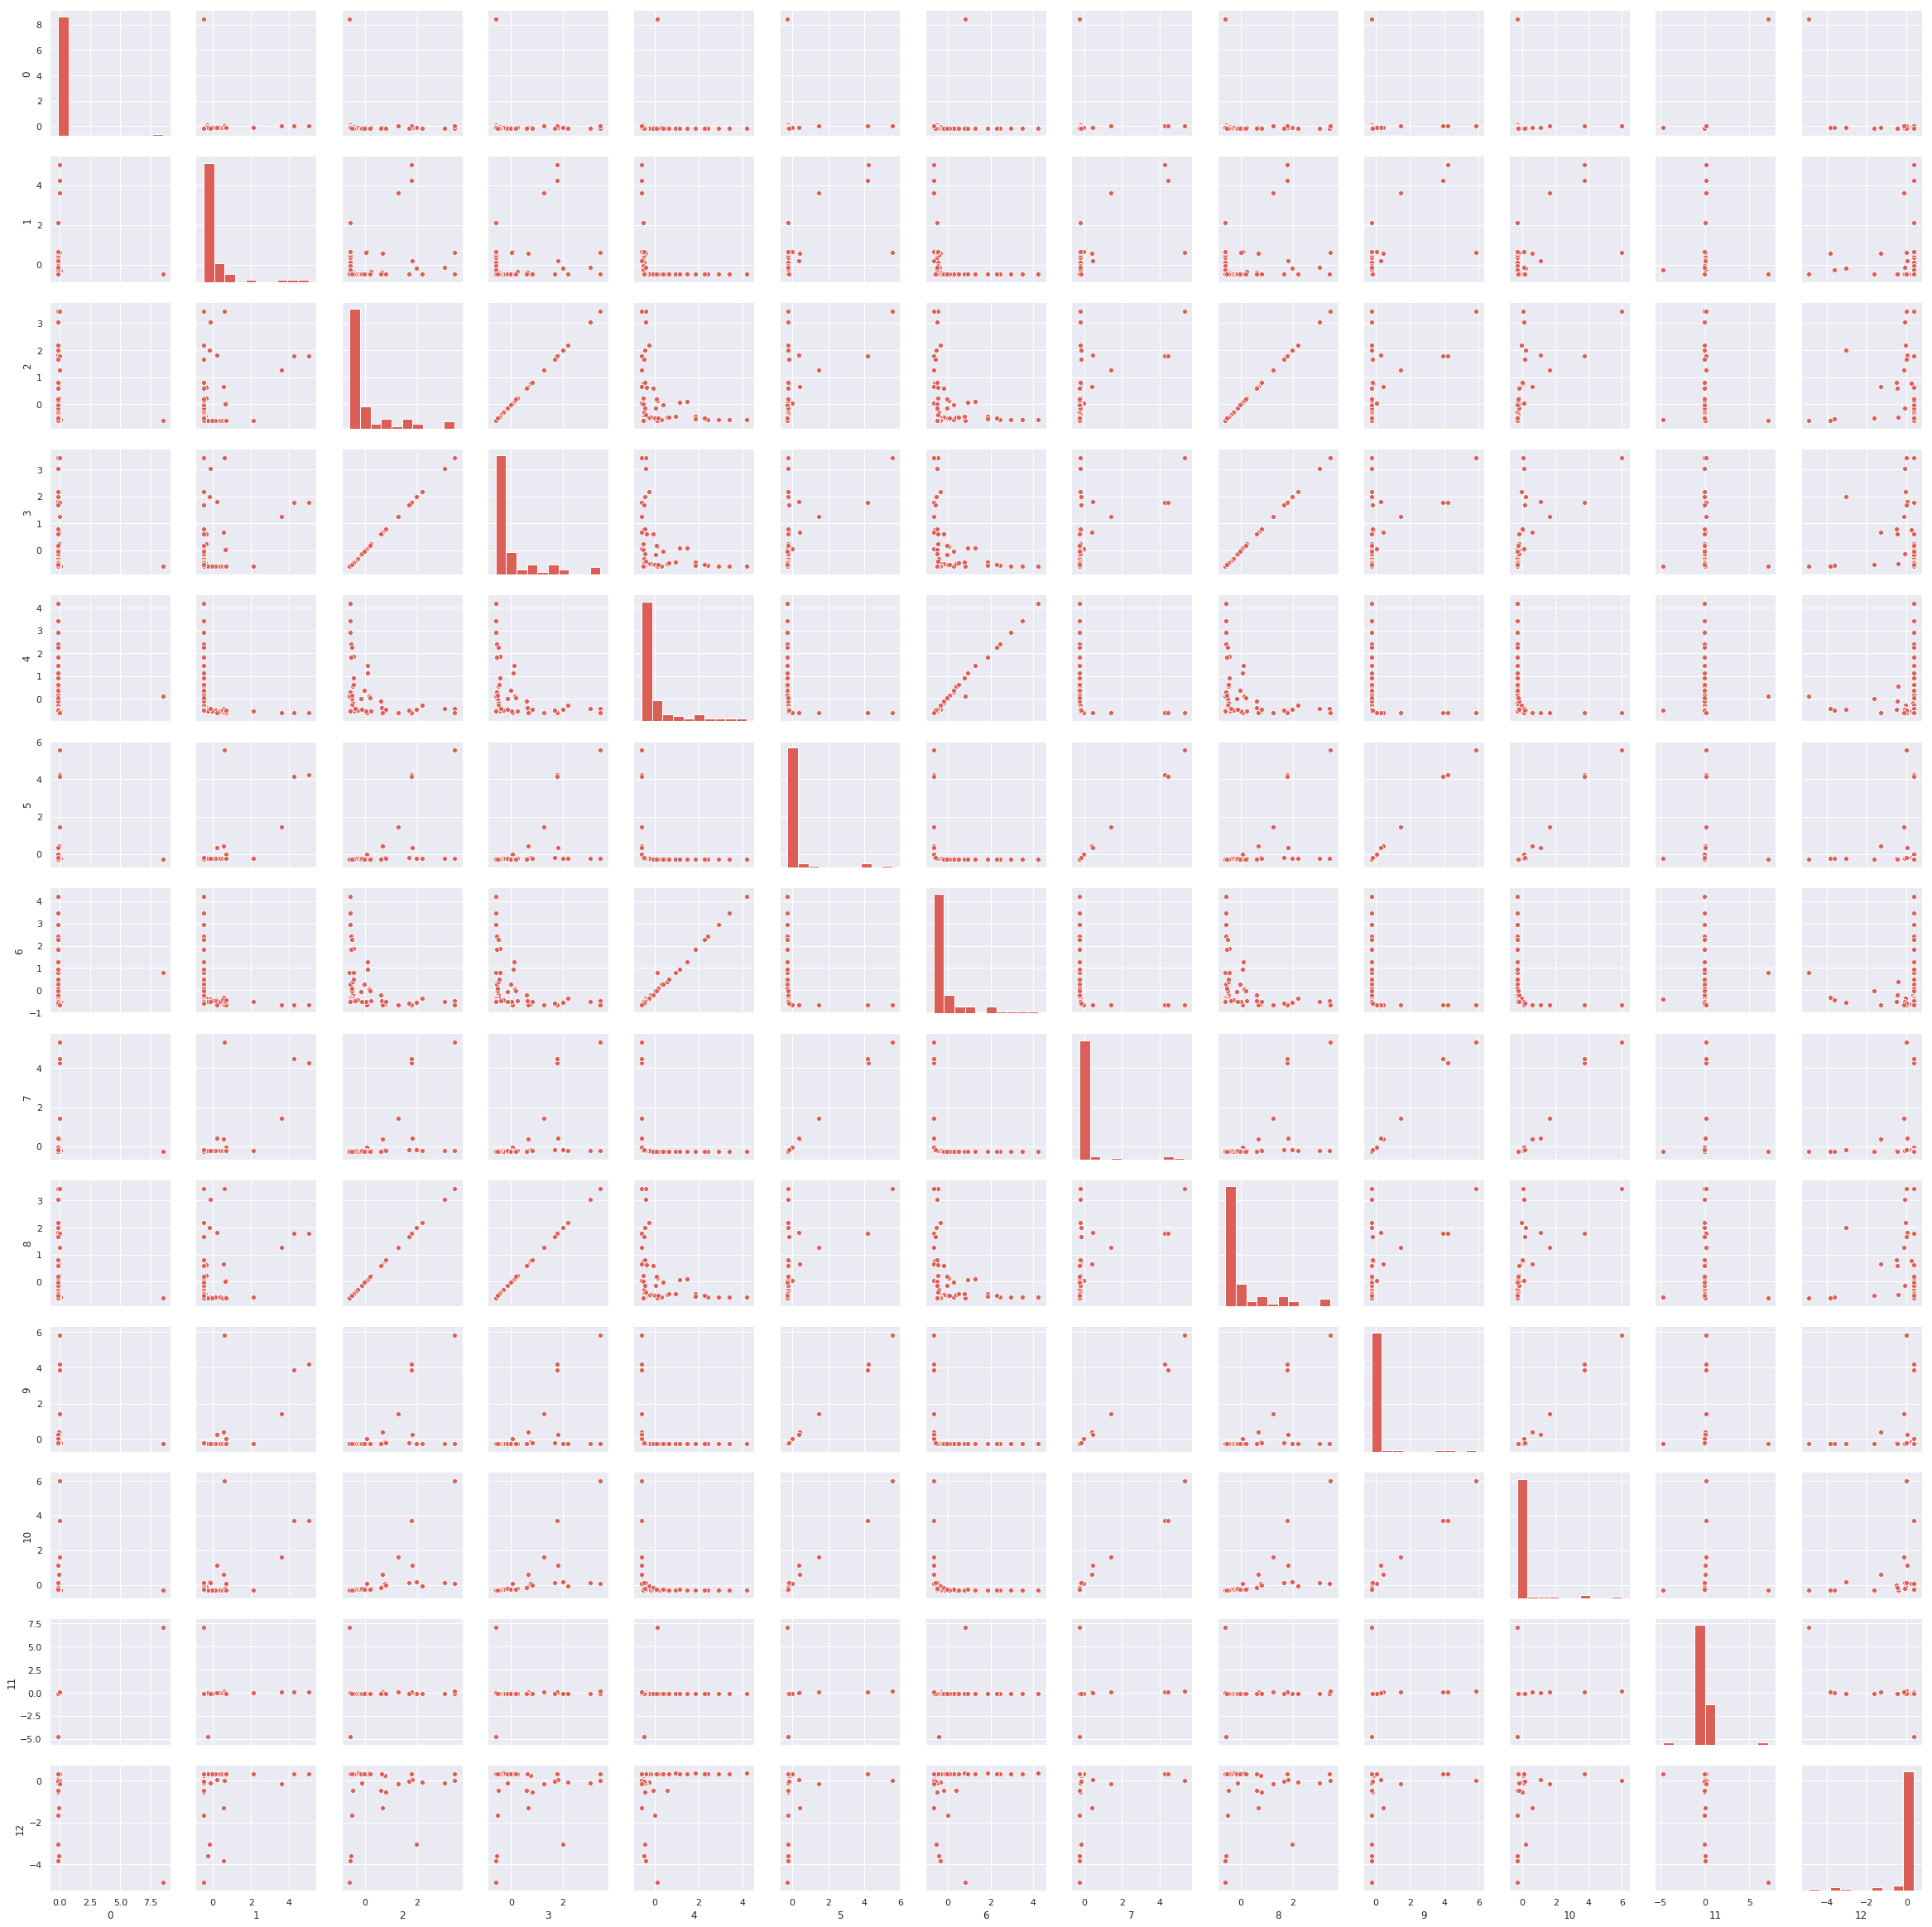

In [415]:
ff=pd.DataFrame(x_train_Pr)
sns.pairplot(ff)

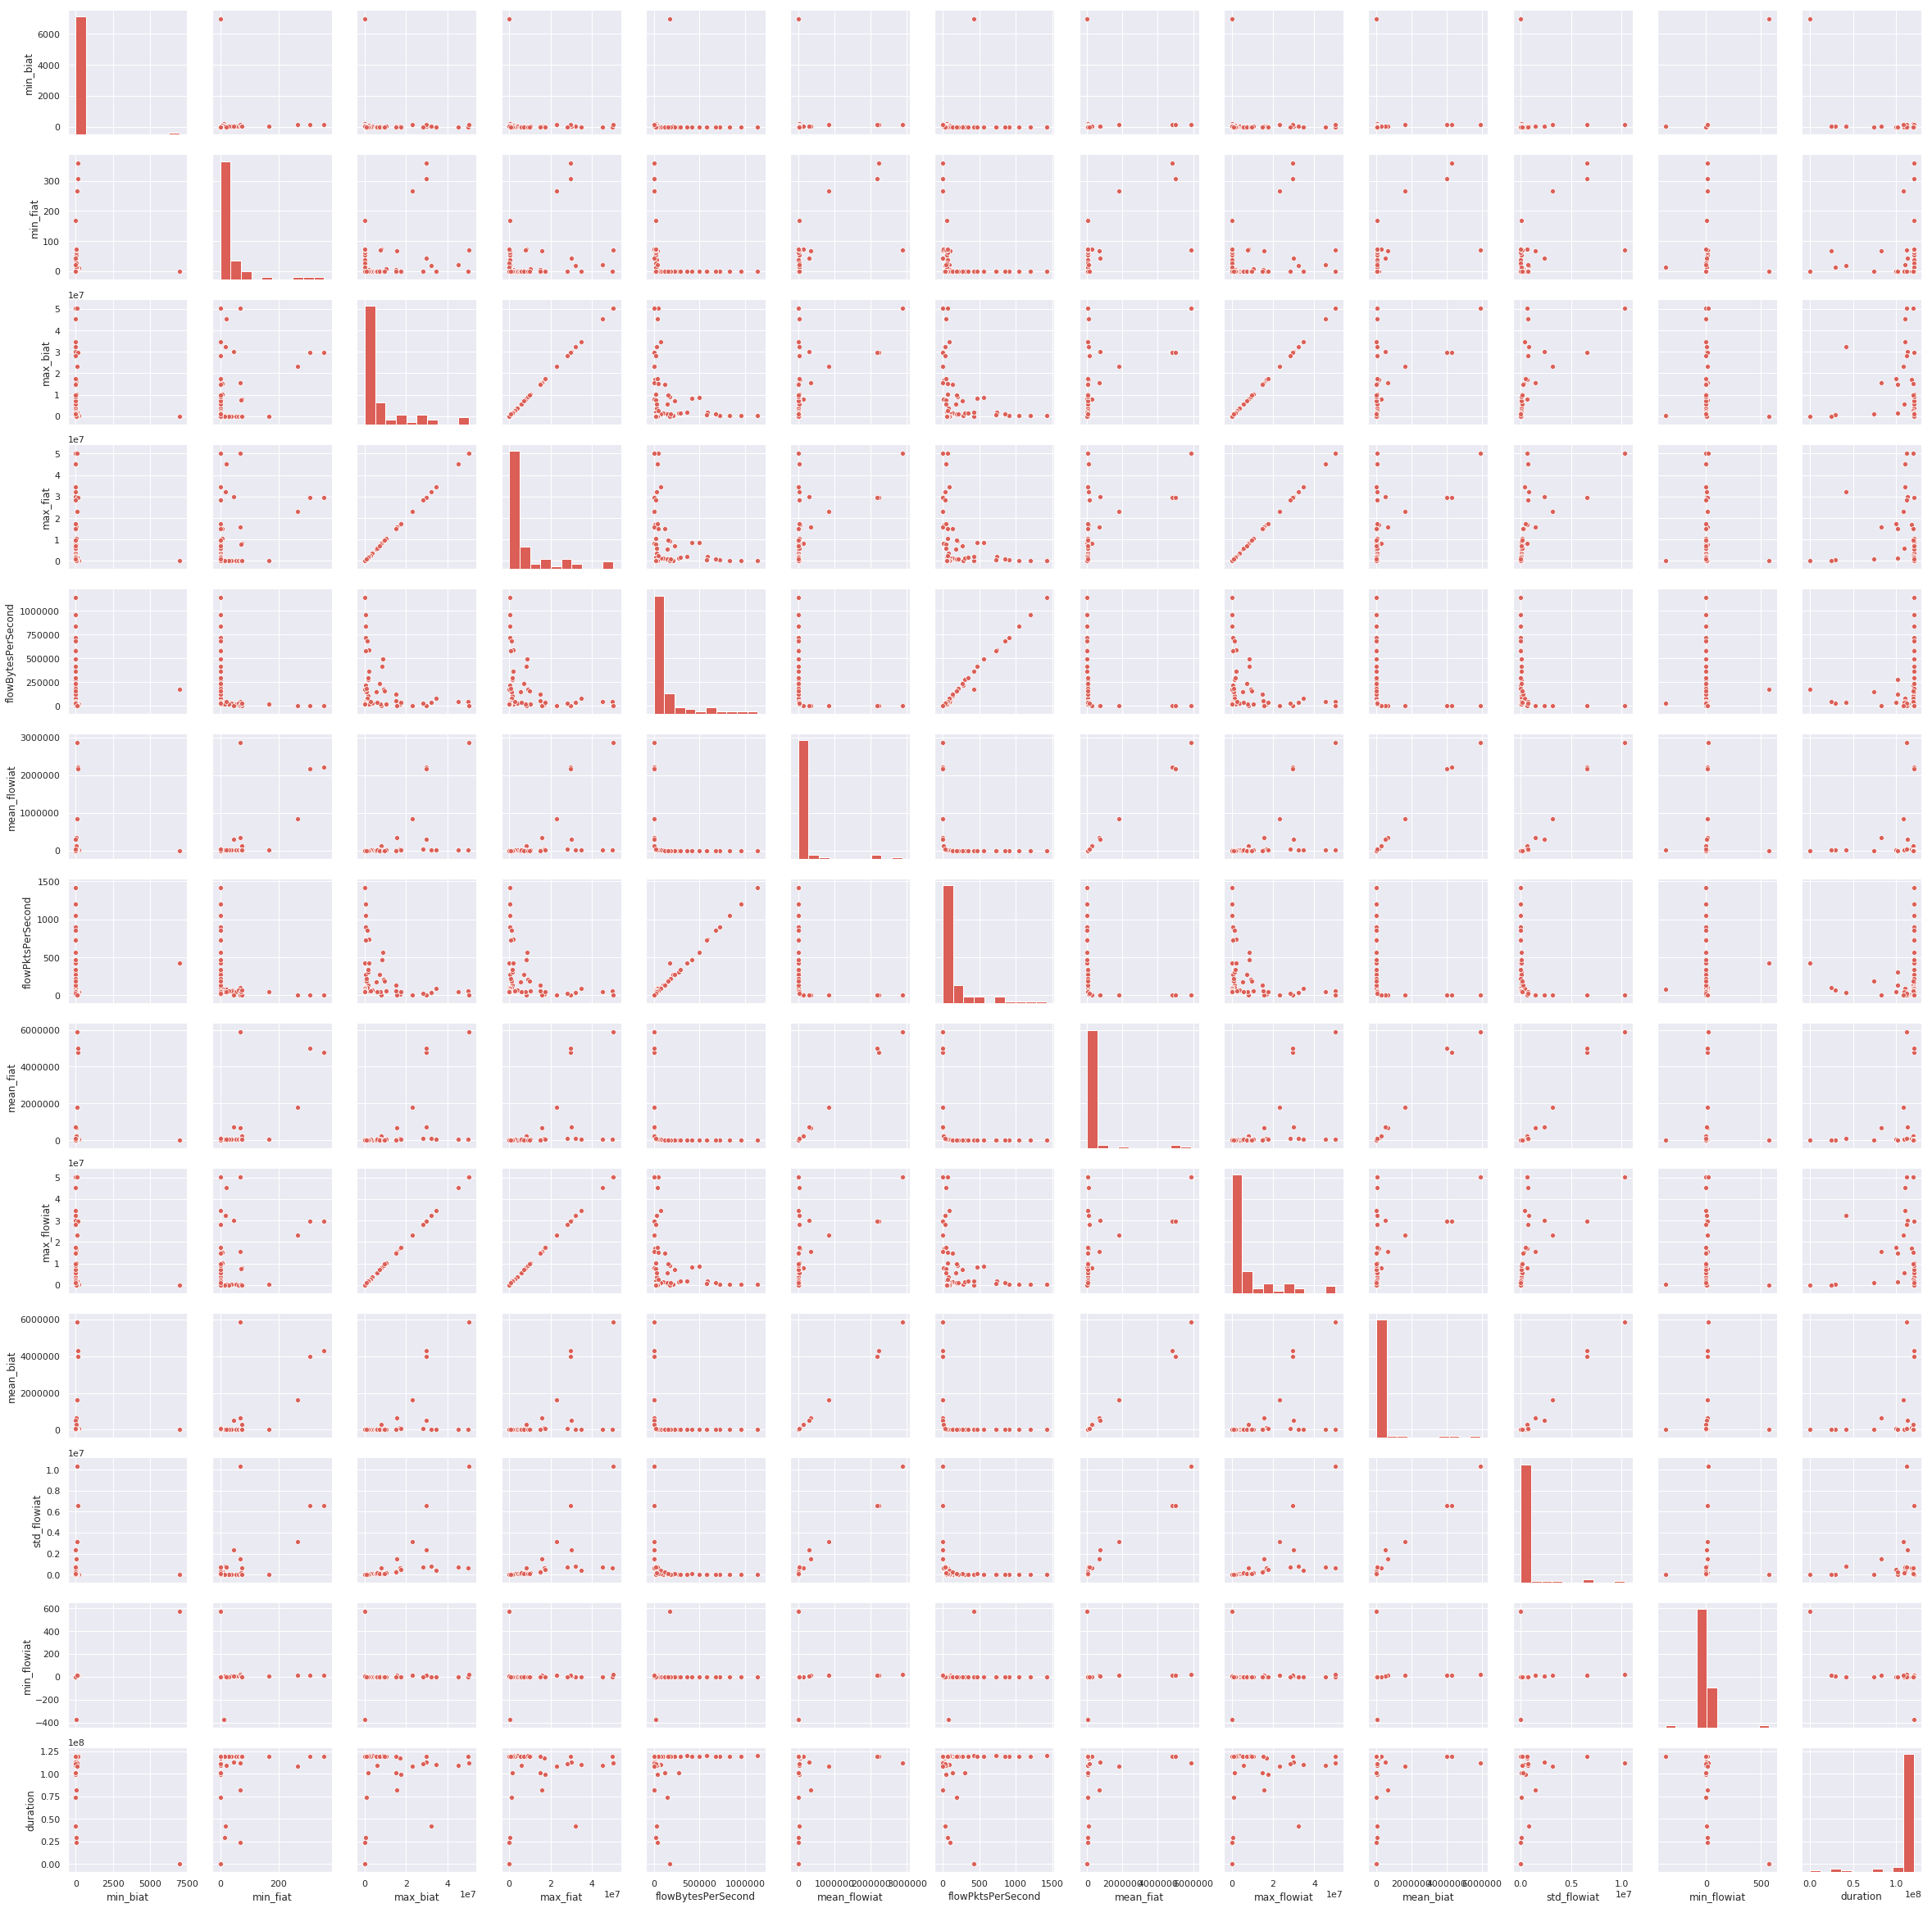

In [413]:
sns.pairplot(dfTrain_data)

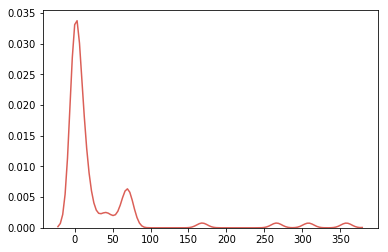

In [291]:
sns.set_palette("hls", 1)
p=sns.kdeplot(x_train[:,1])

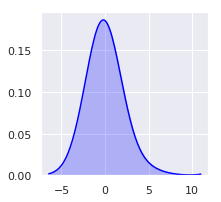

In [376]:

fig, ax = plt.subplots(figsize=(3,3))
sns.kdeplot(data=x_train_Pr[:,1],
           
            ax=ax,
            shade=True, 
            color="blue",  
            bw=2)
plt.show()

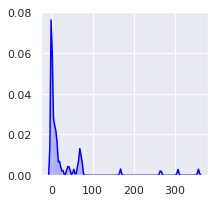

In [377]:
fig, ax = plt.subplots(figsize=(3,3))
sns.kdeplot(data=x_train[:,1],
           
            ax=ax,
            shade=True, 
            color="blue",  
            bw=2)
plt.show()

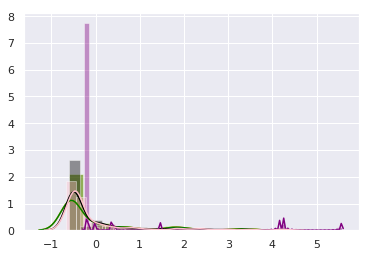

In [399]:
sns.distplot(x_train_Pr[:,2],  kde=True, color='orange')
sns.distplot(x_train_Pr[:,3],  kde=True, color='green')
sns.distplot(x_train_Pr[:,4],  kde=True, color='black')
sns.distplot(x_train_Pr[:,5],  kde=True, color='purple')
sns.distplot(x_train_Pr[:,6],  kde=True, color='pink')




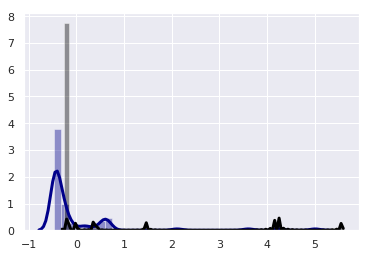

In [409]:
sns.distplot(x_train_Pr[:,1], hist = True, kde = True, rug = False,
             color = 'darkblue', 
             kde_kws={'linewidth': 3})#,
sns.distplot(x_train_Pr[:,5], hist = True, kde = True, rug = False,
             color = 'black', 
             kde_kws={'linewidth': 3})#,
#rug_kws={'color': 'red'})

ValueError: color kwarg must have one color per dataset

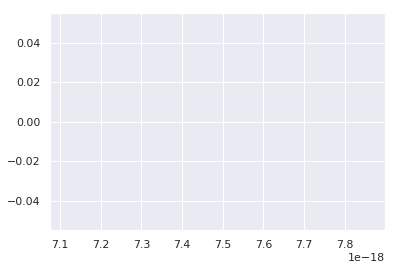

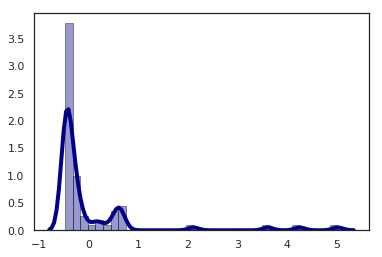

In [322]:
sns.distplot(x_train_Pr[:,1], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

ValueError: color kwarg must have one color per dataset

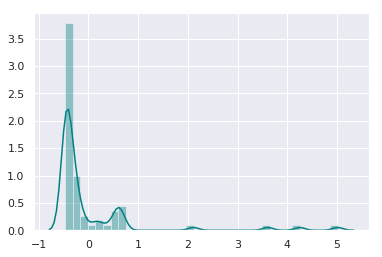

In [341]:
import matplotlib.pyplot as plt
sns.set(color_codes=False)
sns.set(style="white", palette="muted")
sns.set(style="darkgrid")
sns.distplot(x_train_Pr[:,1],color='teal',label='Normalized')
sns.distplot(x_train[:,1],color='gold',label='W/o Norm')
plt.title('Url Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')
plt.show()

In [293]:
x_train[:,1]

array([0.0, 68.0, 7.0, 9.0, 11.0, 12.0, 12.0, 0.0, 6.0, 14.0, 6.0, 18.0,
       4.0, 10.0, 11.0, 7.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 13.0, 9.0, 41.0, 38.0, 21.0, 68.0, 0.0, 0.0, 0.0,
       67.0, 54.0, 63.0, 71.0, 168.0, 44.0, 69.0, 0.0, 0.0, 7.0, 6.0, 0.0,
       6.0, 74.0, 71.0, 74.0, 27.0, 14.0, 0.0, 20.0, 0.0, 0.0, -1.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 358.0, 308.0, 0.0, 0.0, 0.0, 266.0],
      dtype=object)

In [294]:
x_train_Pr[:,1]

array([-0.45075925,  0.5870742 , -0.34392345, -0.31339894, -0.28287443,
       -0.26761217, -0.26761217, -0.45075925, -0.35918571, -0.23708766,
       -0.35918571, -0.17603863, -0.38971022, -0.29813668, -0.28287443,
       -0.34392345, -0.37444797, -0.45075925, -0.45075925, -0.45075925,
       -0.45075925, -0.45075925, -0.45075925, -0.45075925, -0.45075925,
       -0.45075925, -0.45075925, -0.45075925, -0.25234991, -0.31339894,
        0.17499327,  0.1292065 , -0.13025186,  0.5870742 , -0.45075925,
       -0.45075925, -0.45075925,  0.57181194,  0.3734026 ,  0.51076291,
        0.63286097,  2.11329985,  0.22078004,  0.60233645, -0.45075925,
       -0.45075925, -0.34392345, -0.35918571, -0.45075925, -0.35918571,
        0.67864774,  0.63286097,  0.67864774, -0.03867832, -0.23708766,
       -0.45075925, -0.14551412, -0.45075925, -0.45075925, -0.4660215 ,
       -0.45075925, -0.45075925, -0.45075925, -0.45075925, -0.45075925,
       -0.45075925, -0.45075925,  5.01312859,  4.25001576, -0.45

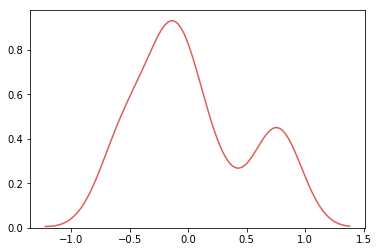

In [284]:
sns.set_palette("hls", 1)
p=sns.kdeplot(x_train_Pr[0])

In [290]:
len(x_train)

73

In [78]:
x_train
ss = pd.DataFrame(x_train)
ss.to_csv('results-xtrain.csv', index=False, header=False)

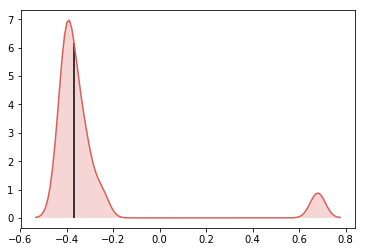

In [82]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("hls", 1)
p= sns.kdeplot(x_train[0], shade=True)

x,y = p.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()

x_median = x[nearest_05]
y_median = y[nearest_05]

plt.vlines(x_median, 0, y_median)
plt.show()

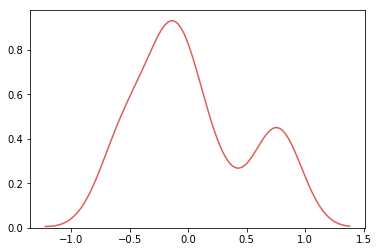

In [281]:
sns.kdeplot(x_train_Pr[0])


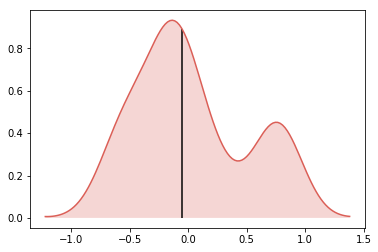

In [89]:
#How to locate the median in a (seaborn) KDE plot?
    #Extract the data of the kde line
    #Integrate it to calculate the cumulative distribution function (CDF)
    #Find the value that makes CDF equal 1/2, that is the median


import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("hls", 1)
z=sns.kdeplot(x_train_Pr[0], shade=True)

x,y = z.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()

x_median = x[nearest_05]
y_median = y[nearest_05]

plt.vlines(x_median, 0, y_median)
plt.show()

(73, 13)


array([[-1.10836787e-01, -4.50759248e-01,  7.62817235e-01,
         7.63641518e-01, -5.40750148e-01, -1.69056619e-01,
        -6.03926737e-01, -1.94017745e-01,  7.63807874e-01,
        -1.34653713e-01,  4.90125432e-02, -7.34223050e-02,
         2.43950977e-01],
       [-9.85084535e-02,  5.87074196e-01,  6.60802501e-01,
         6.61551204e-01, -5.98230020e-01,  4.12905200e-01,
        -6.62835249e-01,  3.79158295e-01,  6.61761024e-01,
         4.19661654e-01,  5.83351372e-01,  5.15154168e-02,
        -1.29571810e+00],
       [-9.60427867e-02, -3.43923452e-01,  2.34030592e-01,
         2.34494319e-01, -5.10225904e-01, -2.37349794e-01,
        -4.61452240e-01, -2.42713309e-01,  2.34749942e-01,
        -2.31353767e-01, -2.21549888e-01, -7.34223050e-02,
         3.56091257e-01],
       [-5.65921186e-02, -3.13398939e-01, -5.86334504e-01,
        -5.86567196e-01, -4.90315367e-01, -2.44591334e-01,
        -4.02328150e-01, -2.48961840e-01, -5.86191821e-01,
        -2.39375661e-01, -3.08244869e

In [32]:
x_train = dataPreProcessing(dfTrain_data)

ValueError: could not convert string to float: CHAT

In [ ]:
'CHAT' 'VIDEO-STREAMING' 'VOIP' 'P2P' 'EMAIL' 'FILE-TRANSFER' 'Browsing' 'AUDIO-STREAMING'

[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/15s/models must be empty
[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/15s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(18761, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 250)               3500      
_________________________________________________________________
dense_82 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_83 (Dense)             (None, 250)               62750    

13132/13132 [==============================] - 0s 37us/step - loss: 0.0065 - acc: 0.9986 - val_loss: 0.0055 - val_acc: 0.9989

Epoch 00033: val_acc did not improve from 0.99911
Epoch 34/40
13132/13132 [==============================] - 0s 37us/step - loss: 0.0061 - acc: 0.9985 - val_loss: 0.0104 - val_acc: 0.9970

Epoch 00034: val_acc did not improve from 0.99911
Epoch 35/40
13132/13132 [==============================] - 0s 37us/step - loss: 0.0063 - acc: 0.9986 - val_loss: 0.0066 - val_acc: 0.9984

Epoch 00035: val_acc did not improve from 0.99911
Epoch 36/40
13132/13132 [==============================] - 1s 39us/step - loss: 0.0065 - acc: 0.9986 - val_loss: 0.0049 - val_acc: 0.9989

Epoch 00036: val_acc did not improve from 0.99911
Epoch 37/40
13132/13132 [==============================] - 0s 37us/step - loss: 0.0072 - acc: 0.9984 - val_loss: 0.0070 - val_acc: 0.9988

Epoch 00037: val_acc did not improve from 0.99911
Epoch 38/40
13132/13132 [==============================] - 0s 36us/

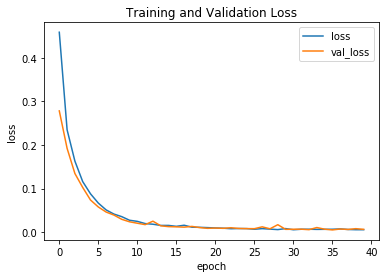

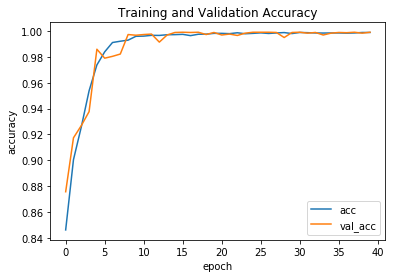

[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 0s 23us/step
[INFO] Predition Total time: 0.00132011969884
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:15s
('TEST LOSS, TEST ACCURACY:', [nan, 0.826940501359106])
[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/30s/models must be empty
[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/30s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13958, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 13)
_______________________________

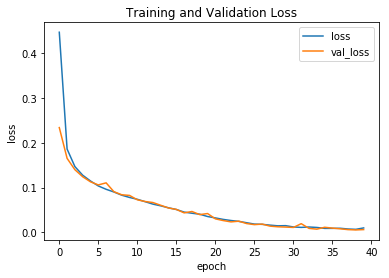

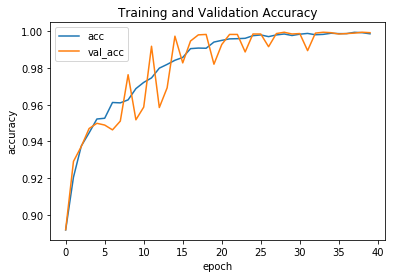

[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2464/2464 [==============================] - 0s 22us/step
[INFO] Predition Total time: 0.000931668281555
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:30s
('TEST LOSS, TEST ACCURACY:', [nan, 0.8693181818181818])
[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/60s/models must be empty
[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/60s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13964, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13964, 2)
[INFO] X TRAIN Shape is ](13964, 13)
_____________________________

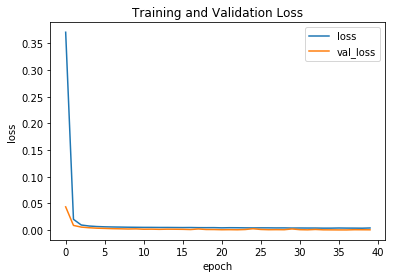

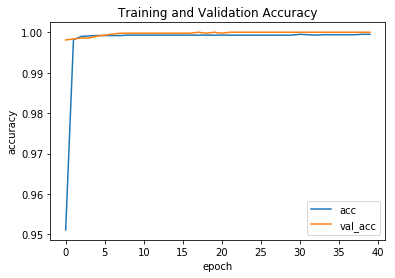

[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2465/2465 [==============================] - 0s 25us/step
[INFO] Predition Total time: 0.0010497490565
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:60s
('TEST LOSS, TEST ACCURACY:', [0.013077679850750479, 0.9991886409736308])
[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/120s/models must be empty
[INFO] Output directory output/TorVsNonTor/Dense/InfoGain/120s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(9564, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](9564, 2)
[INFO] X TRAIN Shape is ](9564, 13)
______________

6694/6694 [==============================] - 0s 37us/step - loss: 0.0396 - acc: 0.9845 - val_loss: 0.0475 - val_acc: 0.9798

Epoch 00032: val_acc did not improve from 0.98118
Epoch 33/40
6694/6694 [==============================] - 0s 36us/step - loss: 0.0392 - acc: 0.9846 - val_loss: 0.0384 - val_acc: 0.9808

Epoch 00033: val_acc did not improve from 0.98118
Epoch 34/40
6694/6694 [==============================] - 0s 36us/step - loss: 0.0376 - acc: 0.9842 - val_loss: 0.0422 - val_acc: 0.9801

Epoch 00034: val_acc did not improve from 0.98118
Epoch 35/40
6694/6694 [==============================] - 0s 37us/step - loss: 0.0386 - acc: 0.9839 - val_loss: 0.0387 - val_acc: 0.9812

Epoch 00035: val_acc did not improve from 0.98118
Epoch 36/40
6694/6694 [==============================] - 0s 37us/step - loss: 0.0375 - acc: 0.9842 - val_loss: 0.0374 - val_acc: 0.9812

Epoch 00036: val_acc did not improve from 0.98118
Epoch 37/40
6694/6694 [==============================] - 0s 38us/step - loss:

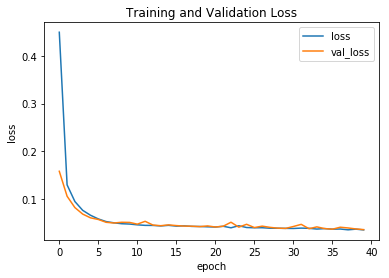

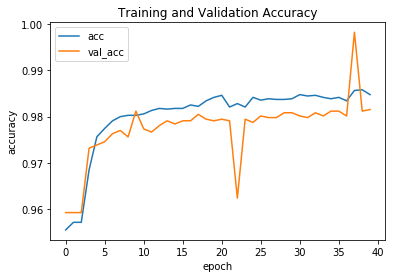

[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
1688/1688 [==============================] - 0s 24us/step
[INFO] Predition Total time: 0.000700934727987
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:120s
('TEST LOSS, TEST ACCURACY:', [nan, 0.9117298578199052])
[INFO] Output directory output/TorVsNonTor/Dense/Correlation/15s/models must be empty
[INFO] Output directory output/TorVsNonTor/Dense/Correlation/15s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(18761, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 14)
____________________

13132/13132 [==============================] - 0s 38us/step - loss: 0.0080 - acc: 0.9988 - val_loss: 0.0110 - val_acc: 0.9972

Epoch 00031: val_acc did not improve from 0.99911
Epoch 32/40
13132/13132 [==============================] - 0s 37us/step - loss: 0.0081 - acc: 0.9987 - val_loss: 0.0096 - val_acc: 0.9968

Epoch 00032: val_acc did not improve from 0.99911
Epoch 33/40
13132/13132 [==============================] - 1s 43us/step - loss: 0.0084 - acc: 0.9986 - val_loss: 0.0093 - val_acc: 0.9984

Epoch 00033: val_acc did not improve from 0.99911
Epoch 34/40
13132/13132 [==============================] - 1s 42us/step - loss: 0.0080 - acc: 0.9986 - val_loss: 0.0069 - val_acc: 0.9991

Epoch 00034: val_acc did not improve from 0.99911
Epoch 35/40
13132/13132 [==============================] - 1s 41us/step - loss: 0.0082 - acc: 0.9986 - val_loss: 0.0065 - val_acc: 0.9989

Epoch 00035: val_acc did not improve from 0.99911
Epoch 36/40
13132/13132 [==============================] - 0s 36us/

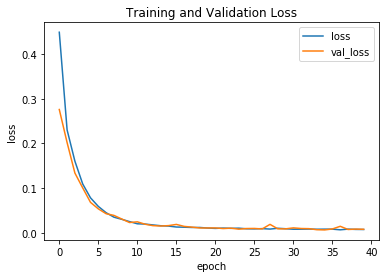

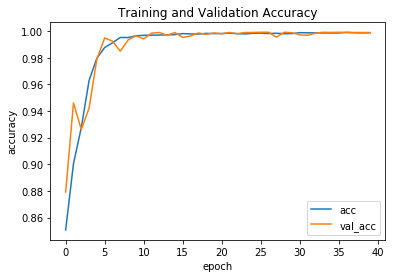

[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 0s 24us/step
[INFO] Predition Total time: 0.0013552347819
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:15s
('TEST LOSS, TEST ACCURACY:', [nan, 0.8272425249169435])
[INFO] Output directory output/TorVsNonTor/Dense/Correlation/30s/models must be empty
[INFO] Output directory output/TorVsNonTor/Dense/Correlation/30s/logs must be empty
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(13958, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 14)
____________________

9770/9770 [==============================] - 0s 37us/step - loss: 0.0146 - acc: 0.9982 - val_loss: 0.0140 - val_acc: 0.9983

Epoch 00030: val_acc improved from 0.99809 to 0.99833, saving model to output/TorVsNonTor/Dense/Correlation/30s/logs/Dense_best.h5
Epoch 31/40
9770/9770 [==============================] - 0s 37us/step - loss: 0.0137 - acc: 0.9979 - val_loss: 0.0126 - val_acc: 0.9990

Epoch 00031: val_acc improved from 0.99833 to 0.99904, saving model to output/TorVsNonTor/Dense/Correlation/30s/logs/Dense_best.h5
Epoch 32/40
9770/9770 [==============================] - 0s 37us/step - loss: 0.0128 - acc: 0.9983 - val_loss: 0.0130 - val_acc: 0.9988

Epoch 00032: val_acc did not improve from 0.99904
Epoch 33/40
6528/9770 [===================>..........] - ETA: 0s - loss: 0.0106 - acc: 0.9985

KeyboardInterrupt: 

In [55]:
# Without Preprocessing on Testing Data
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
                log_file = os.path.join(log_dir, 'training.csv')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                cpt_last = os.path.join(log_dir, '{}_last.h5'.format(ARCHITECTURE))
                output_dirs = [OUTPUT_DIR,mdl_dir, log_dir, cpt_dir]
                output_dirs = [directory for directory in output_dirs if directory is not None]
                #Create Directories
                for directory in output_dirs:
                    if not os.path.isdir(directory):
                        os.makedirs(directory)
                    elif len(glob.glob(os.path.join(directory, '*.*'))) > 0:
                        print('[INFO] Output directory {} must be empty'.format(directory))
                
                #Get Training Data 
                x_train, y_train = getTrainData(DataSetDuration,DATASET_ID)
                print('[INFO] Y TRAIN Shape is ]{}'.format(y_train.shape))
                print('[INFO] X TRAIN Shape is ]{}'.format(x_train.shape))
                #Architectures = ['Dense','CNN']
                if ARCHITECTURE != 'Dense':
                    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1).astype( 'float32' )
                    model = cnnModel(x_train.shape[1] ,y_train.shape[1])
                    print('X TRAIN Shape is after Reshaping For CNN ]{}'.format(x_train.shape))
                else:
                     model = denseModel(x_train.shape[1] ,y_train.shape[1])
                model.summary()
                # Split Data
                x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.30, shuffle= True)                
                # serialize models to json
                model_train_json = model.to_json()
                with open(mdl_train_file, 'w') as file:
                    file.write(model_train_json)
                
                checkpoints = callbacks(log_file,cpt_best,cpt_last)
                Epochs = 40
                if DATASET_ID == 'Labels':
                    Epochs = 60 
                history = model.fit(x_train, y_train,
                     epochs=Epochs,
                     validation_data=(x_valid,y_valid),
                     shuffle=True,
                     callbacks=checkpoints,
                     batch_size= 64)
                plot(history,log_dir)
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                if ARCHITECTURE != 'Dense':
                    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype( 'float32' )
                t = time.time()
                results = model.evaluate(x_test, y_test)
                print('[INFO] Predition Total time: {}'.format( (time.time() - t)/60))
                print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)

In [410]:
sns.pairplot(train_x_Pr)

NameError: name 'train_x_Pr' is not defined

[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(18761, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 250)               3500      
_________________________________________________________________
dense_6 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_7 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 502       
Total params: 129,502
Trainabl


Epoch 00032: val_acc did not improve from 0.99858
Epoch 33/40
13132/13132 [==============================] - 0s 29us/step - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0086 - val_acc: 0.9984

Epoch 00033: val_acc did not improve from 0.99858
Epoch 34/40
13132/13132 [==============================] - 0s 27us/step - loss: 0.0044 - acc: 0.9992 - val_loss: 0.0058 - val_acc: 0.9980

Epoch 00034: val_acc did not improve from 0.99858
Epoch 35/40
13132/13132 [==============================] - 0s 28us/step - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0074 - val_acc: 0.9984

Epoch 00035: val_acc did not improve from 0.99858
Epoch 36/40
13132/13132 [==============================] - 0s 27us/step - loss: 0.0044 - acc: 0.9992 - val_loss: 0.0070 - val_acc: 0.9979

Epoch 00036: val_acc did not improve from 0.99858
Epoch 37/40
13132/13132 [==============================] - 0s 28us/step - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0084 - val_acc: 0.9973

Epoch 00037: val_acc did not improve from 0.99858
Epoc

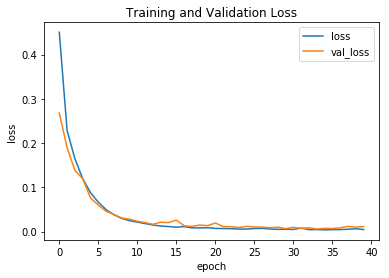

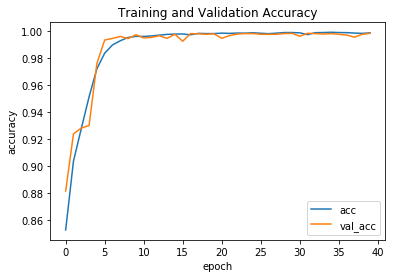

(3311, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 0s 13us/step
[INFO] Predition Total time: 0.000752949714661
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:15s
('TEST LOSS, TEST ACCURACY:', [2.0287982693567828, 0.73180308064029])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13958, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2

9770/9770 [==============================] - 0s 26us/step - loss: 0.0122 - acc: 0.9987 - val_loss: 0.0178 - val_acc: 0.9986

Epoch 00031: val_acc did not improve from 0.99857
Epoch 32/40
9770/9770 [==============================] - 0s 28us/step - loss: 0.0111 - acc: 0.9984 - val_loss: 0.0286 - val_acc: 0.9988

Epoch 00032: val_acc improved from 0.99857 to 0.99881, saving model to output/TorVsNonTor/Dense/InfoGain/30s/logs/Dense_best.h5
Epoch 33/40
9770/9770 [==============================] - 0s 34us/step - loss: 0.0112 - acc: 0.9984 - val_loss: 0.0176 - val_acc: 0.9983

Epoch 00033: val_acc did not improve from 0.99881
Epoch 34/40
9770/9770 [==============================] - 0s 38us/step - loss: 0.0112 - acc: 0.9984 - val_loss: 0.0170 - val_acc: 0.9986

Epoch 00034: val_acc did not improve from 0.99881
Epoch 35/40
9770/9770 [==============================] - 0s 37us/step - loss: 0.0088 - acc: 0.9989 - val_loss: 0.0163 - val_acc: 0.9983

Epoch 00035: val_acc did not improve from 0.99881

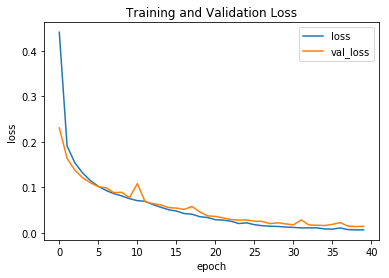

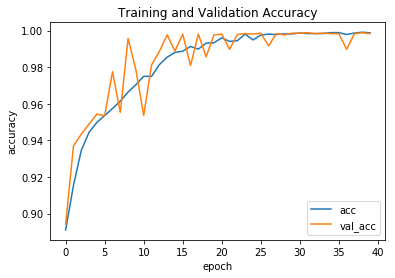

(2464, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2464/2464 [==============================] - 0s 14us/step
[INFO] Predition Total time: 0.000612533092499
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:30s
('TEST LOSS, TEST ACCURACY:', [0.8560794291738606, 0.9407467532467533])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13964, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13964, 2)
[INFO] X TRAIN Shape is ](13964, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None,

9774/9774 [==============================] - 0s 29us/step - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0051 - val_acc: 0.9995

Epoch 00034: val_acc did not improve from 0.99952
Epoch 35/40
9774/9774 [==============================] - 0s 27us/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0051 - val_acc: 0.9995

Epoch 00035: val_acc did not improve from 0.99952
Epoch 36/40
9774/9774 [==============================] - 0s 27us/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0055 - val_acc: 0.9995

Epoch 00036: val_acc did not improve from 0.99952
Epoch 37/40
9774/9774 [==============================] - 0s 28us/step - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0059 - val_acc: 0.9995

Epoch 00037: val_acc did not improve from 0.99952
Epoch 38/40
9774/9774 [==============================] - 0s 27us/step - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0060 - val_acc: 0.9995

Epoch 00038: val_acc did not improve from 0.99952
Epoch 39/40
9774/9774 [==============================] - 0s 27us/step - loss:

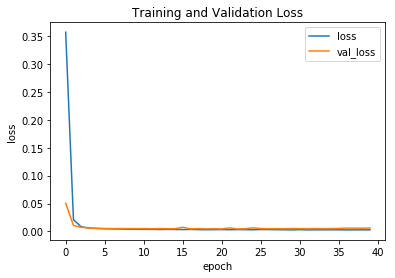

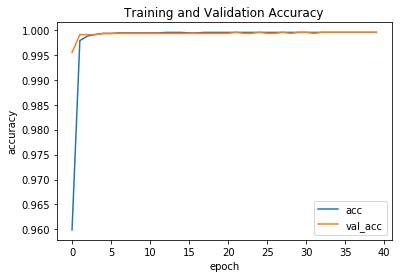

(2465, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2465/2465 [==============================] - 0s 13us/step
[INFO] Predition Total time: 0.000565767288208
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:60s
('TEST LOSS, TEST ACCURACY:', [0.0207535198280042, 0.9983772819472616])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(9564, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](9564, 2)
[INFO] X TRAIN Shape is ](9564, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 2

6694/6694 [==============================] - 0s 29us/step - loss: 0.0410 - acc: 0.9824 - val_loss: 0.0359 - val_acc: 0.9854

Epoch 00031: val_acc did not improve from 0.99826
Epoch 32/40
6694/6694 [==============================] - 0s 29us/step - loss: 0.0418 - acc: 0.9824 - val_loss: 0.0348 - val_acc: 0.9840

Epoch 00032: val_acc did not improve from 0.99826
Epoch 33/40
6694/6694 [==============================] - 0s 28us/step - loss: 0.0405 - acc: 0.9819 - val_loss: 0.0362 - val_acc: 0.9861

Epoch 00033: val_acc did not improve from 0.99826
Epoch 34/40
6694/6694 [==============================] - 0s 29us/step - loss: 0.0414 - acc: 0.9845 - val_loss: 0.0350 - val_acc: 0.9854

Epoch 00034: val_acc did not improve from 0.99826
Epoch 35/40
6694/6694 [==============================] - 0s 30us/step - loss: 0.0421 - acc: 0.9825 - val_loss: 0.0323 - val_acc: 0.9861

Epoch 00035: val_acc did not improve from 0.99826
Epoch 36/40
6694/6694 [==============================] - 0s 29us/step - loss:

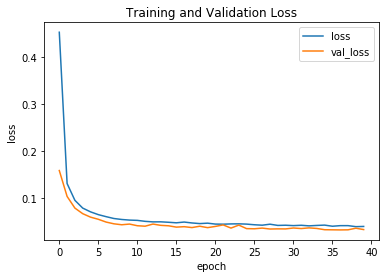

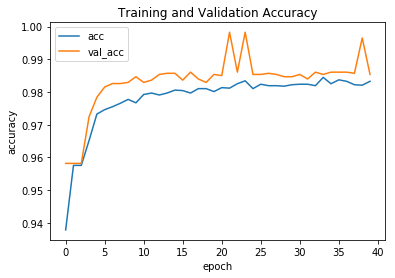

(1688, 13)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
1688/1688 [==============================] - 0s 15us/step
[INFO] Predition Total time: 0.000453229745229
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:120s
('TEST LOSS, TEST ACCURACY:', [0.04693845564038405, 0.9845971563981043])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(18761, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (N

13132/13132 [==============================] - 0s 28us/step - loss: 0.0093 - acc: 0.9984 - val_loss: 0.0139 - val_acc: 0.9986

Epoch 00031: val_acc did not improve from 0.99893
Epoch 32/40
13132/13132 [==============================] - 0s 28us/step - loss: 0.0094 - acc: 0.9986 - val_loss: 0.0109 - val_acc: 0.9986

Epoch 00032: val_acc did not improve from 0.99893
Epoch 33/40
13132/13132 [==============================] - 0s 28us/step - loss: 0.0087 - acc: 0.9982 - val_loss: 0.0107 - val_acc: 0.9986

Epoch 00033: val_acc did not improve from 0.99893
Epoch 34/40
13132/13132 [==============================] - 0s 28us/step - loss: 0.0088 - acc: 0.9986 - val_loss: 0.0094 - val_acc: 0.9977

Epoch 00034: val_acc did not improve from 0.99893
Epoch 35/40
13132/13132 [==============================] - 0s 28us/step - loss: 0.0083 - acc: 0.9988 - val_loss: 0.0166 - val_acc: 0.9959

Epoch 00035: val_acc did not improve from 0.99893
Epoch 36/40
13132/13132 [==============================] - 0s 28us/

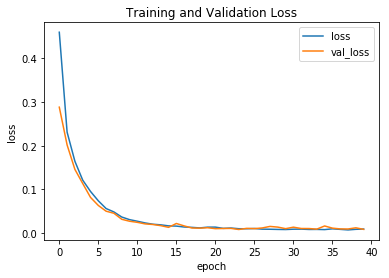

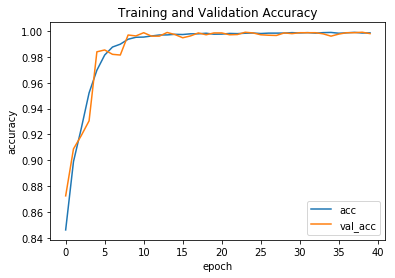

(3311, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 0s 14us/step
[INFO] Predition Total time: 0.00081848303477
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:15s
('TEST LOSS, TEST ACCURACY:', [2.1256473473763537, 0.6837813349441256])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(13958, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (N

9770/9770 [==============================] - 0s 29us/step - loss: 0.0137 - acc: 0.9977 - val_loss: 0.0128 - val_acc: 0.9979

Epoch 00031: val_acc did not improve from 0.99904
Epoch 32/40
9770/9770 [==============================] - 0s 28us/step - loss: 0.0116 - acc: 0.9982 - val_loss: 0.0114 - val_acc: 0.9981

Epoch 00032: val_acc did not improve from 0.99904
Epoch 33/40
9770/9770 [==============================] - 0s 28us/step - loss: 0.0103 - acc: 0.9988 - val_loss: 0.0105 - val_acc: 0.9986

Epoch 00033: val_acc did not improve from 0.99904
Epoch 34/40
9770/9770 [==============================] - 0s 29us/step - loss: 0.0111 - acc: 0.9986 - val_loss: 0.0128 - val_acc: 0.9986

Epoch 00034: val_acc did not improve from 0.99904
Epoch 35/40
9770/9770 [==============================] - 0s 28us/step - loss: 0.0092 - acc: 0.9987 - val_loss: 0.0252 - val_acc: 0.9993

Epoch 00035: val_acc improved from 0.99904 to 0.99928, saving model to output/TorVsNonTor/Dense/Correlation/30s/logs/Dense_best

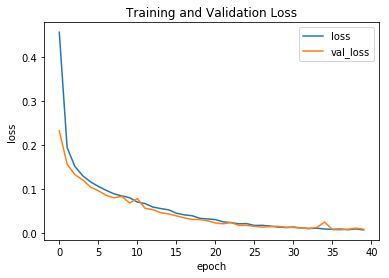

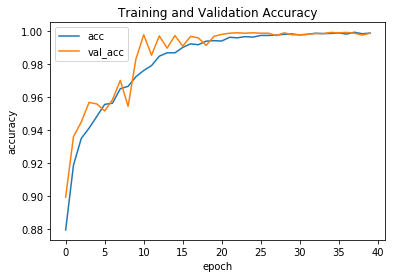

(2464, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2464/2464 [==============================] - 0s 16us/step
[INFO] Predition Total time: 0.000687380631765
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:30s
('TEST LOSS, TEST ACCURACY:', [0.8890927040396626, 0.9407467532467533])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(13964, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13964, 2)
[INFO] X TRAIN Shape is ](13964, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (

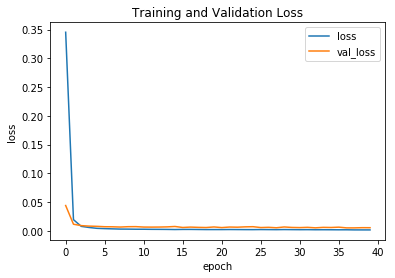

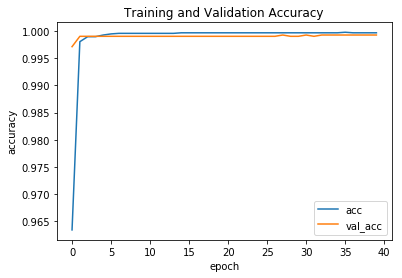

(2465, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2465/2465 [==============================] - 0s 16us/step
[INFO] Predition Total time: 0.000684217611949
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:60s
('TEST LOSS, TEST ACCURACY:', [0.007848784771754047, 0.9987829614604462])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(9564, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](9564, 2)
[INFO] X TRAIN Shape is ](9564, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (


Epoch 00031: val_acc did not improve from 0.98397
Epoch 32/40
6694/6694 [==============================] - 0s 30us/step - loss: 0.0406 - acc: 0.9815 - val_loss: 0.0441 - val_acc: 0.9819

Epoch 00032: val_acc did not improve from 0.98397
Epoch 33/40
6694/6694 [==============================] - 0s 30us/step - loss: 0.0394 - acc: 0.9824 - val_loss: 0.0433 - val_acc: 0.9812

Epoch 00033: val_acc did not improve from 0.98397
Epoch 34/40
6694/6694 [==============================] - 0s 30us/step - loss: 0.0395 - acc: 0.9827 - val_loss: 0.0445 - val_acc: 0.9836

Epoch 00034: val_acc did not improve from 0.98397
Epoch 35/40
6694/6694 [==============================] - 0s 31us/step - loss: 0.0397 - acc: 0.9818 - val_loss: 0.0437 - val_acc: 0.9812

Epoch 00035: val_acc did not improve from 0.98397
Epoch 36/40
6694/6694 [==============================] - 0s 30us/step - loss: 0.0411 - acc: 0.9803 - val_loss: 0.0432 - val_acc: 0.9822

Epoch 00036: val_acc did not improve from 0.98397
Epoch 37/40
66

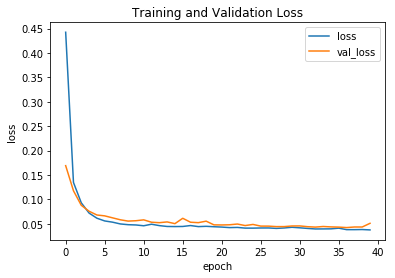

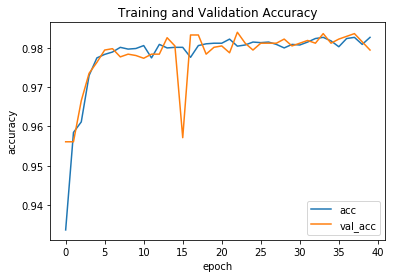

(1688, 14)
[INFO] Before Preprocssing Y Labels ['NONTOR' 'NONTOR' 'NONTOR' ... 'TOR' 'TOR' 'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
1688/1688 [==============================] - 0s 17us/step
[INFO] Predition Total time: 0.000498080253601
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:120s
('TEST LOSS, TEST ACCURACY:', [0.05582885008674937, 0.9834123222748815])
[INFO] PATH FOR LOADED DATASET: CSV/Scenario-B/TimeBasedFeatures-15s-Layer2-85.arff
[INFO] Data loaded for info Gain
(2856, 13)
[INFO] Before Preprocssing Y Labels ['CHAT' 'VIDEO-STREAMING' 'CHAT' ... 'VOIP' 'VOIP' 'VOIP']
[INFO] After Preprocssing Y Labels [[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
[INFO] Y TRAIN Shape is ](2856, 10)
[INFO] X TRAIN Shape is ](2856, 13)
_________________________________________________________________
Layer (type)          

1999/1999 [==============================] - 0s 36us/step - loss: 1.6370 - acc: 0.5538 - val_loss: 1.5603 - val_acc: 0.5776

Epoch 00031: val_acc did not improve from 0.66161
Epoch 32/60
1999/1999 [==============================] - 0s 41us/step - loss: 1.6299 - acc: 0.5713 - val_loss: 1.5481 - val_acc: 0.6114

Epoch 00032: val_acc did not improve from 0.66161
Epoch 33/60
1999/1999 [==============================] - 0s 45us/step - loss: 1.6278 - acc: 0.5673 - val_loss: 1.5542 - val_acc: 0.5904

Epoch 00033: val_acc did not improve from 0.66161
Epoch 34/60
1999/1999 [==============================] - 0s 41us/step - loss: 1.6209 - acc: 0.5748 - val_loss: 1.5375 - val_acc: 0.6184

Epoch 00034: val_acc did not improve from 0.66161
Epoch 35/60
1999/1999 [==============================] - 0s 43us/step - loss: 1.6143 - acc: 0.5853 - val_loss: 1.5351 - val_acc: 0.6441

Epoch 00035: val_acc did not improve from 0.66161
Epoch 36/60
1999/1999 [==============================] - 0s 42us/step - loss:

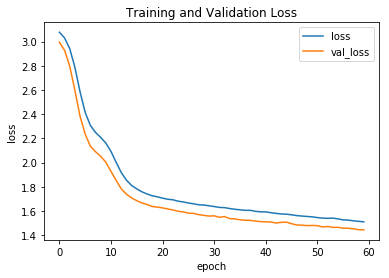

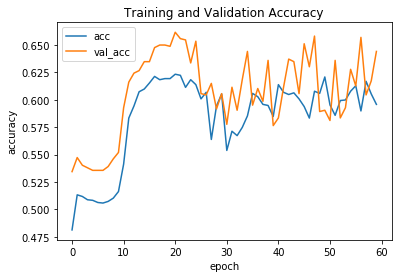

(504, 13)
[INFO] Before Preprocssing Y Labels ['CHAT' 'VIDEO-STREAMING' 'CHAT' 'VOIP' 'VOIP' 'CHAT' 'VIDEO-STREAMING'
 'VIDEO-STREAMING' 'CHAT' 'VOIP' 'VIDEO-STREAMING' 'CHAT' 'P2P' 'CHAT'
 'EMAIL' 'VOIP' 'VOIP' 'VIDEO-STREAMING' 'CHAT' 'CHAT' 'VIDEO-STREAMING'
 'FILE-TRANSFER' 'VIDEO-STREAMING' 'CHAT' 'FILE-TRANSFER' 'P2P' 'EMAIL'
 'CHAT' 'CHAT' 'CHAT' 'EMAIL' 'P2P' 'EMAIL' 'CHAT' 'CHAT' 'P2P' 'CHAT'
 'EMAIL' 'FILE-TRANSFER' 'VOIP' 'CHAT' 'VOIP' 'FILE-TRANSFER' 'VOIP'
 'FILE-TRANSFER' 'FILE-TRANSFER' 'CHAT' 'CHAT' 'P2P' 'P2P' 'VOIP' 'CHAT'
 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER' 'VOIP' 'EMAIL' 'EMAIL'
 'VOIP' 'VOIP' 'P2P' 'EMAIL' 'FILE-TRANSFER' 'BROWSING' 'FILE-TRANSFER'
 'EMAIL' 'BROWSING' 'BROWSING' 'VIDEO-STREAMING' 'EMAIL' 'FILE-TRANSFER'
 'VIDEO-STREAMING' 'FILE-TRANSFER' 'VIDEO-STREAMING' 'P2P' 'VOIP'
 'BROWSING' 'VOIP' 'VOIP' 'FILE-TRANSFER' 'P2P' 'VOIP' 'FILE-TRANSFER'
 'VIDEO-STREAMING' 'VOIP' 'FILE-TRANSFER' 'VOIP' 'FILE-TRANSFER' 'VOIP'
 'BROWSING' 'VIDEO-STREAMIN

1072/1072 [==============================] - 0s 42us/step - loss: 2.9104 - acc: 0.4748 - val_loss: 2.8837 - val_acc: 0.4935

Epoch 00005: val_acc improved from 0.47391 to 0.49348, saving model to output/Labels/Dense/InfoGain/30s/logs/Dense_best.h5
Epoch 6/60
1072/1072 [==============================] - 0s 46us/step - loss: 2.8187 - acc: 0.4813 - val_loss: 2.7839 - val_acc: 0.5087

Epoch 00006: val_acc improved from 0.49348 to 0.50870, saving model to output/Labels/Dense/InfoGain/30s/logs/Dense_best.h5
Epoch 7/60
1072/1072 [==============================] - 0s 44us/step - loss: 2.7043 - acc: 0.4963 - val_loss: 2.6702 - val_acc: 0.5152

Epoch 00007: val_acc improved from 0.50870 to 0.51522, saving model to output/Labels/Dense/InfoGain/30s/logs/Dense_best.h5
Epoch 8/60
1072/1072 [==============================] - 0s 43us/step - loss: 2.5785 - acc: 0.5047 - val_loss: 2.5570 - val_acc: 0.5152

Epoch 00008: val_acc did not improve from 0.51522
Epoch 9/60
1072/1072 [==========================

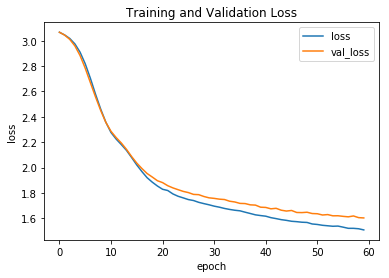

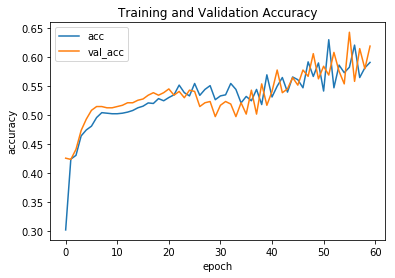

(271, 13)
[INFO] Before Preprocssing Y Labels ['VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP'
 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP'
 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP'
 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'FILE-TRANSFER' 'FILE-TRANSFER'
 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER'
 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER' 'P2P'
 'P2P' 'P2P' 'P2P' 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING'
 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING'
 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING'
 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING'
 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING'
 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'CHAT' 'CHAT'
 'CHAT' 'CHAT' 'CHAT' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP'
 'VOIP' 'VOIP' 'VOIP' 'VO

Train on 556 samples, validate on 239 samples
Epoch 1/60
556/556 [==============================] - 1s 902us/step - loss: 3.1160 - acc: 0.1025 - val_loss: 3.0359 - val_acc: 0.0879

Epoch 00001: val_acc improved from -inf to 0.08787, saving model to output/Labels/Dense/InfoGain/60s/logs/Dense_best.h5
Epoch 2/60
556/556 [==============================] - 0s 45us/step - loss: 3.1032 - acc: 0.4514 - val_loss: 3.0256 - val_acc: 0.4770

Epoch 00002: val_acc improved from 0.08787 to 0.47699, saving model to output/Labels/Dense/InfoGain/60s/logs/Dense_best.h5
Epoch 3/60
556/556 [==============================] - 0s 52us/step - loss: 3.0910 - acc: 0.4838 - val_loss: 3.0145 - val_acc: 0.4686

Epoch 00003: val_acc did not improve from 0.47699
Epoch 4/60
556/556 [==============================] - 0s 44us/step - loss: 3.0780 - acc: 0.4712 - val_loss: 3.0016 - val_acc: 0.4477

Epoch 00004: val_acc did not improve from 0.47699
Epoch 5/60
556/556 [==============================] - 0s 51us/step - loss:

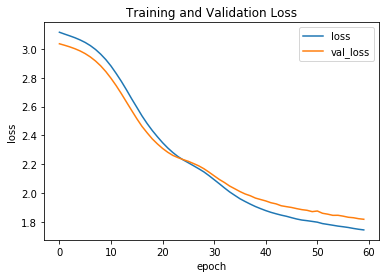

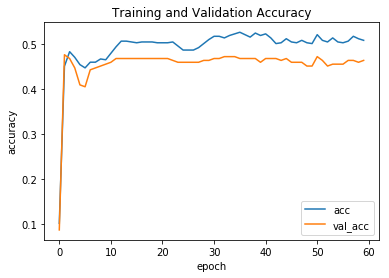

(120, 13)
[INFO] Before Preprocssing Y Labels ['FILE-TRANSFER' 'FILE-TRANSFER' 'AUDIO-STREAMING' 'AUDIO-STREAMING'
 'AUDIO-STREAMING' 'P2P' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP'
 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'CHAT'
 'CHAT' 'CHAT' 'CHAT' 'BROWSING' 'BROWSING' 'BROWSING' 'BROWSING'
 'BROWSING' 'BROWSING' 'BROWSING' 'BROWSING' 'BROWSING' 'CHAT' 'CHAT'
 'CHAT' 'EMAIL' 'EMAIL' 'EMAIL' 'CHAT' 'CHAT' 'EMAIL' 'EMAIL' 'EMAIL'
 'EMAIL' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP'
 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER' 'VOIP' 'VOIP' 'VOIP'
 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VIDEO-STREAMING' 'VIDEO-STREAMING'
 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'VIDEO-STREAMING' 'FILE-TRANSFER'
 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER'
 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER' 'FILE-TRANSFER'
 'BROWSING' 'BROWSING' 'BROWSING' 'BROWSING' 'BROWSING' 'BROWSING' 'CHAT'
 'CHAT' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VOIP' 'VIDEO-ST

IOError: [Errno 2] No such file or directory: 'CSV/Scenario-B/TimeBasedFeatures-120s-Layer2-85.arff'

In [15]:
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
                log_file = os.path.join(log_dir, 'training.csv')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                cpt_last = os.path.join(log_dir, '{}_last.h5'.format(ARCHITECTURE))
                output_dirs = [OUTPUT_DIR,mdl_dir, log_dir, cpt_dir]
                output_dirs = [directory for directory in output_dirs if directory is not None]
                #Create Directories
                for directory in output_dirs:
                    if not os.path.isdir(directory):
                        os.makedirs(directory)
                    elif len(glob.glob(os.path.join(directory, '*.*'))) > 0:
                        print('[INFO] Output directory {} must be empty'.format(directory))
                
                #Get Training Data 
                x_train, y_train = getTrainData(DataSetDuration,DATASET_ID)
                print('[INFO] Y TRAIN Shape is ]{}'.format(y_train.shape))
                print('[INFO] X TRAIN Shape is ]{}'.format(x_train.shape))
                #Architectures = ['Dense','CNN']
                if ARCHITECTURE != 'Dense':
                    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1).astype( 'float32' )
                    model = cnnModel(x_train.shape[1] ,y_train.shape[1])
                    print('X TRAIN Shape is after Reshaping For CNN ]{}'.format(x_train.shape))
                else:
                     model = denseModel(x_train.shape[1] ,y_train.shape[1])
                model.summary()
                # Split Data
                x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.30, shuffle= True)                
                # serialize models to json
                model_train_json = model.to_json()
                with open(mdl_train_file, 'w') as file:
                    file.write(model_train_json)
                
                checkpoints = callbacks(log_file,cpt_best,cpt_last)
                Epochs = 40
                if DATASET_ID == 'Labels':
                    Epochs = 60 
                history = model.fit(x_train, y_train,
                     epochs=Epochs,
                     validation_data=(x_valid,y_valid),
                     shuffle=True,
                     callbacks=checkpoints,
                     batch_size= 64)
                plot(history,log_dir)
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                if ARCHITECTURE != 'Dense':
                    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype( 'float32' )
                t = time.time()
                results = model.evaluate(x_test, y_test)
                print('[INFO] Predition Total time: {}'.format( (time.time() - t)/60))
                print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)

[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(18761, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 250)               3500      
_________________________________________________________________
dense_41 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_42 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 502       
Total params: 12

Epoch 34/40
13132/13132 [==============================] - 1s 61us/step - loss: 0.0052 - acc: 0.9986 - val_loss: 0.0072 - val_acc: 0.9991

Epoch 00034: val_acc did not improve from 0.99911
Epoch 35/40
13132/13132 [==============================] - 1s 77us/step - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0098 - val_acc: 0.9989

Epoch 00035: val_acc did not improve from 0.99911
Epoch 36/40
13132/13132 [==============================] - 1s 62us/step - loss: 0.0051 - acc: 0.9988 - val_loss: 0.0074 - val_acc: 0.9991

Epoch 00036: val_acc did not improve from 0.99911
Epoch 37/40
13132/13132 [==============================] - 1s 55us/step - loss: 0.0049 - acc: 0.9989 - val_loss: 0.0074 - val_acc: 0.9989

Epoch 00037: val_acc did not improve from 0.99911
Epoch 38/40
13132/13132 [==============================] - 1s 55us/step - loss: 0.0049 - acc: 0.9991 - val_loss: 0.0068 - val_acc: 0.9991

Epoch 00038: val_acc did not improve from 0.99911
Epoch 39/40
13132/13132 [==============================

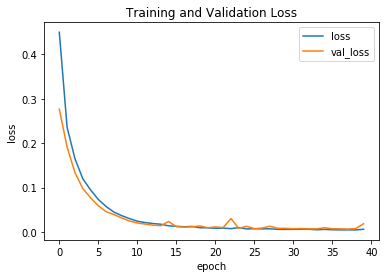

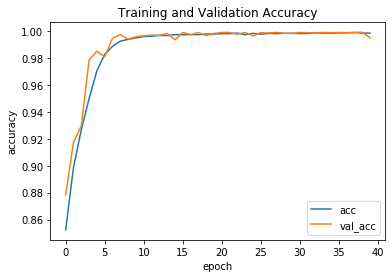

(3311, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 0s 26us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:15s
TEST LOSS, TEST ACCURACY: [2.143722544564178, 0.7227423739051646]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13958, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 250)               3500      
__

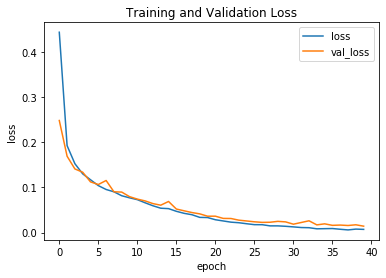

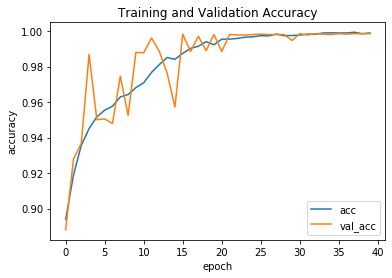

(2464, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2464/2464 [==============================] - 0s 28us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:30s
TEST LOSS, TEST ACCURACY: [0.904519118658928, 0.9391233766233766]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13964, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13964, 2)
[INFO] X TRAIN Shape is ](13964, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 250)               3500      
__

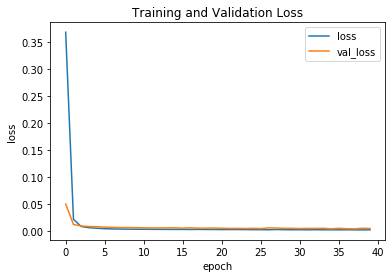

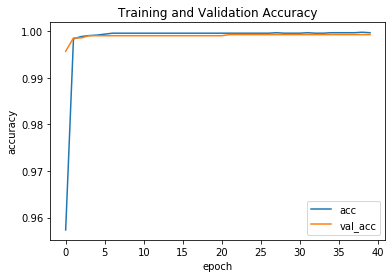

(2465, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2465/2465 [==============================] - 0s 27us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:60s
TEST LOSS, TEST ACCURACY: [0.012011509596239117, 0.9987829614604462]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(9564, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](9564, 2)
[INFO] X TRAIN Shape is ](9564, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 250)               3500      
_

6694/6694 [==============================] - 0s 69us/step - loss: 0.0375 - acc: 0.9833 - val_loss: 0.0424 - val_acc: 0.9826

Epoch 00031: val_acc did not improve from 0.98258
Epoch 32/40
6694/6694 [==============================] - 0s 55us/step - loss: 0.0370 - acc: 0.9846 - val_loss: 0.0404 - val_acc: 0.9826

Epoch 00032: val_acc did not improve from 0.98258
Epoch 33/40
6694/6694 [==============================] - 0s 57us/step - loss: 0.0374 - acc: 0.9839 - val_loss: 0.0400 - val_acc: 0.9826

Epoch 00033: val_acc did not improve from 0.98258
Epoch 34/40
6694/6694 [==============================] - 0s 55us/step - loss: 0.0370 - acc: 0.9840 - val_loss: 0.0397 - val_acc: 0.9826

Epoch 00034: val_acc did not improve from 0.98258
Epoch 35/40
6694/6694 [==============================] - 1s 80us/step - loss: 0.0360 - acc: 0.9837 - val_loss: 0.0404 - val_acc: 0.9826

Epoch 00035: val_acc did not improve from 0.98258
Epoch 36/40
6694/6694 [==============================] - 0s 56us/step - loss:

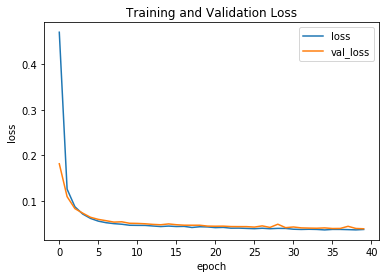

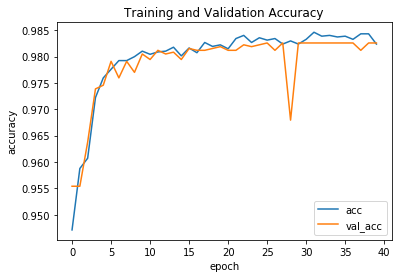

(1688, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
1688/1688 [==============================] - 0s 32us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:InfoGain DataSetDuration:120s
TEST LOSS, TEST ACCURACY: [0.04920295137669515, 0.9840047393364929]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(18761, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 250)               3750    


Epoch 00030: val_acc did not improve from 0.99858
Epoch 31/40
13132/13132 [==============================] - 1s 58us/step - loss: 0.0073 - acc: 0.9989 - val_loss: 0.0139 - val_acc: 0.9986

Epoch 00031: val_acc did not improve from 0.99858
Epoch 32/40
13132/13132 [==============================] - 1s 57us/step - loss: 0.0057 - acc: 0.9992 - val_loss: 0.0097 - val_acc: 0.9986

Epoch 00032: val_acc did not improve from 0.99858
Epoch 33/40
13132/13132 [==============================] - 1s 54us/step - loss: 0.0063 - acc: 0.9992 - val_loss: 0.0129 - val_acc: 0.9986

Epoch 00033: val_acc did not improve from 0.99858
Epoch 34/40
13132/13132 [==============================] - 1s 53us/step - loss: 0.0059 - acc: 0.9992 - val_loss: 0.0097 - val_acc: 0.9986

Epoch 00034: val_acc did not improve from 0.99858
Epoch 35/40
13132/13132 [==============================] - 1s 54us/step - loss: 0.0078 - acc: 0.9985 - val_loss: 0.0183 - val_acc: 0.9982

Epoch 00035: val_acc did not improve from 0.99858
Epoc

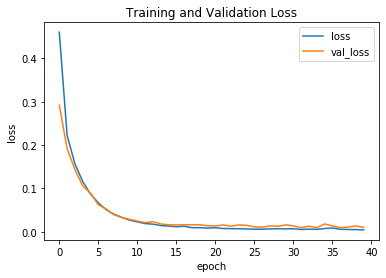

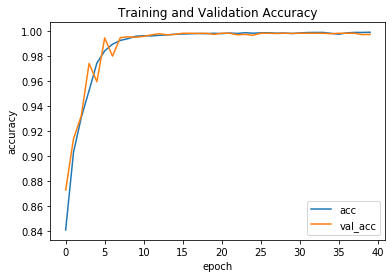

(3311, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 0s 28us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:15s
TEST LOSS, TEST ACCURACY: [3.2477865598667206, 0.642706131078224]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(13958, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 250)               3750    

Epoch 32/40
9770/9770 [==============================] - 1s 54us/step - loss: 0.0123 - acc: 0.9985 - val_loss: 0.0207 - val_acc: 0.9909

Epoch 00032: val_acc did not improve from 0.99928
Epoch 33/40
9770/9770 [==============================] - 1s 54us/step - loss: 0.0128 - acc: 0.9981 - val_loss: 0.0095 - val_acc: 0.9986

Epoch 00033: val_acc did not improve from 0.99928
Epoch 34/40
9770/9770 [==============================] - 1s 57us/step - loss: 0.0099 - acc: 0.9992 - val_loss: 0.0099 - val_acc: 0.9993

Epoch 00034: val_acc did not improve from 0.99928
Epoch 35/40
9770/9770 [==============================] - 1s 56us/step - loss: 0.0104 - acc: 0.9984 - val_loss: 0.0081 - val_acc: 0.9990

Epoch 00035: val_acc did not improve from 0.99928
Epoch 36/40
9770/9770 [==============================] - 1s 53us/step - loss: 0.0097 - acc: 0.9991 - val_loss: 0.0099 - val_acc: 0.9993

Epoch 00036: val_acc did not improve from 0.99928
Epoch 37/40
9770/9770 [==============================] - 1s 56us/

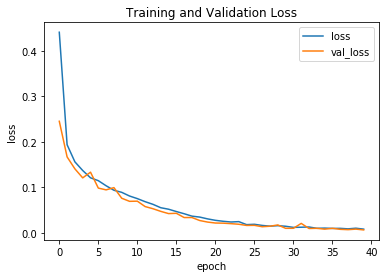

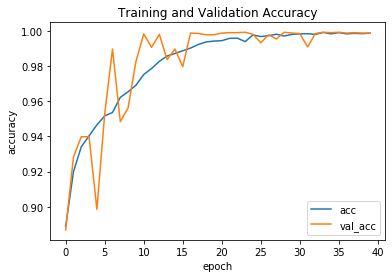

(2464, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2464/2464 [==============================] - 0s 30us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:30s
TEST LOSS, TEST ACCURACY: [0.9194199529948791, 0.9391233766233766]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(13964, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13964, 2)
[INFO] X TRAIN Shape is ](13964, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 250)               3750   

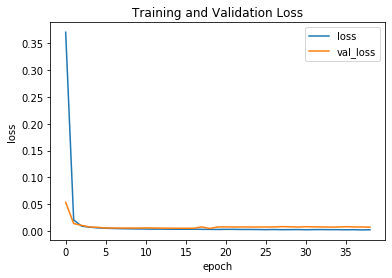

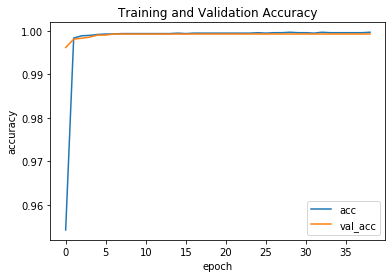

(2465, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2465/2465 [==============================] - 0s 36us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:60s
TEST LOSS, TEST ACCURACY: [0.015780383855123623, 0.9983772819472616]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(9564, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](9564, 2)
[INFO] X TRAIN Shape is ](9564, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 250)               3750   

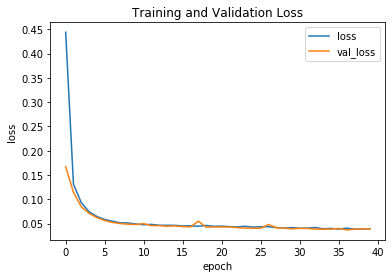

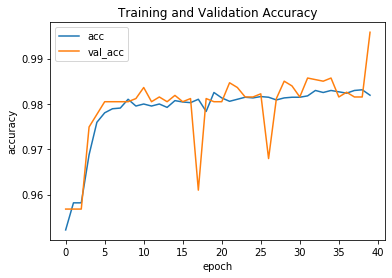

(1688, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
1688/1688 [==============================] - 0s 26us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:Dense Method:Correlation DataSetDuration:120s
TEST LOSS, TEST ACCURACY: [0.03550841111211058, 0.9840047393364929]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(18761, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 13, 128)           512    

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 2/40
13132/13132 [==============================] - 9s 652us/step - loss: nan - acc: 0.8514 - val_loss: nan - val_acc: 0.8495

Epoch 00002: val_acc did not improve from 0.84953
Epoch 3/40
13132/13132 [==============================] - 9s 660us/step - loss: nan - acc: 0.8514 - val_loss: nan - val_acc: 0.8495

Epoch 00003: val_acc did not improve from 0.84953
Epoch 4/40
13132/13132 [==============================] - 8s 619us/step - loss: nan - acc: 0.8514 - val_loss: nan - val_acc: 0.8495

Epoch 00004: val_acc did not improve from 0.84953
Epoch 5/40
13132/13132 [==============================] - 8s 622us/step - loss: nan - acc: 0.8514 - val_loss: nan - val_acc: 0.8495

Epoch 00005: val_acc did not improve from 0.84953
Epoch 6/40
13132/13132 [==============================] - 8s 614us/step - loss: nan - acc: 0.8514 - val_loss: nan - val_acc: 0.8495

Epoch 00006: val_acc did not improve from 0.84953
Epoch 7/40
13132/13132 [==============================] - 8s 620us/step - loss: nan -

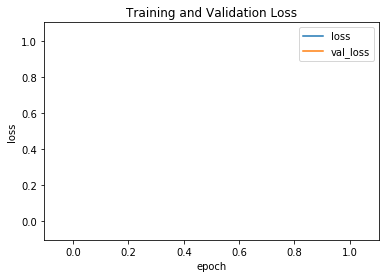

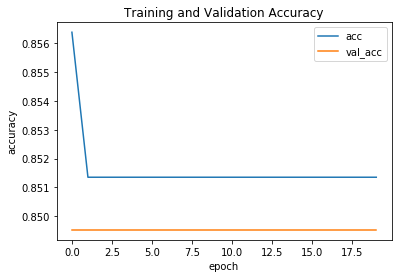

(3311, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 1s 283us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:InfoGain DataSetDuration:15s
TEST LOSS, TEST ACCURACY: [nan, 0.8444578677136817]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13958, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 13, 128)           512       
_________________

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


9770/9770 [==============================] - 7s 690us/step - loss: nan - acc: 0.8928 - val_loss: nan - val_acc: 0.8904

Epoch 00003: val_acc did not improve from 0.91643
Epoch 4/40
9770/9770 [==============================] - 7s 678us/step - loss: nan - acc: 0.8928 - val_loss: nan - val_acc: 0.8904

Epoch 00004: val_acc did not improve from 0.91643
Epoch 5/40
9770/9770 [==============================] - 7s 684us/step - loss: nan - acc: 0.8928 - val_loss: nan - val_acc: 0.8904

Epoch 00005: val_acc did not improve from 0.91643
Epoch 6/40
9770/9770 [==============================] - 7s 681us/step - loss: nan - acc: 0.8928 - val_loss: nan - val_acc: 0.8904

Epoch 00006: val_acc did not improve from 0.91643
Epoch 7/40
9770/9770 [==============================] - 7s 677us/step - loss: nan - acc: 0.8928 - val_loss: nan - val_acc: 0.8904

Epoch 00007: val_acc did not improve from 0.91643
Epoch 8/40
9770/9770 [==============================] - 6s 633us/step - loss: nan - acc: 0.8928 - val_loss

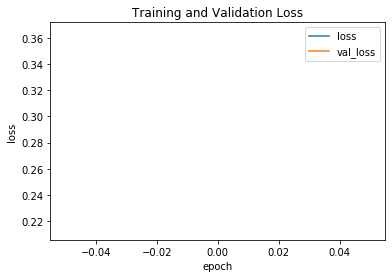

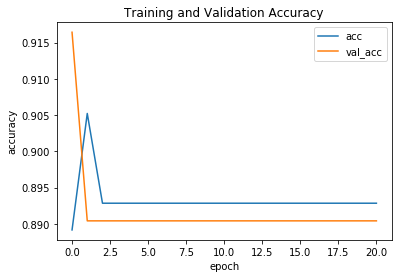

(2464, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2464/2464 [==============================] - 1s 358us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:InfoGain DataSetDuration:30s
TEST LOSS, TEST ACCURACY: [nan, 0.8924512987012987]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(13964, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13964, 2)
[INFO] X TRAIN Shape is ](13964, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 13, 128)           512       
_________________

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


9774/9774 [==============================] - 6s 648us/step - loss: nan - acc: 0.9439 - val_loss: nan - val_acc: 0.9451

Epoch 00003: val_acc did not improve from 0.99809
Epoch 4/40
9774/9774 [==============================] - 6s 634us/step - loss: nan - acc: 0.9439 - val_loss: nan - val_acc: 0.9451

Epoch 00004: val_acc did not improve from 0.99809
Epoch 5/40
9774/9774 [==============================] - 6s 639us/step - loss: nan - acc: 0.9439 - val_loss: nan - val_acc: 0.9451

Epoch 00005: val_acc did not improve from 0.99809
Epoch 6/40
9774/9774 [==============================] - 6s 650us/step - loss: nan - acc: 0.9439 - val_loss: nan - val_acc: 0.9451

Epoch 00006: val_acc did not improve from 0.99809
Epoch 7/40
9774/9774 [==============================] - 6s 648us/step - loss: nan - acc: 0.9439 - val_loss: nan - val_acc: 0.9451

Epoch 00007: val_acc did not improve from 0.99809
Epoch 8/40
9774/9774 [==============================] - 6s 664us/step - loss: nan - acc: 0.9439 - val_loss

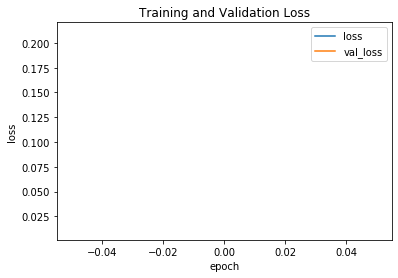

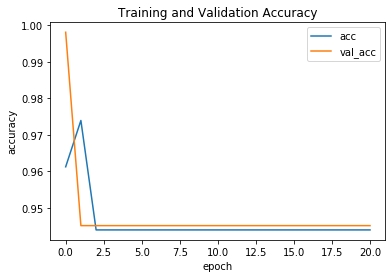

(2465, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2465/2465 [==============================] - 1s 296us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:InfoGain DataSetDuration:60s
TEST LOSS, TEST ACCURACY: [nan, 0.9448275862068966]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff
[INFO] Data loaded for info Gain
(9564, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](9564, 2)
[INFO] X TRAIN Shape is ](9564, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 13, 128)           512       
___________________

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


6694/6694 [==============================] - 4s 662us/step - loss: nan - acc: 0.9577 - val_loss: nan - val_acc: 0.9578

Epoch 00008: val_acc did not improve from 0.97909
Epoch 9/40
6694/6694 [==============================] - 4s 647us/step - loss: nan - acc: 0.9577 - val_loss: nan - val_acc: 0.9578

Epoch 00009: val_acc did not improve from 0.97909
Epoch 10/40
6694/6694 [==============================] - 4s 649us/step - loss: nan - acc: 0.9577 - val_loss: nan - val_acc: 0.9578

Epoch 00010: val_acc did not improve from 0.97909
Epoch 11/40
6694/6694 [==============================] - 4s 668us/step - loss: nan - acc: 0.9577 - val_loss: nan - val_acc: 0.9578

Epoch 00011: val_acc did not improve from 0.97909
Epoch 12/40
6694/6694 [==============================] - 4s 649us/step - loss: nan - acc: 0.9577 - val_loss: nan - val_acc: 0.9578

Epoch 00012: val_acc did not improve from 0.97909
Epoch 13/40
6694/6694 [==============================] - 4s 643us/step - loss: nan - acc: 0.9577 - val_

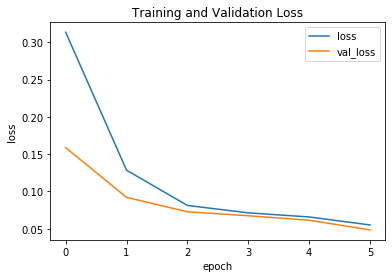

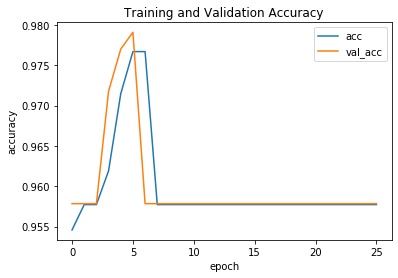

(1688, 13)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
1688/1688 [==============================] - 0s 288us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:InfoGain DataSetDuration:120s
TEST LOSS, TEST ACCURACY: [nan, 0.9609004739336493]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-15s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(18761, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](18761, 2)
[INFO] X TRAIN Shape is ](18761, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 14, 128)           512       
______________

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


13132/13132 [==============================] - 9s 713us/step - loss: nan - acc: 0.8534 - val_loss: nan - val_acc: 0.8447

Epoch 00003: val_acc did not improve from 0.88897
Epoch 4/40
13132/13132 [==============================] - 9s 697us/step - loss: nan - acc: 0.8534 - val_loss: nan - val_acc: 0.8447

Epoch 00004: val_acc did not improve from 0.88897
Epoch 5/40
13132/13132 [==============================] - 9s 697us/step - loss: nan - acc: 0.8534 - val_loss: nan - val_acc: 0.8447

Epoch 00005: val_acc did not improve from 0.88897
Epoch 6/40
13132/13132 [==============================] - 9s 698us/step - loss: nan - acc: 0.8534 - val_loss: nan - val_acc: 0.8447

Epoch 00006: val_acc did not improve from 0.88897
Epoch 7/40
13132/13132 [==============================] - 9s 692us/step - loss: nan - acc: 0.8534 - val_loss: nan - val_acc: 0.8447

Epoch 00007: val_acc did not improve from 0.88897
Epoch 8/40
13132/13132 [==============================] - 9s 713us/step - loss: nan - acc: 0.853

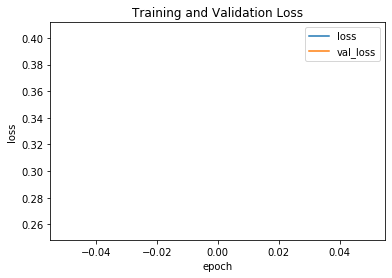

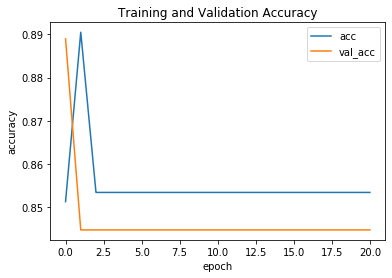

(3311, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
3311/3311 [==============================] - 1s 327us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:Correlation DataSetDuration:15s
TEST LOSS, TEST ACCURACY: [nan, 0.8444578677136817]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-30s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(13958, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13958, 2)
[INFO] X TRAIN Shape is ](13958, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 14, 128)           512       
____________

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


9770/9770 [==============================] - 7s 700us/step - loss: nan - acc: 0.8908 - val_loss: nan - val_acc: 0.8952

Epoch 00005: val_acc did not improve from 0.93123
Epoch 6/40
9770/9770 [==============================] - 7s 695us/step - loss: nan - acc: 0.8908 - val_loss: nan - val_acc: 0.8952

Epoch 00006: val_acc did not improve from 0.93123
Epoch 7/40
9770/9770 [==============================] - 7s 703us/step - loss: nan - acc: 0.8908 - val_loss: nan - val_acc: 0.8952

Epoch 00007: val_acc did not improve from 0.93123
Epoch 8/40
9770/9770 [==============================] - 7s 701us/step - loss: nan - acc: 0.8908 - val_loss: nan - val_acc: 0.8952

Epoch 00008: val_acc did not improve from 0.93123
Epoch 9/40
9770/9770 [==============================] - 7s 727us/step - loss: nan - acc: 0.8908 - val_loss: nan - val_acc: 0.8952

Epoch 00009: val_acc did not improve from 0.93123
Epoch 10/40
9770/9770 [==============================] - 7s 719us/step - loss: nan - acc: 0.8908 - val_los

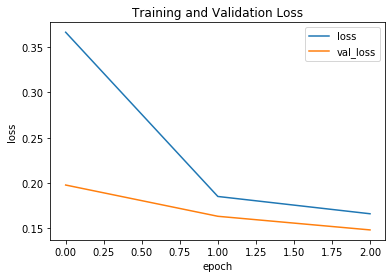

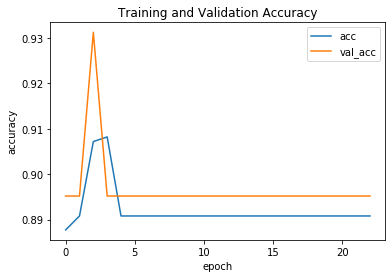

(2464, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2464/2464 [==============================] - 1s 321us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:Correlation DataSetDuration:30s
TEST LOSS, TEST ACCURACY: [nan, 0.8924512987012987]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-60s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(13964, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](13964, 2)
[INFO] X TRAIN Shape is ](13964, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 14, 128)           512       
____________

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


9774/9774 [==============================] - 7s 733us/step - loss: nan - acc: 0.9456 - val_loss: nan - val_acc: 0.9413

Epoch 00010: val_acc did not improve from 1.00000
Epoch 11/40
9774/9774 [==============================] - 7s 730us/step - loss: nan - acc: 0.9456 - val_loss: nan - val_acc: 0.9413

Epoch 00011: val_acc did not improve from 1.00000
Epoch 12/40
9774/9774 [==============================] - 7s 747us/step - loss: nan - acc: 0.9456 - val_loss: nan - val_acc: 0.9413

Epoch 00012: val_acc did not improve from 1.00000
Epoch 13/40
9774/9774 [==============================] - 7s 764us/step - loss: nan - acc: 0.9456 - val_loss: nan - val_acc: 0.9413

Epoch 00013: val_acc did not improve from 1.00000
Epoch 14/40
9774/9774 [==============================] - 7s 756us/step - loss: nan - acc: 0.9456 - val_loss: nan - val_acc: 0.9413

Epoch 00014: val_acc did not improve from 1.00000
Epoch 15/40
9774/9774 [==============================] - 7s 732us/step - loss: nan - acc: 0.9456 - val

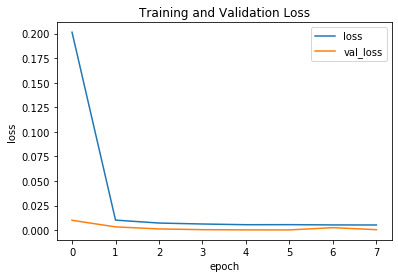

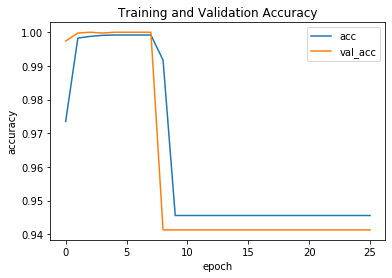

(2465, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
2465/2465 [==============================] - 1s 327us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:Correlation DataSetDuration:60s
TEST LOSS, TEST ACCURACY: [nan, 0.9448275862068966]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-A/TimeBasedFeatures-120s-TOR-NonTOR-85.arff
[INFO] Data loaded for Correlation
(9564, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[INFO] Y TRAIN Shape is ](9564, 2)
[INFO] X TRAIN Shape is ](9564, 14)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 14, 128)           512       
______________

C:\Users\Mohsin Sharif\Anaconda3\lib\site-packages\keras\callbacks.py:543: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


6694/6694 [==============================] - 5s 736us/step - loss: nan - acc: 0.9609 - val_loss: nan - val_acc: 0.9505

Epoch 00016: val_acc did not improve from 0.97561
Epoch 17/40
6694/6694 [==============================] - 5s 731us/step - loss: nan - acc: 0.9609 - val_loss: nan - val_acc: 0.9505

Epoch 00017: val_acc did not improve from 0.97561
Epoch 18/40
6694/6694 [==============================] - 5s 752us/step - loss: nan - acc: 0.9609 - val_loss: nan - val_acc: 0.9505

Epoch 00018: val_acc did not improve from 0.97561
Epoch 19/40
6694/6694 [==============================] - 5s 757us/step - loss: nan - acc: 0.9609 - val_loss: nan - val_acc: 0.9505

Epoch 00019: val_acc did not improve from 0.97561
Epoch 20/40
6694/6694 [==============================] - 5s 747us/step - loss: nan - acc: 0.9609 - val_loss: nan - val_acc: 0.9505

Epoch 00020: val_acc did not improve from 0.97561
Epoch 21/40
6694/6694 [==============================] - 5s 743us/step - loss: nan - acc: 0.9609 - val

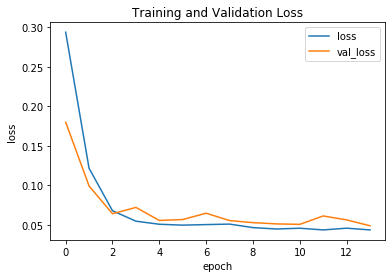

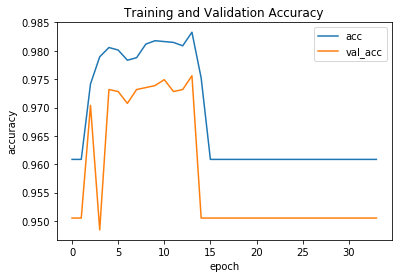

(1688, 14)
[INFO] Before Preprocssing Y Labels [b'NONTOR' b'NONTOR' b'NONTOR' ... b'TOR' b'TOR' b'TOR']
[INFO] After Preprocssing Y Labels [[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
1688/1688 [==============================] - 1s 332us/step
[INFO ]TESTING RESULTS FOR Data:TorVsNonTor Architecture:CNN Method:Correlation DataSetDuration:120s
TEST LOSS, TEST ACCURACY: [nan, 0.9609004739336493]
[INFO] PATH FOR LOADED DATASET: DataSet/CSV/Scenario-B/TimeBasedFeatures-15s-Layer2-85.arff
[INFO] Data loaded for info Gain
(2856, 13)
[INFO] Before Preprocssing Y Labels [b'CHAT' b'VIDEO-STREAMING' b'CHAT' ... b'VOIP' b'VOIP' b'VOIP']
[INFO] After Preprocssing Y Labels [[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
[INFO] Y TRAIN Shape is ](2856, 10)
[INFO] X TRAIN Shape is ](2856, 13)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense

Epoch 30/60
1999/1999 [==============================] - 0s 75us/step - loss: 1.6047 - acc: 0.5873 - val_loss: 1.6382 - val_acc: 0.5729

Epoch 00030: val_acc did not improve from 0.60793
Epoch 31/60
1999/1999 [==============================] - 0s 80us/step - loss: 1.5947 - acc: 0.5803 - val_loss: 1.6413 - val_acc: 0.5706

Epoch 00031: val_acc did not improve from 0.60793
Epoch 32/60
1999/1999 [==============================] - 0s 73us/step - loss: 1.5916 - acc: 0.5888 - val_loss: 1.6301 - val_acc: 0.5648

Epoch 00032: val_acc did not improve from 0.60793
Epoch 33/60
1999/1999 [==============================] - 0s 82us/step - loss: 1.5884 - acc: 0.5843 - val_loss: 1.6325 - val_acc: 0.5869

Epoch 00033: val_acc did not improve from 0.60793
Epoch 34/60
1999/1999 [==============================] - 0s 89us/step - loss: 1.5860 - acc: 0.5828 - val_loss: 1.6256 - val_acc: 0.6033

Epoch 00034: val_acc did not improve from 0.60793
Epoch 35/60
1999/1999 [==============================] - 0s 83us/

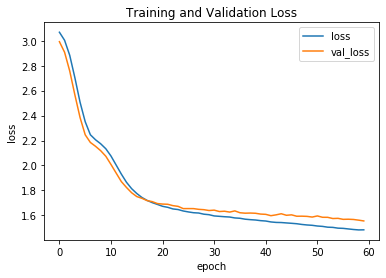

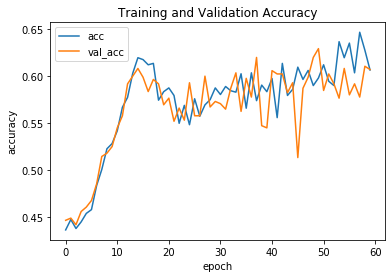

(504, 13)
[INFO] Before Preprocssing Y Labels [b'CHAT' b'VIDEO-STREAMING' b'CHAT' b'VOIP' b'VOIP' b'CHAT'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'CHAT' b'VOIP' b'VIDEO-STREAMING'
 b'CHAT' b'P2P' b'CHAT' b'EMAIL' b'VOIP' b'VOIP' b'VIDEO-STREAMING'
 b'CHAT' b'CHAT' b'VIDEO-STREAMING' b'FILE-TRANSFER' b'VIDEO-STREAMING'
 b'CHAT' b'FILE-TRANSFER' b'P2P' b'EMAIL' b'CHAT' b'CHAT' b'CHAT' b'EMAIL'
 b'P2P' b'EMAIL' b'CHAT' b'CHAT' b'P2P' b'CHAT' b'EMAIL' b'FILE-TRANSFER'
 b'VOIP' b'CHAT' b'VOIP' b'FILE-TRANSFER' b'VOIP' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'CHAT' b'CHAT' b'P2P' b'P2P' b'VOIP' b'CHAT'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'VOIP' b'EMAIL'
 b'EMAIL' b'VOIP' b'VOIP' b'P2P' b'EMAIL' b'FILE-TRANSFER' b'BROWSING'
 b'FILE-TRANSFER' b'EMAIL' b'BROWSING' b'BROWSING' b'VIDEO-STREAMING'
 b'EMAIL' b'FILE-TRANSFER' b'VIDEO-STREAMING' b'FILE-TRANSFER'
 b'VIDEO-STREAMING' b'P2P' b'VOIP' b'BROWSING' b'VOIP' b'VOIP'
 b'FILE-TRANSFER' b'P2P' b'VOIP' b'FILE-TRANSFER' b'VIDEO-STREAM

Epoch 3/60
1072/1072 [==============================] - 0s 93us/step - loss: 3.0348 - acc: 0.4916 - val_loss: 2.9905 - val_acc: 0.5261

Epoch 00003: val_acc improved from 0.52174 to 0.52609, saving model to output/Labels/Dense/InfoGain/30s\logs\Dense_best.h5
Epoch 4/60
1072/1072 [==============================] - 0s 101us/step - loss: 2.9965 - acc: 0.4935 - val_loss: 2.9432 - val_acc: 0.5261

Epoch 00004: val_acc did not improve from 0.52609
Epoch 5/60
1072/1072 [==============================] - 0s 101us/step - loss: 2.9410 - acc: 0.4935 - val_loss: 2.8747 - val_acc: 0.5261

Epoch 00005: val_acc did not improve from 0.52609
Epoch 6/60
1072/1072 [==============================] - 0s 94us/step - loss: 2.8640 - acc: 0.4935 - val_loss: 2.7861 - val_acc: 0.5261

Epoch 00006: val_acc did not improve from 0.52609
Epoch 7/60
1072/1072 [==============================] - 0s 90us/step - loss: 2.7683 - acc: 0.4935 - val_loss: 2.6839 - val_acc: 0.5261

Epoch 00007: val_acc did not improve from 0.5

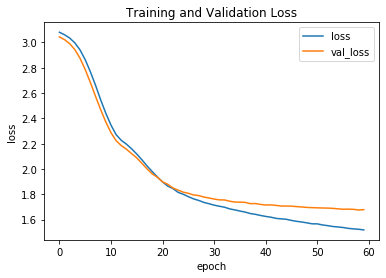

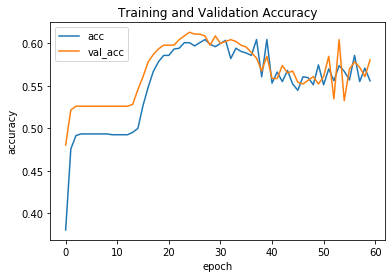

(271, 13)
[INFO] Before Preprocssing Y Labels [b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'P2P' b'P2P' b'P2P' b'P2P'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'CHAT' b'CHAT' b'CHAT' b'CHAT' b'C

Train on 556 samples, validate on 239 samples
Epoch 1/60
556/556 [==============================] - 3s 5ms/step - loss: 3.0866 - acc: 0.2338 - val_loss: 3.1030 - val_acc: 0.5188

Epoch 00001: val_acc improved from -inf to 0.51883, saving model to output/Labels/Dense/InfoGain/60s\logs\Dense_best.h5
Epoch 2/60
556/556 [==============================] - 0s 101us/step - loss: 3.0738 - acc: 0.5306 - val_loss: 3.0909 - val_acc: 0.4937

Epoch 00002: val_acc did not improve from 0.51883
Epoch 3/60
556/556 [==============================] - 0s 90us/step - loss: 3.0607 - acc: 0.5144 - val_loss: 3.0788 - val_acc: 0.4854

Epoch 00003: val_acc did not improve from 0.51883
Epoch 4/60
556/556 [==============================] - 0s 79us/step - loss: 3.0467 - acc: 0.5126 - val_loss: 3.0646 - val_acc: 0.4937

Epoch 00004: val_acc did not improve from 0.51883
Epoch 5/60
556/556 [==============================] - 0s 90us/step - loss: 3.0297 - acc: 0.5108 - val_loss: 3.0474 - val_acc: 0.4895

Epoch 00005: v

Epoch 42/60
556/556 [==============================] - 0s 79us/step - loss: 1.7862 - acc: 0.5701 - val_loss: 2.0259 - val_acc: 0.5774

Epoch 00042: val_acc did not improve from 0.58159
Epoch 43/60
556/556 [==============================] - 0s 104us/step - loss: 1.7738 - acc: 0.5719 - val_loss: 2.0133 - val_acc: 0.5732

Epoch 00043: val_acc did not improve from 0.58159
Epoch 44/60
556/556 [==============================] - 0s 87us/step - loss: 1.7651 - acc: 0.5665 - val_loss: 2.0026 - val_acc: 0.5774

Epoch 00044: val_acc did not improve from 0.58159
Epoch 45/60
556/556 [==============================] - 0s 81us/step - loss: 1.7569 - acc: 0.5647 - val_loss: 1.9995 - val_acc: 0.5774

Epoch 00045: val_acc did not improve from 0.58159
Epoch 46/60
556/556 [==============================] - 0s 99us/step - loss: 1.7504 - acc: 0.5629 - val_loss: 1.9953 - val_acc: 0.5690

Epoch 00046: val_acc did not improve from 0.58159
Epoch 47/60
556/556 [==============================] - 0s 93us/step - loss

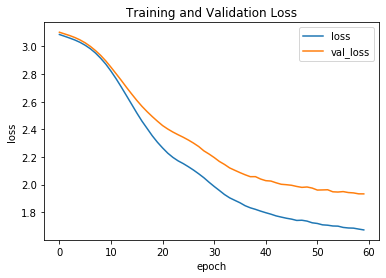

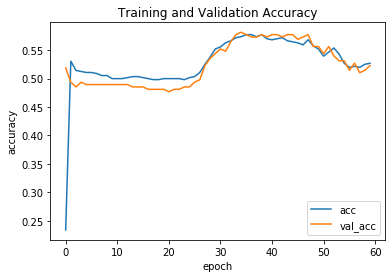

(120, 13)
[INFO] Before Preprocssing Y Labels [b'FILE-TRANSFER' b'FILE-TRANSFER' b'AUDIO-STREAMING' b'AUDIO-STREAMING'
 b'AUDIO-STREAMING' b'P2P' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'VOIP' b'CHAT' b'CHAT' b'CHAT' b'CHAT' b'BROWSING' b'BROWSING'
 b'BROWSING' b'BROWSING' b'BROWSING' b'BROWSING' b'BROWSING' b'BROWSING'
 b'BROWSING' b'CHAT' b'CHAT' b'CHAT' b'EMAIL' b'EMAIL' b'EMAIL' b'CHAT'
 b'CHAT' b'EMAIL' b'EMAIL' b'EMAIL' b'EMAIL' b'VOIP' b'VOIP' b'VOIP'
 b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'FILE-TRANSFER' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'FILE-TRANSFER' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'BROWSING'
 b'BROWSING' b'BROWSING' b'BROWSING' b'BR


Epoch 00043: val_acc did not improve from 0.65323
Epoch 44/60
289/289 [==============================] - 0s 97us/step - loss: 1.9072 - acc: 0.5398 - val_loss: 1.6674 - val_acc: 0.5806

Epoch 00044: val_acc did not improve from 0.65323
Epoch 45/60
289/289 [==============================] - 0s 100us/step - loss: 1.8921 - acc: 0.5363 - val_loss: 1.6555 - val_acc: 0.5806

Epoch 00045: val_acc did not improve from 0.65323
Epoch 46/60
289/289 [==============================] - 0s 100us/step - loss: 1.8794 - acc: 0.5052 - val_loss: 1.6476 - val_acc: 0.5726

Epoch 00046: val_acc did not improve from 0.65323
Epoch 47/60
289/289 [==============================] - 0s 90us/step - loss: 1.8673 - acc: 0.4879 - val_loss: 1.6390 - val_acc: 0.5806

Epoch 00047: val_acc did not improve from 0.65323
Epoch 48/60
289/289 [==============================] - 0s 107us/step - loss: 1.8557 - acc: 0.4983 - val_loss: 1.6326 - val_acc: 0.5806

Epoch 00048: val_acc did not improve from 0.65323
Epoch 49/60
289/289 [

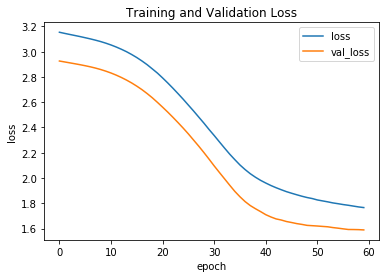

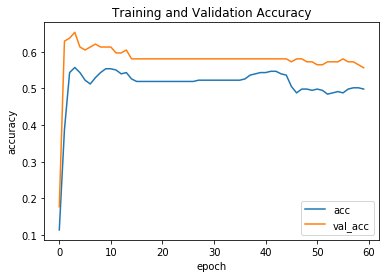

(73, 13)
[INFO] Before Preprocssing Y Labels [b'CHAT' b'CHAT' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'VOIP' b'EMAIL' b'EMAIL' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'FILE-TRANSFER' b'FILE-TRANSFER' b'VOIP' b'VOIP'
 b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'EMAIL' b'FILE-TRANSFER'
 b'FILE-TRANSFER' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'BROWSING'
 b'BROWSING' b'EMAIL' b'EMAIL' b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'CHAT'
 b'VOIP' b'VOIP' b'VOIP' b'VOIP' b'AUDIO-STREAMING' b'AUDIO-STREAMING'
 b'BROWSING' b'BROWSING' b'BROWSING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING' b'VIDEO-STREAMING'
 b'VIDEO-STREAMING' b'VIDEO-STREAMING']
[INFO] After Preprocssing Y Labels [[0 0 1 0 0 0 

ValueError: Error when checking target: expected dense_111 to have shape (10,) but got array with shape (9,)

In [8]:
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
                log_file = os.path.join(log_dir, 'training.csv')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                cpt_last = os.path.join(log_dir, '{}_last.h5'.format(ARCHITECTURE))
                output_dirs = [OUTPUT_DIR,mdl_dir, log_dir, cpt_dir]
                output_dirs = [directory for directory in output_dirs if directory is not None]
                #Create Directories
                for directory in output_dirs:
                    if not os.path.isdir(directory):
                        os.makedirs(directory)
                    elif len(glob.glob(os.path.join(directory, '*.*'))) > 0:
                        print('[INFO] Output directory {} must be empty'.format(directory))
                
                #Get Training Data 
                x_train, y_train = getTrainData(DataSetDuration,DATASET_ID)
                print('[INFO] Y TRAIN Shape is ]{}'.format(y_train.shape))
                print('[INFO] X TRAIN Shape is ]{}'.format(x_train.shape))
                #Architectures = ['Dense','CNN']
                if ARCHITECTURE != 'Dense':
                    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1).astype( 'float32' )
                    model = cnnModel(x_train.shape[1] ,y_train.shape[1])
                    print('X TRAIN Shape is after Reshaping For CNN ]{}'.format(x_train.shape))
                else:
                     model = denseModel(x_train.shape[1] ,y_train.shape[1])
                model.summary()
                # Split Data
                x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.30, shuffle= True)                
                # serialize models to json
                model_train_json = model.to_json()
                with open(mdl_train_file, 'w') as file:
                    file.write(model_train_json)
                
                checkpoints = callbacks(log_file,cpt_best,cpt_last)
                Epochs = 40
                if DATASET_ID == 'Labels':
                    Epochs = 60 
                history = model.fit(x_train, y_train,
                     epochs=Epochs,
                     validation_data=(x_valid,y_valid),
                     shuffle=True,
                     callbacks=checkpoints,
                     batch_size= 64)
                plot(history,log_dir)
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                if ARCHITECTURE != 'Dense':
                    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype( 'float32' )
                t = time.time()
                results = model.evaluate(x_test, y_test)
                print('[INFO] Predition Total time: {}'.format( (time.time() - t)/60))
                print('[INFO] Predition Total time: {}'.format(t - time()))
                print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)

In [87]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
for DATASET_ID in DATASET_IDs: # ['TorVsNonTor', 'Labels']
    for ARCHITECTURE in Architectures:# ['Dense','CNN']
        for method  in Methods:# ['InfoGain','Correlation']
            for DataSetDuration in DataSetDurations:
                OUTPUT_DIR = 'output/{}/{}/{}/{}'.format(DATASET_ID, ARCHITECTURE,method,DataSetDuration)
                # setup paths for model architectures
                mdl_dir = os.path.join(OUTPUT_DIR, 'models')
                mdl_train_file = os.path.join(mdl_dir, '{}_train.json'.format(ARCHITECTURE))
                # setup paths for callbacks
                log_dir = os.path.join(OUTPUT_DIR, 'logs')
                cpt_dir = os.path.join(OUTPUT_DIR, 'checkpoints')
                log_file = os.path.join(log_dir, 'training.csv')
                cpt_best = os.path.join(log_dir, '{}_best.h5'.format(ARCHITECTURE))
                cpt_last = os.path.join(log_dir, '{}_last.h5'.format(ARCHITECTURE))
                output_dirs = [OUTPUT_DIR,mdl_dir, log_dir, cpt_dir]
                output_dirs = [directory for directory in output_dirs if directory is not None]
                #Create Directories
                for directory in output_dirs:
                    if not os.path.isdir(directory):
                        os.makedirs(directory)
                    elif len(glob.glob(os.path.join(directory, '*.*'))) > 0:
                        print('[INFO] Output directory {} must be empty'.format(directory))
                
                #Get Training Data 
                x_train, y_train = getTrainData(DataSetDuration,DATASET_ID)
                print('[INFO] Y TRAIN Shape is ]{}'.format(y_train.shape))
                print('[INFO] X TRAIN Shape is ]{}'.format(x_train.shape))
                #Architectures = ['Dense','CNN']
                if ARCHITECTURE != 'Dense':
                    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1).astype( 'float32' )
                    model = cnnModel(x_train.shape[1] ,y_train.shape[1])
                    print('X TRAIN Shape is after Reshaping For CNN ]{}'.format(x_train.shape))
                else:
                     model = denseModel(x_train.shape[1] ,y_train.shape[1])
                model.summary()
                # Split Data
                x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.30, shuffle= True)                
                # serialize models to json
                model_train_json = model.to_json()
                with open(mdl_train_file, 'w') as file:
                    file.write(model_train_json)
                
                checkpoints = callbacks(log_file,cpt_best,cpt_last)
                Epochs = 40
                if DATASET_ID == 'Labels':
                    Epochs = 60 
                history = model.fit(x_train, y_train,
                     epochs=Epochs,
                     validation_data=(x_valid,y_valid),
                     shuffle=True,
                     callbacks=checkpoints,
                     batch_size= 64)
                plot(history,log_dir)
                models.append(model)
                x_test, y_test = getTestData(DataSetDuration,DATASET_ID)
                results = model.evaluate(x_test, y_test)
                print('[INFO ]TESTING RESULTS FOR Data:{} Architecture:{} Method:{} DataSetDuration:{}'.format(DATASET_ID,ARCHITECTURE,method,DataSetDuration))
                print('TEST LOSS, TEST ACCURACY:', results)

In [ ]:
def plot(train_history,log_dir):
    # plot training and validation loss
    pyplot.figure()
    pyplot.plot([], label='loss')
    pyplot.plot([], label='val_loss')
    pyplot.title('Testing Loss')
    pyplot.xlabel('Time')
    pyplot.ylabel('loss')
    pyplot.legend()
    pyplot.savefig(os.path.join(log_dir, 'loss.png'))
    pyplot.show(block=False)
    
    # plot training and validation accuracy
    pyplot.figure()
    pyplot.plot(train_history.history['acc'],
                                      label='acc')
    pyplot.plot(train_history.history['val_acc'],
                                      label='val_acc')
    pyplot.title('Training and Validation Accuracy')
    pyplot.xlabel('epoch')
    pyplot.ylabel('accuracy')
    pyplot.legend()
    pyplot.savefig(os.path.join(log_dir, 'accuracy.png'))
    pyplot.show(block=False)
    

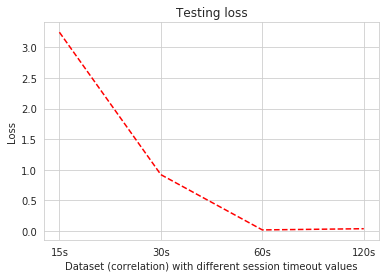

In [100]:
#Correlations
import matplotlib.pyplot as plt
plt.plot(['15s','30s','60s','120s'], [3.2477865598667206,0.9194199529948791,0.015780383855123623,0.03550841111211058], 'r--', label='loss')
plt.title('Testing loss')
plt.xlabel('Dataset (correlation) with different session timeout values')
plt.ylabel('Loss')
#plt.axis([-1, 4, -0.5, 3.5])
plt.show()

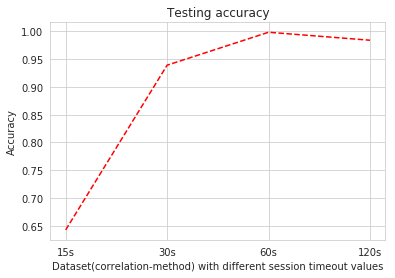

In [102]:
plt.plot(['15s','30s','60s','120s'], [0.642706131078224,0.9391233766233766,0.9983772819472616,0.9840047393364929], 'r--', label='loss')
plt.title('Testing accuracy')
plt.xlabel('Dataset(correlation-method) with different session timeout values')
plt.ylabel('Accuracy')
#plt.axis([-1, 4, 0.0, 1.0])
plt.show()

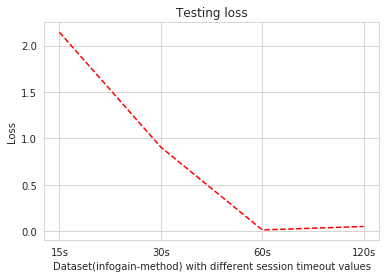

In [103]:
#InforGain
import matplotlib.pyplot as plt
plt.plot(['15s','30s','60s','120s'], [2.143722544564178,0.904519118658928,0.012011509596239117,0.04920295137669515], 'r--', label='loss')
plt.title('Testing loss')
plt.xlabel('Dataset(infogain-method) with different session timeout values')
plt.ylabel('Loss')
#plt.axis([-1, 4, -0.5, 3.5])
plt.show()

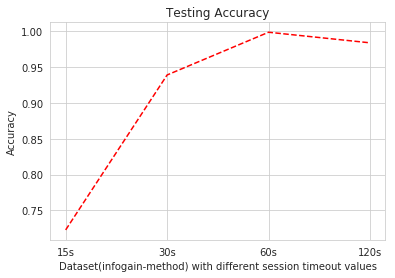

In [104]:

plt.plot(['15s','30s','60s','120s'], [0.7227423739051646, 0.9391233766233766, 0.9987829614604462, 0.9840047393364929], 'r--', label='loss')
plt.title('Testing Accuracy')
plt.xlabel('Dataset(infogain-method) with different session timeout values')
plt.ylabel('Accuracy')
#plt.axis([-1, 4, 0.0, 1.0])
plt.show()

In [ ]:
df_data.describe(include='all')